## Define Function for reading in xy or xz plane slices

Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


(-3.0, 3.0)

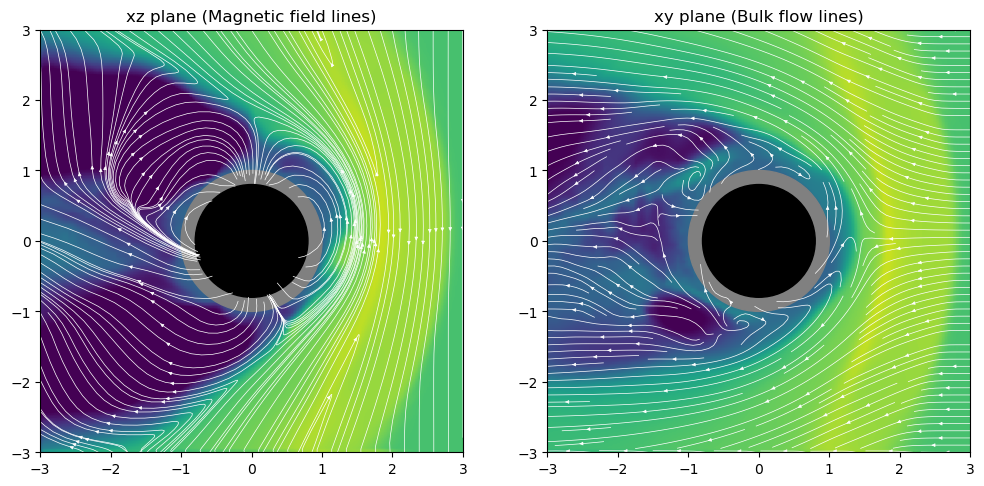

In [1]:
# Efficient module for generating movies from 2D tecplot.
# Make sure pytecplot connection is exposed!!

# import modules
from os import listdir
from os.path import isfile, join
import re
import tecplot as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *
import matplotlib.animation as animation
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl

# Define constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m

# Define data extraction function
def extract_2d_grid(mypath,var_ls=["Rho*"],plane="xy",shape=[20,20],xlims=[-2.5,2.5],ylims=[-2.5,2.5]):
    # Loads file "mypath"
    # Slices along "plane" (either xy at z=0.2 or xz at y=0)
    # Extracts interpolated 2d meshgrid with size "shape" within bounds (xmin,xmax) (ymin,ymax)
    # Returns a dictionary of 2d meshgrids for each var in var_ls

    # Note: y is used to refer to the "vertical" coordinate, which could be Y or X

    # Connect to tp and load data
    tp.session.connect()
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    plot = frame.plot(PlotType.Cartesian2D)
    plot.axes.x_axis.variable_index=2

    # Define meshgrid params
    nx = shape[0]
    ny = shape[1]
    xmin,xmax = xlims
    ymin,ymax = ylims
    
    # Generate meshgrids
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)
    tp.active_frame().plot().axes.x_axis.variable_index=2
    if plane=="xy":
        xx, yy = np.meshgrid(x, y)
        zz = 0.2+np.zeros_like(xx)
        plot.axes.y_axis.variable_index=3 # Assign the vertical axis to y
    elif plane=="xz":
        xx, zz = np.meshgrid(x, y)
        yy = np.zeros_like(xx)
        plot.axes.y_axis.variable_index=4 # Assign the vertical axis to z
    else: 
        print("ERROR: bad slice plane!")
        return None

    # Perform needed calculations within tp
    tp.data.operate.execute_equation(equation='{Bmag} = sqrt({B_x [nT]}**2+{B_y [nT]}**2+{B_z [nT]}**2)',
        ignore_divide_by_zero=True)
    #tp.data.operate.execute_equation(equation='{dB_ZdX}=ddx({B_z [nT]})',
    #    ignore_divide_by_zero=True)

    # Define zone to interpolate to
    rect_zone = dataset.add_ordered_zone('current_sheet',shape)

    rect_zone.values('X*')[:] = xx.ravel()
    rect_zone.values('Y*')[:] = yy.ravel()
    rect_zone.values('Z*')[:] = zz.ravel()
    
    X_seed = rect_zone.values('X*')
    Y_seed = rect_zone.values('Y*')
    Z_seed = rect_zone.values('Z*')

    # Interpolate each param of interest; see previous code block for more explicit example
    out_dict={}
    for var in var_ls:
        tp.data.operate.interpolate_linear(rect_zone, dataset.zone('STRUCTURED*'), dataset.variable(var))
        temp = rect_zone.values(var).as_numpy_array() 
        out = np.zeros_like(xx)
        count=0
        for j in range(ny):
            for i in range(nx):
                out[-j,-i] = temp[-count]
                count+=1
        out_dict[var]=out

    return out_dict, xx, yy, zz

# show test use and example plots
xlims=[-3,3]
ylims=[-3,3]
shape=[150,150]

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6*2,6))

filename = '/Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-3-test/box_var_2_t00000150_n00602152.plt'
my_data,xx,yy,zz = extract_2d_grid(filename,var_ls=["Rho*","B_x*","B_z*"],shape=shape,xlims=xlims,ylims=ylims,plane="xz")
im=axs[0].imshow(my_data["Rho*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=150), origin='lower')
axs[0].streamplot(xx,zz,my_data["B_x*"],my_data["B_z*"],color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5)
axs[0].set_title("xz plane (Magnetic field lines)")
axs[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
axs[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
axs[0].set_xlim(xlims)
axs[0].set_ylim(xlims)

filename = '/Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-3-test/box_var_1_t00000150_n00602152.plt'
my_data,xx,yy,zz = extract_2d_grid(filename,var_ls=["Rho*","U_x*","U_y*"],shape=shape,xlims=xlims,ylims=ylims,plane="xy")
im=axs[1].imshow(my_data["Rho*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=150), origin='lower')
axs[1].streamplot(xx,yy,my_data["U_x*"],my_data["U_y*"],color='white',linewidth=0.5,density=2,arrowsize=0.5)
axs[1].set_title("xy plane (Bulk flow lines)")
axs[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
axs[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
axs[1].set_xlim(xlims)
axs[1].set_ylim(xlims)

#clb=fig.colorbar(im,ax=axs[2])
#clb.ax.set_title('$rho$ [amu/cc]',fontsize=12)


## Loop this function and save the results as individual frames

111 files recognized!
start time 20.0
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_67025/2587655473.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(16,8))


Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_67025/2587655473.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,10))


Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://local

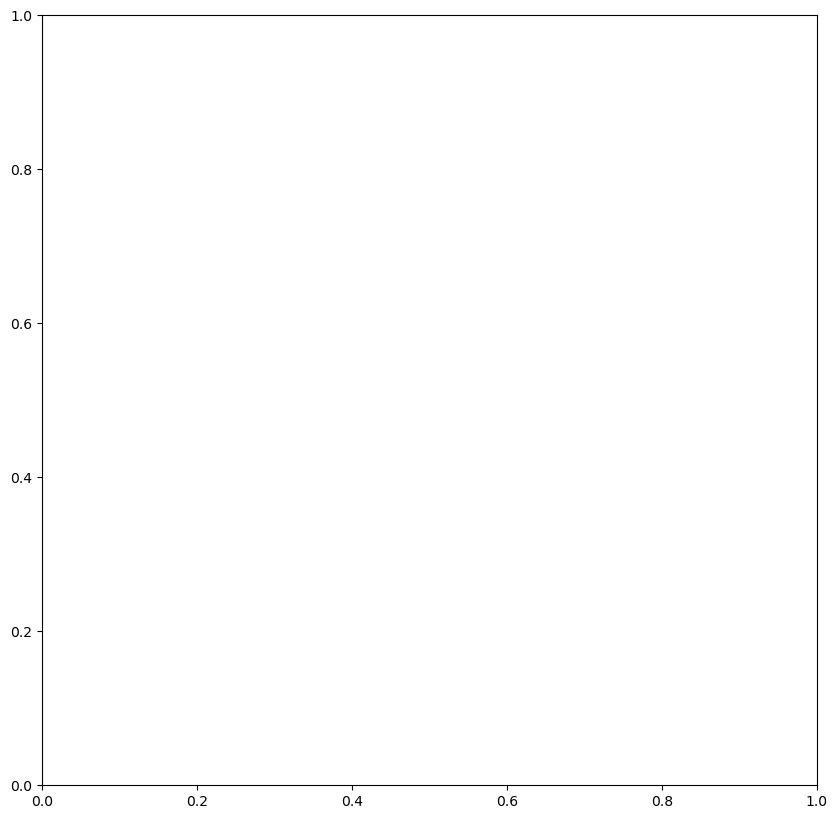

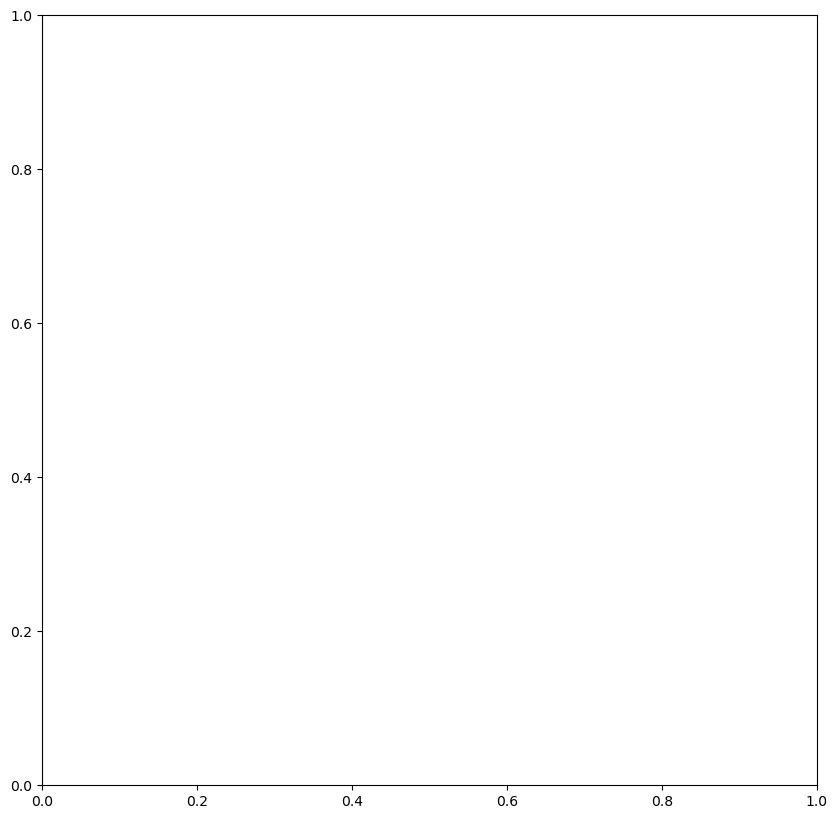

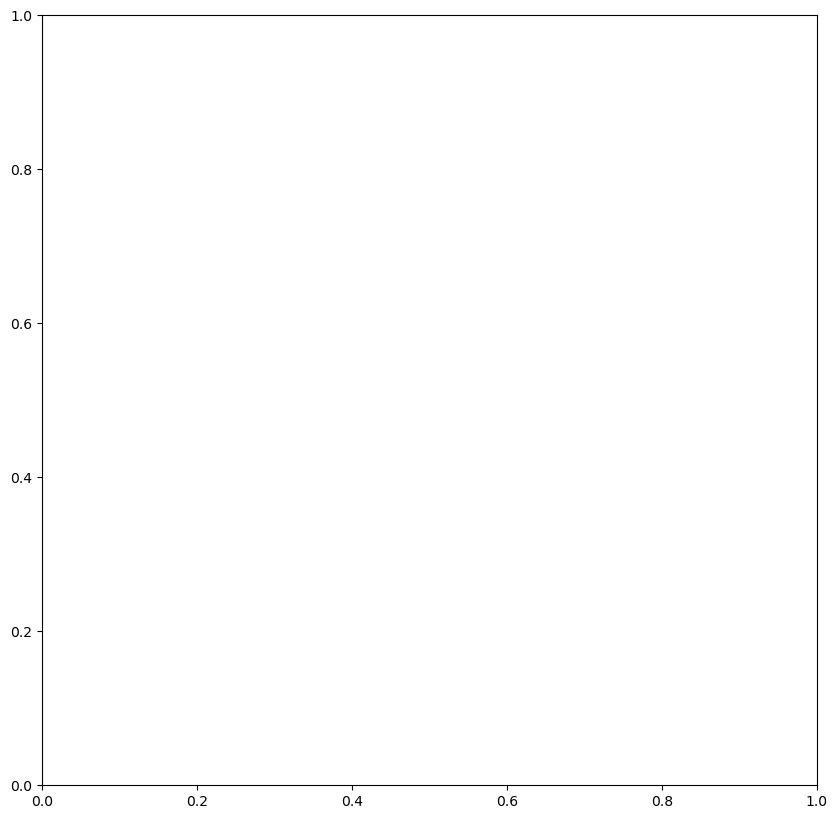

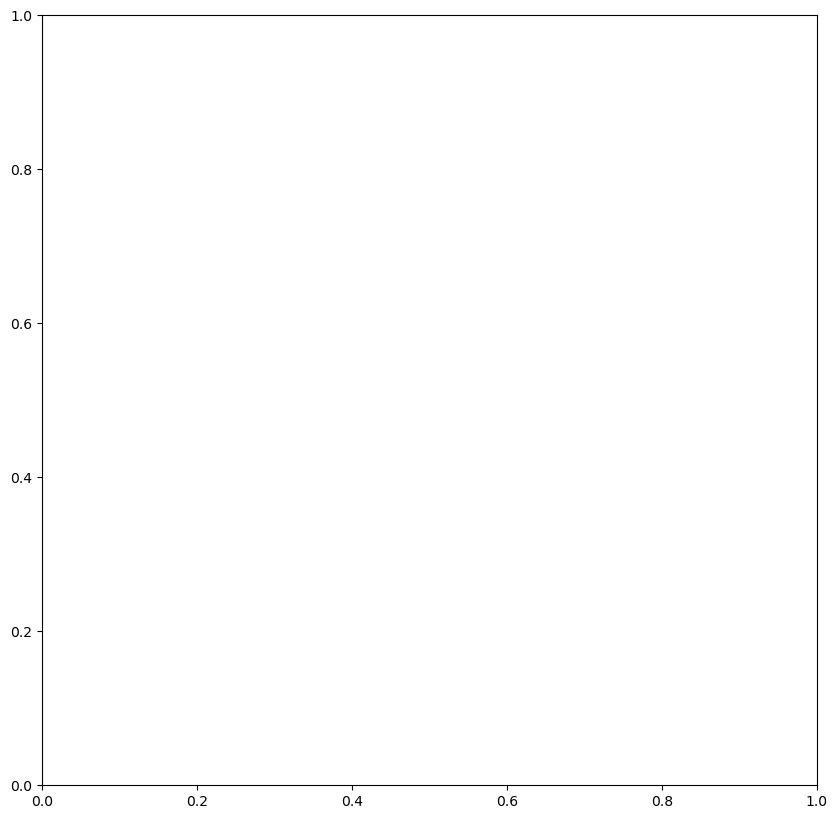

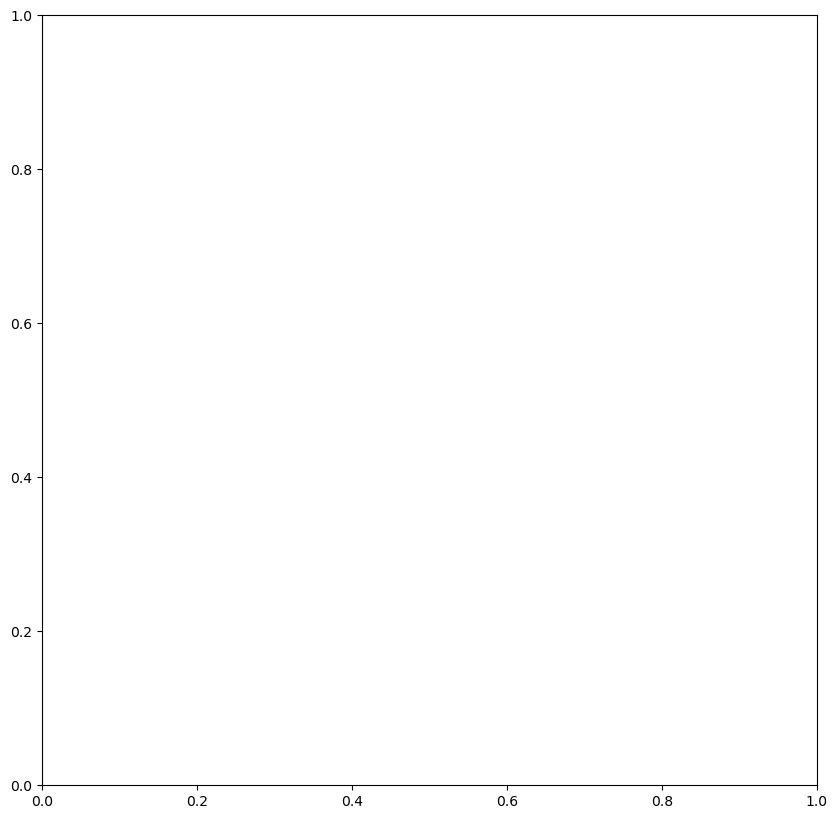

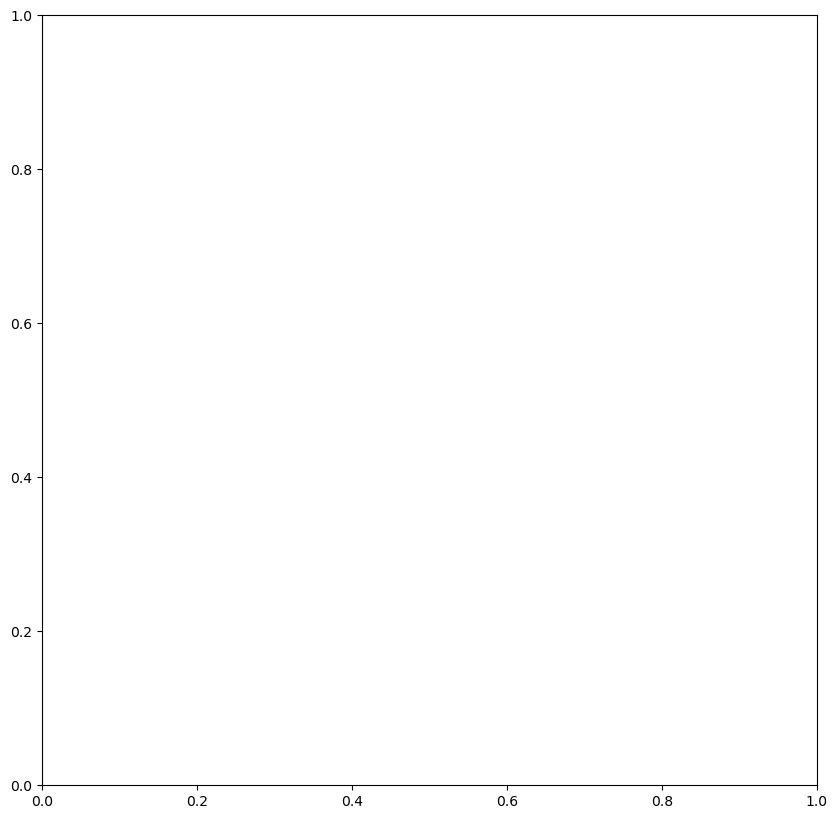

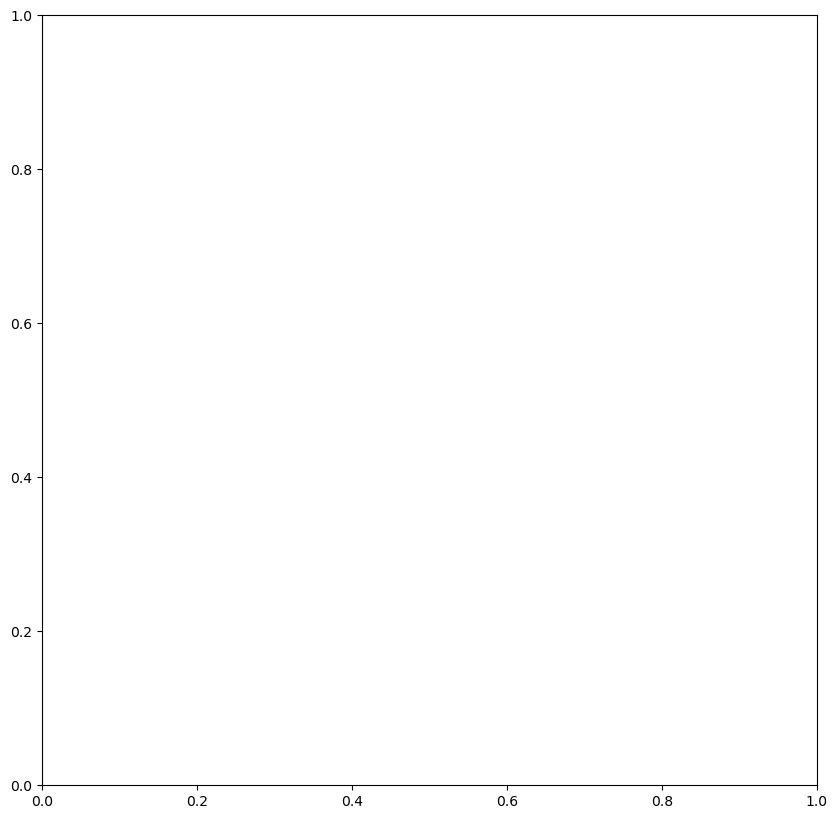

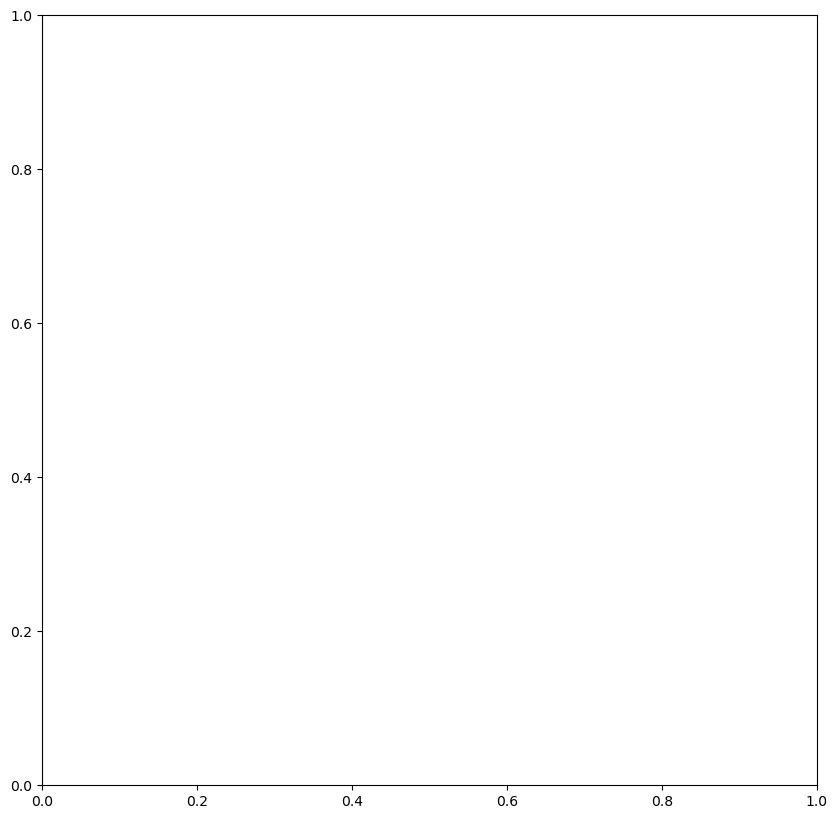

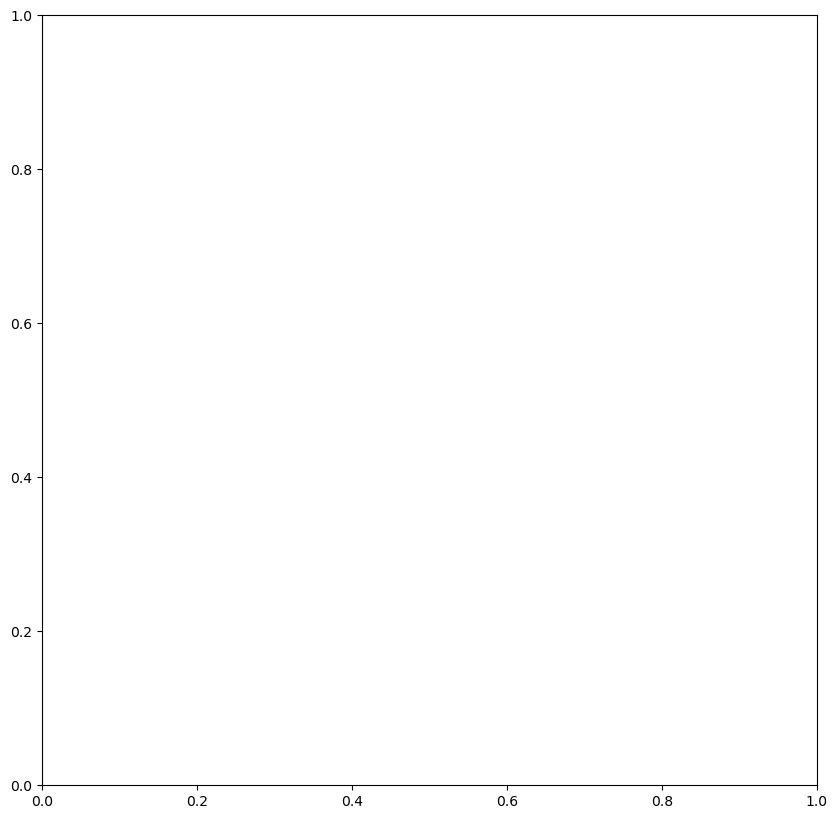

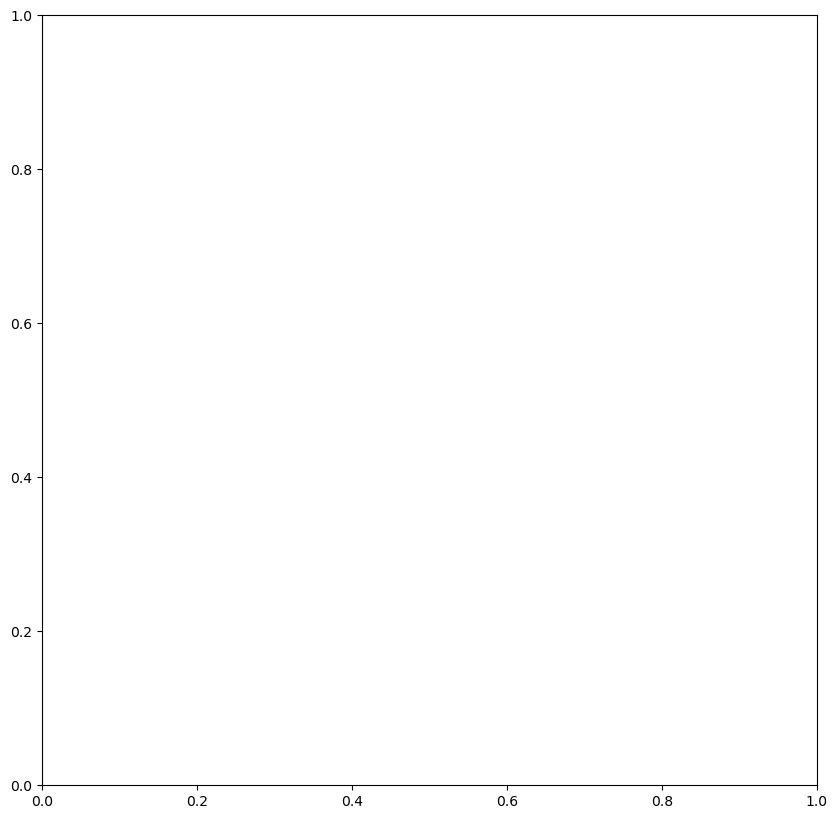

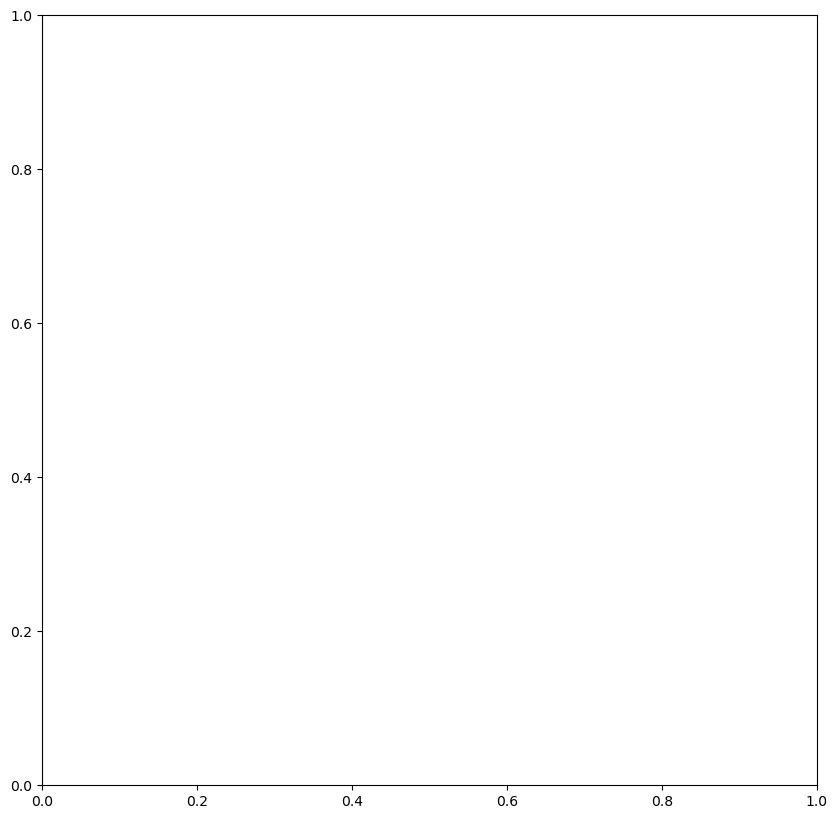

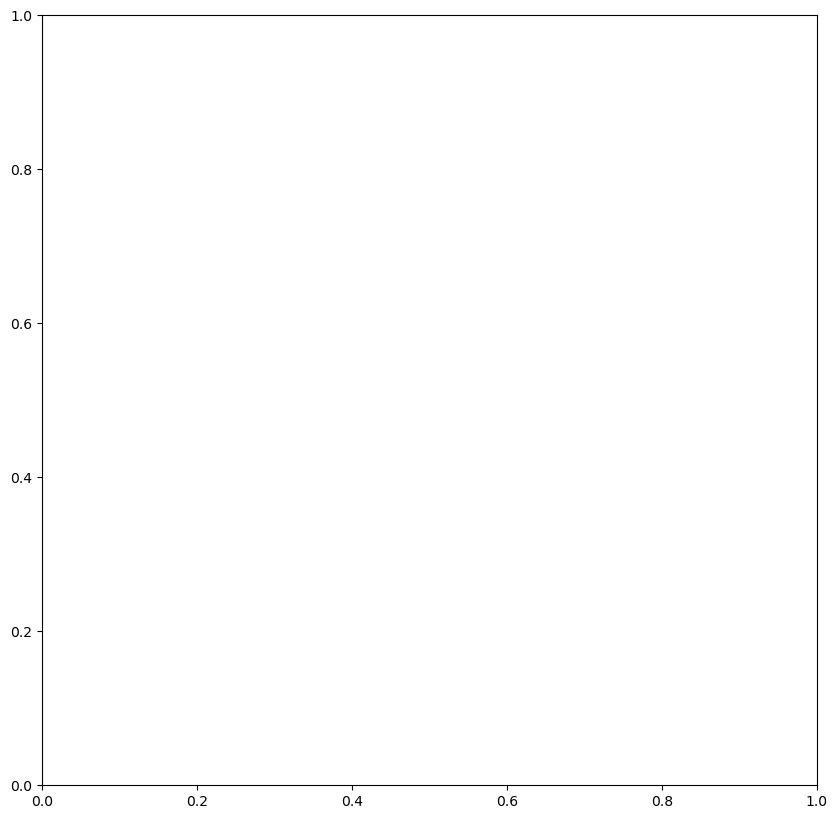

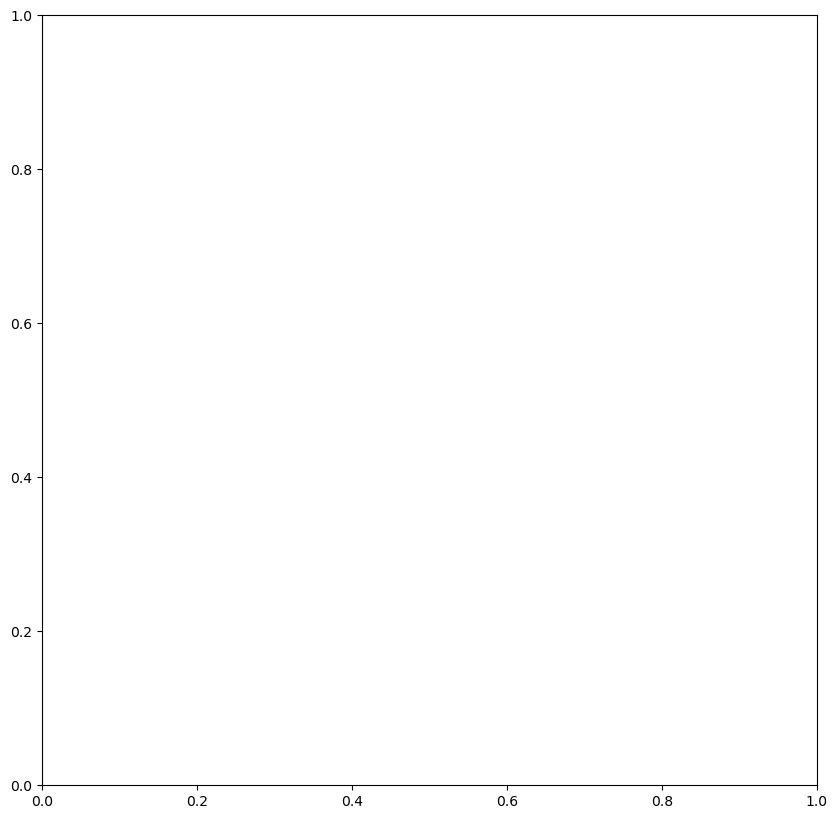

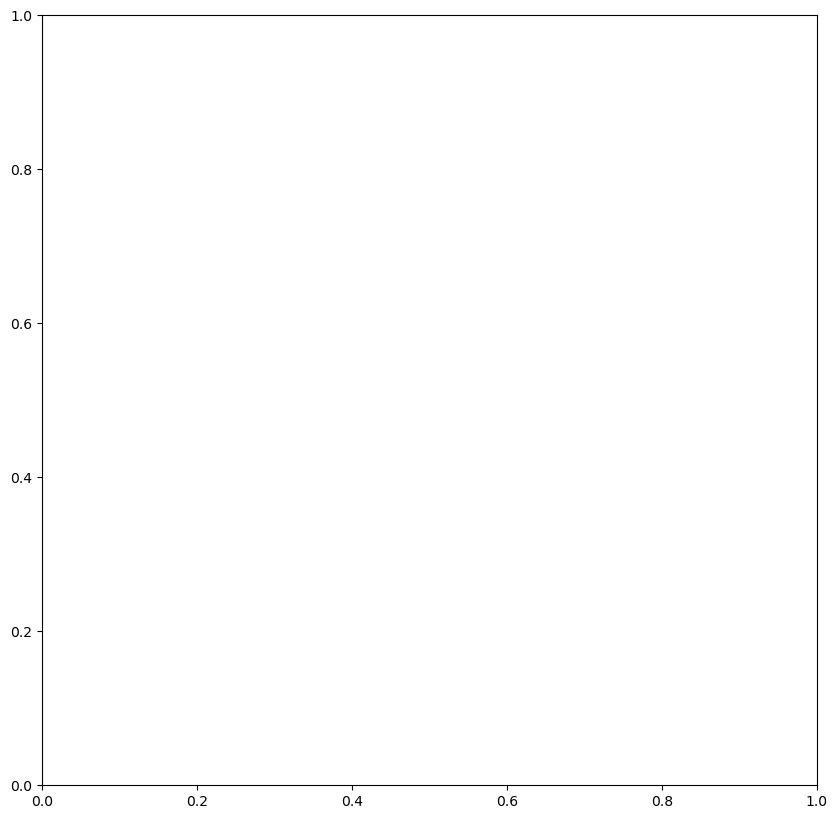

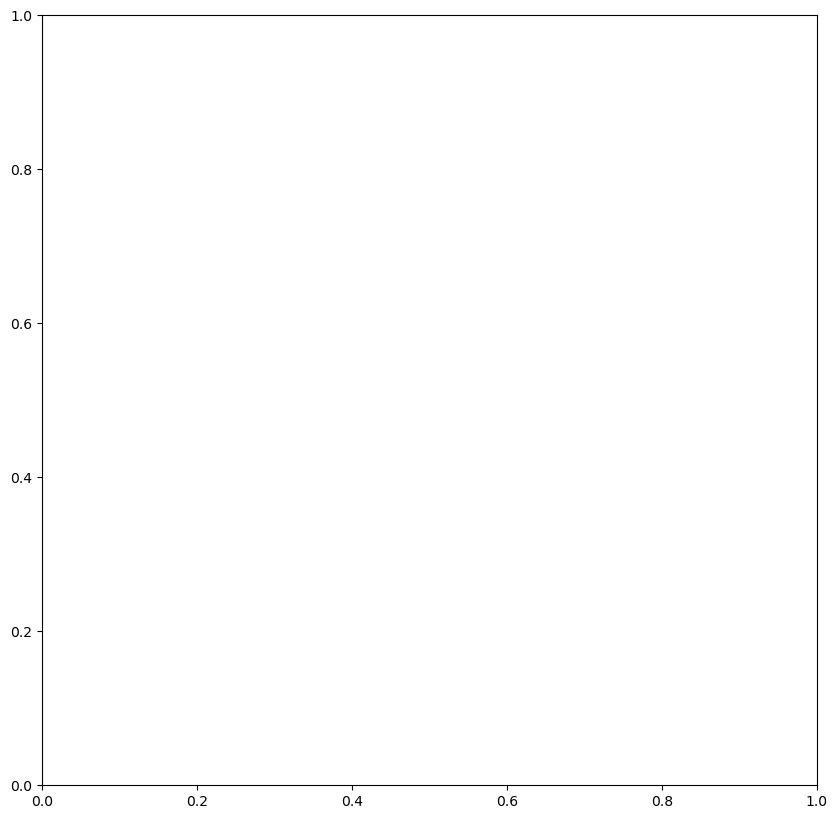

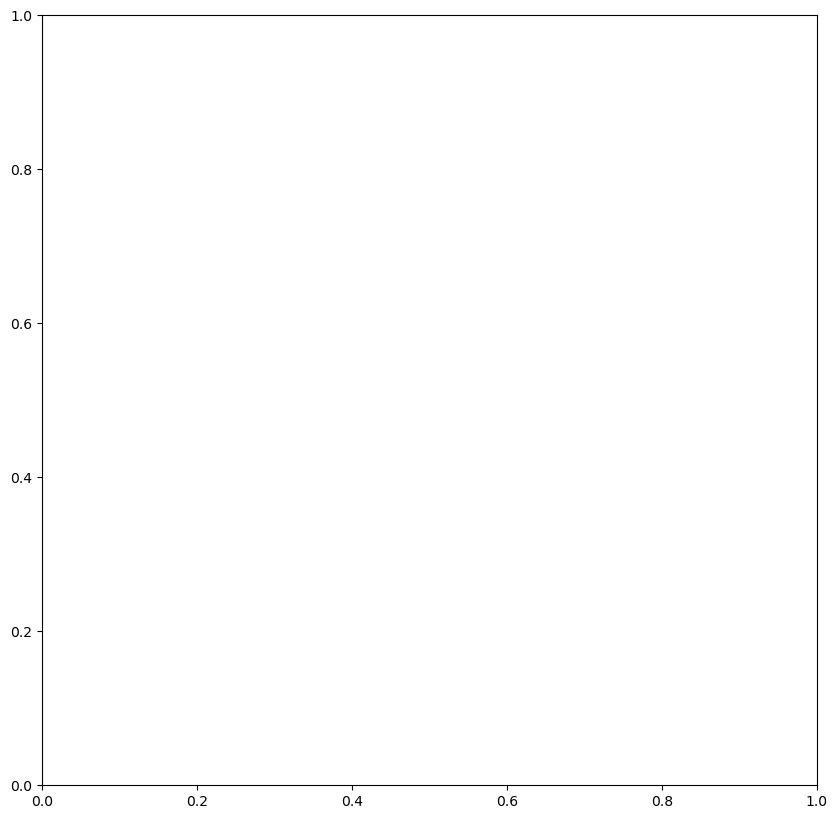

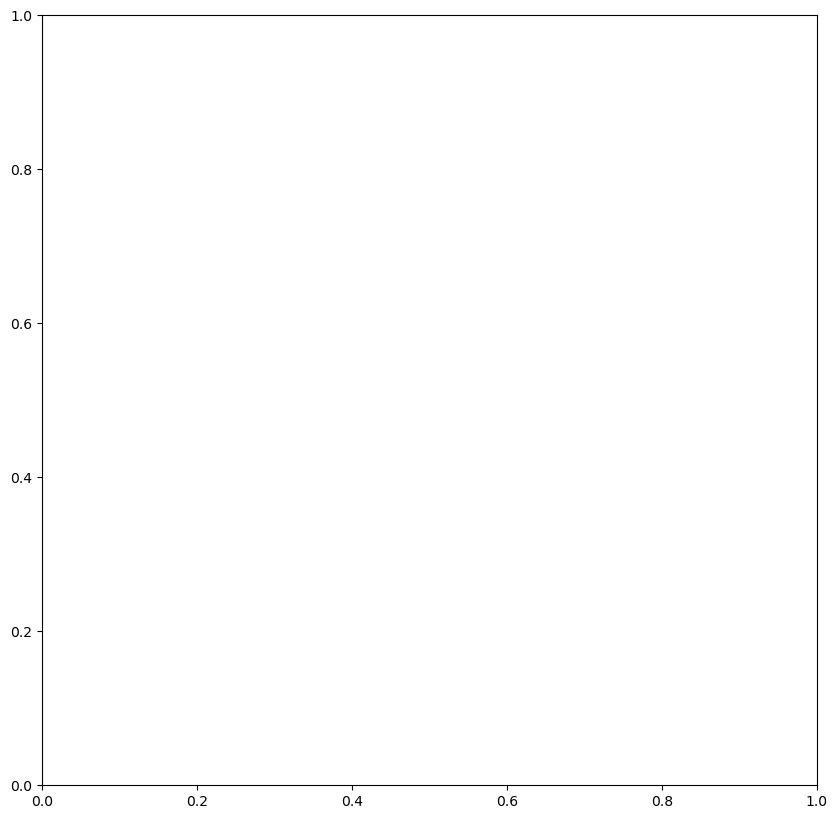

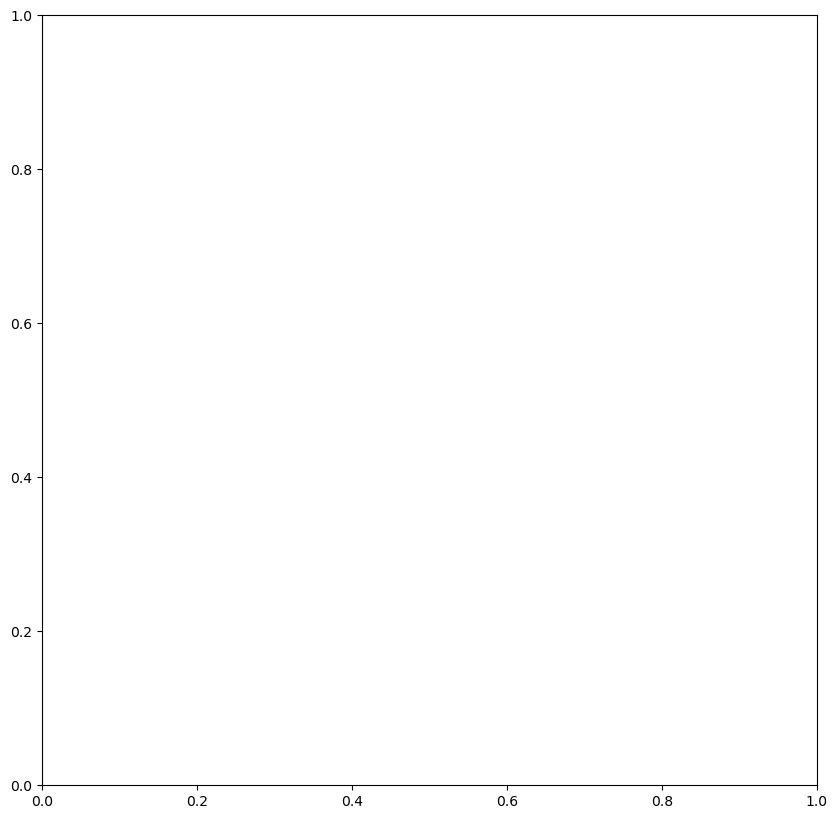

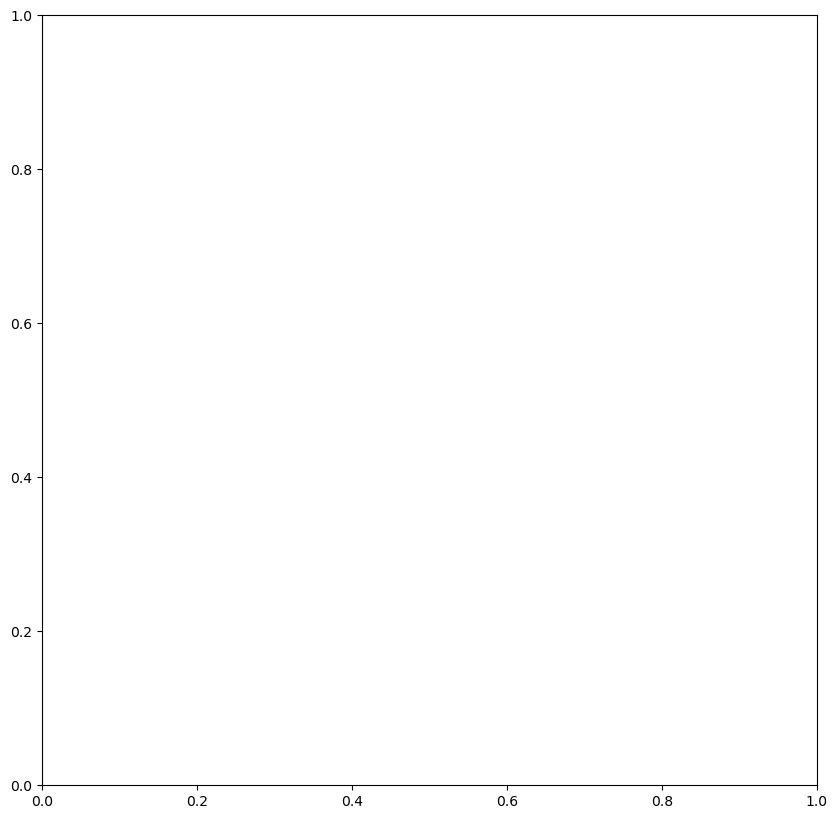

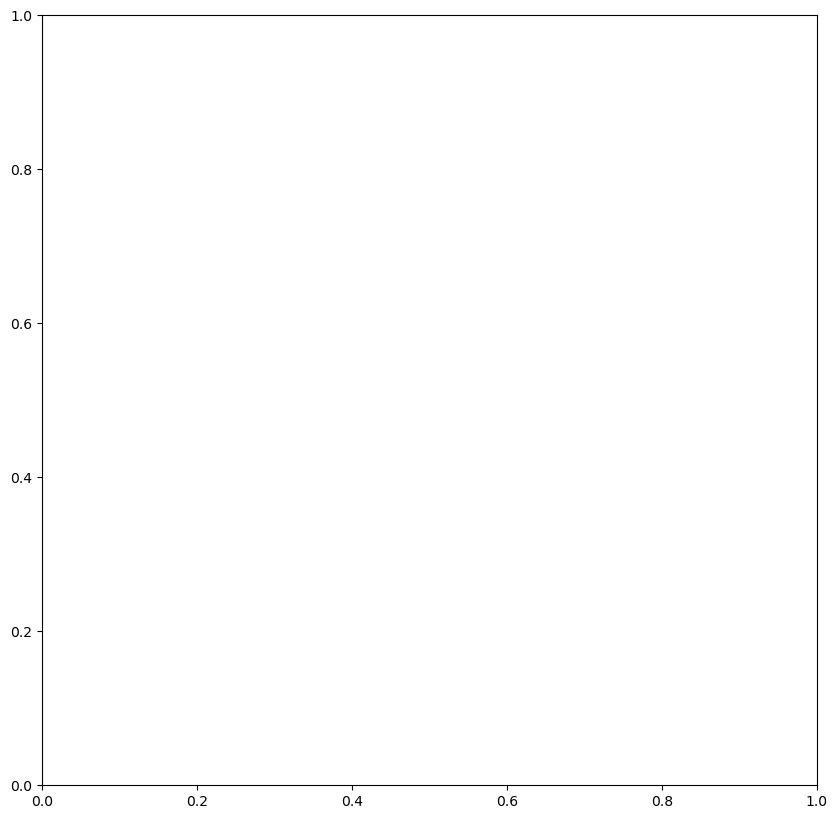

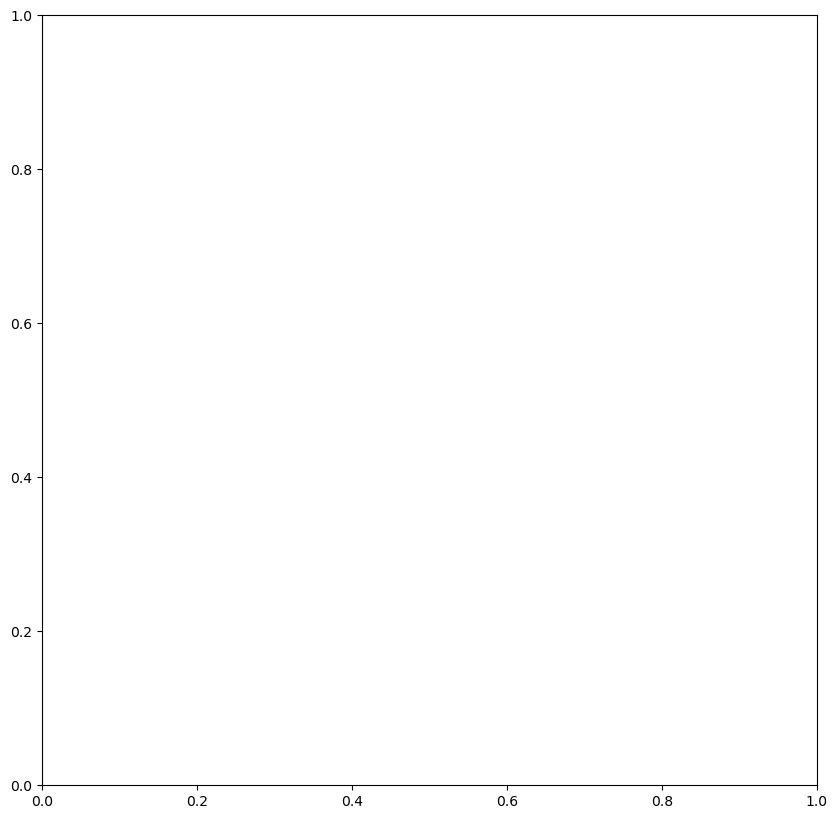

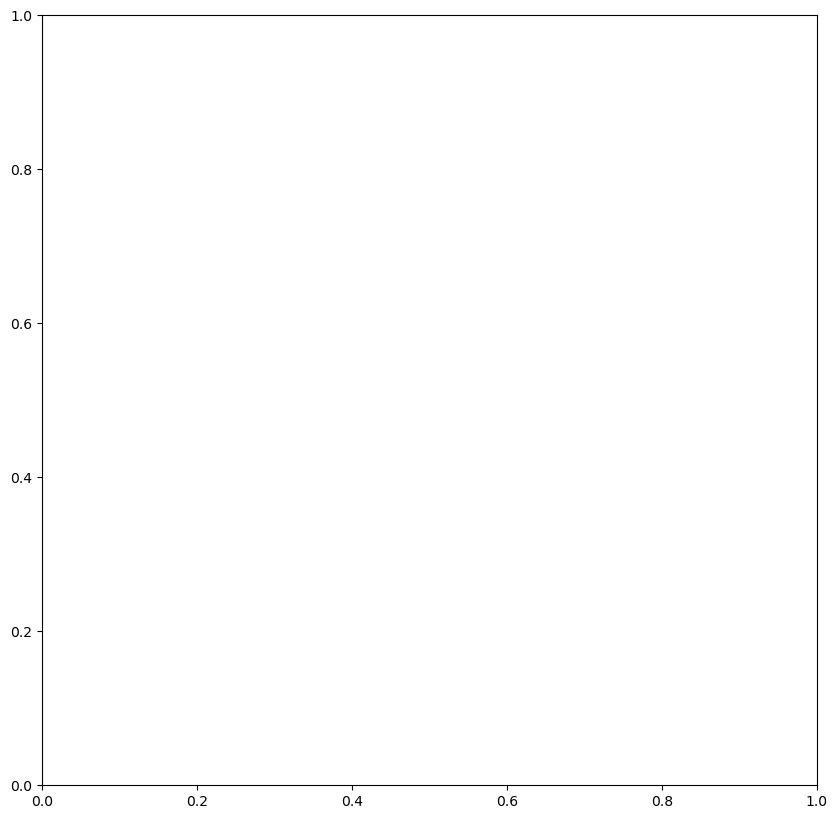

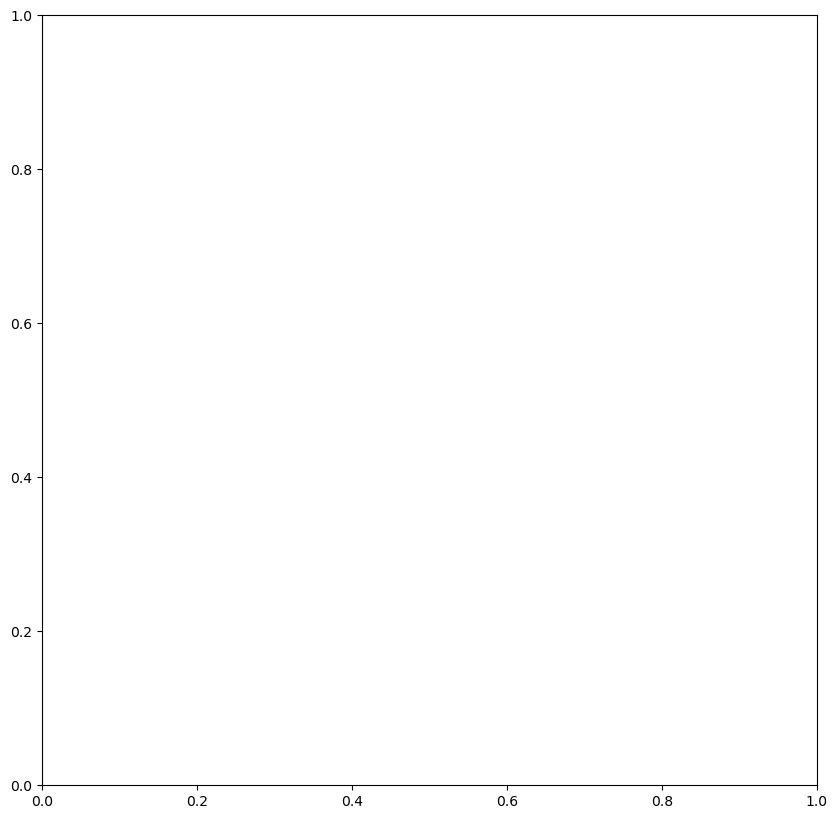

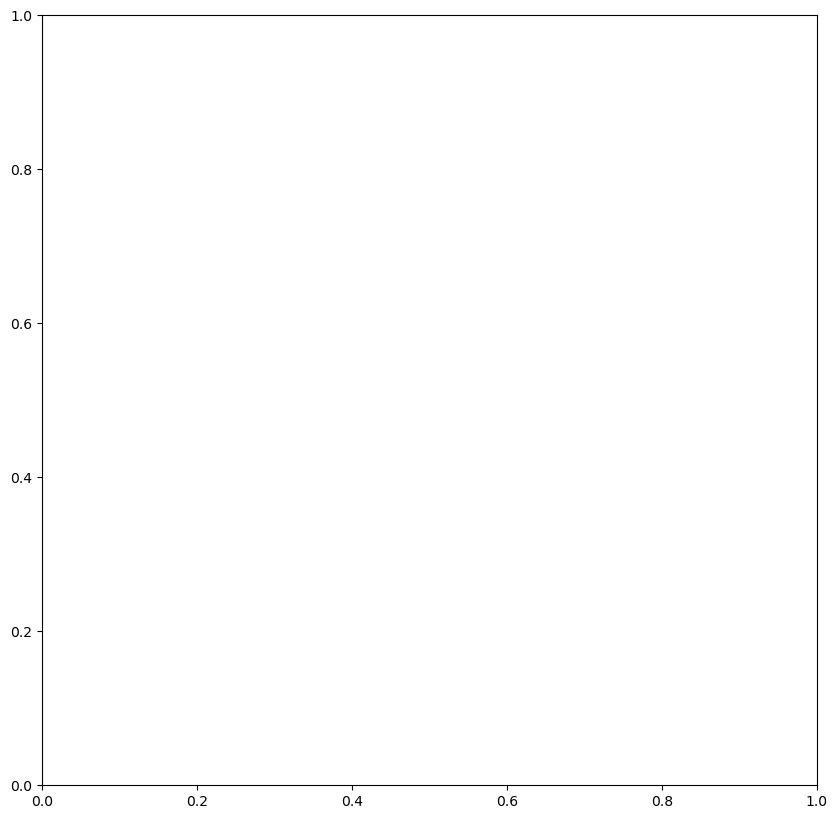

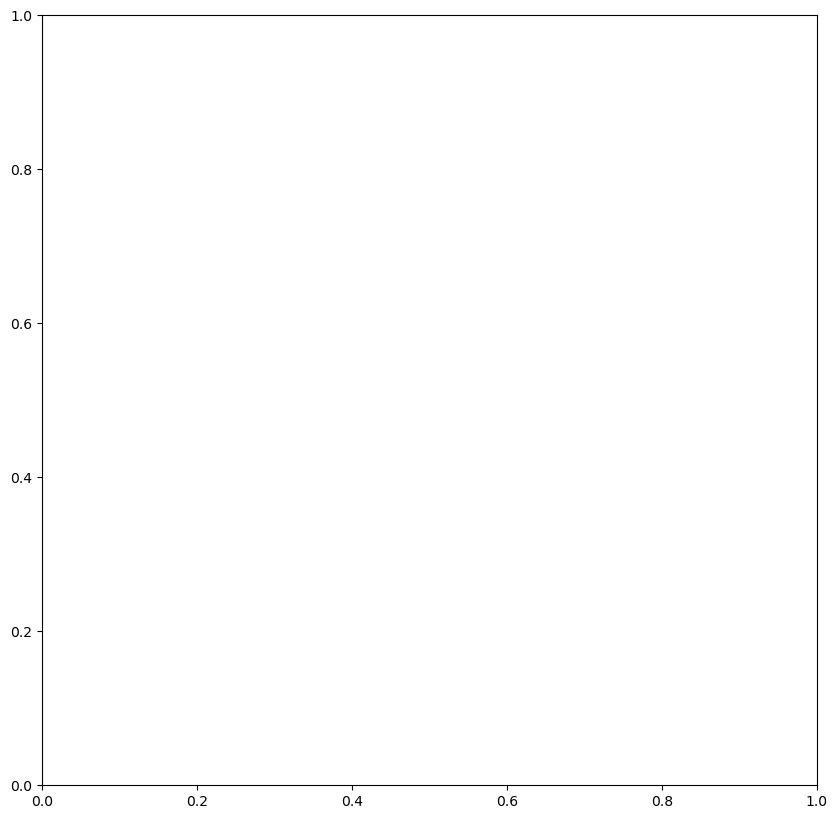

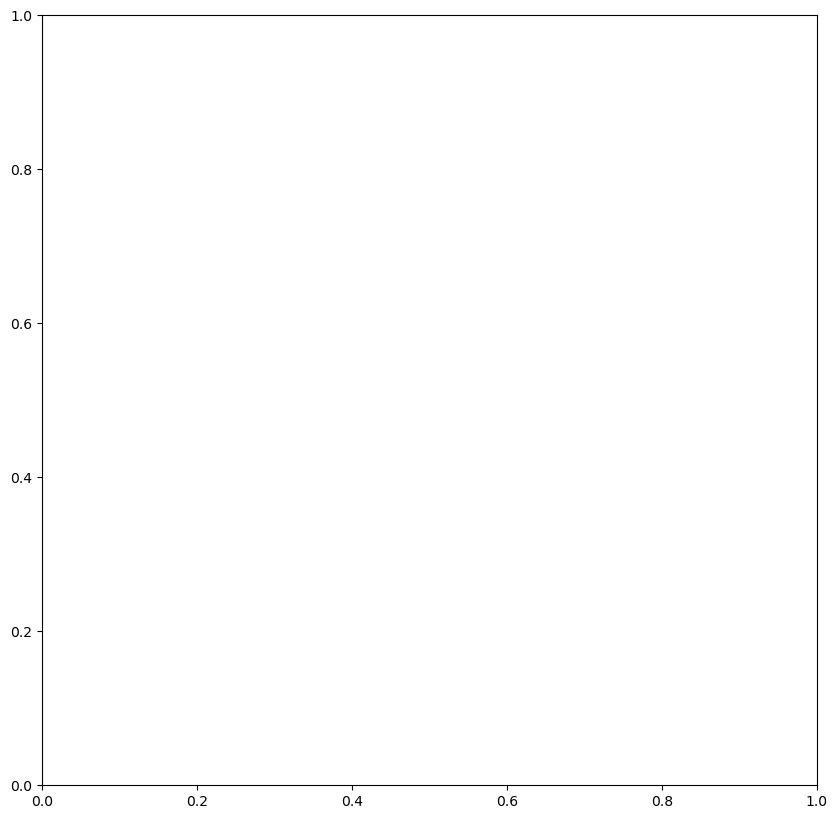

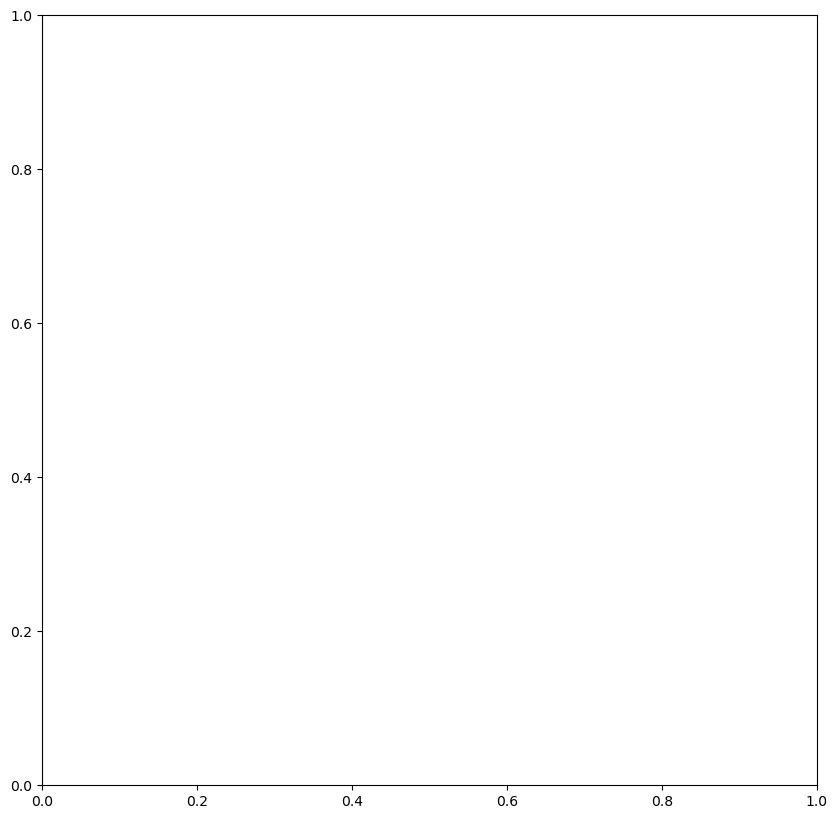

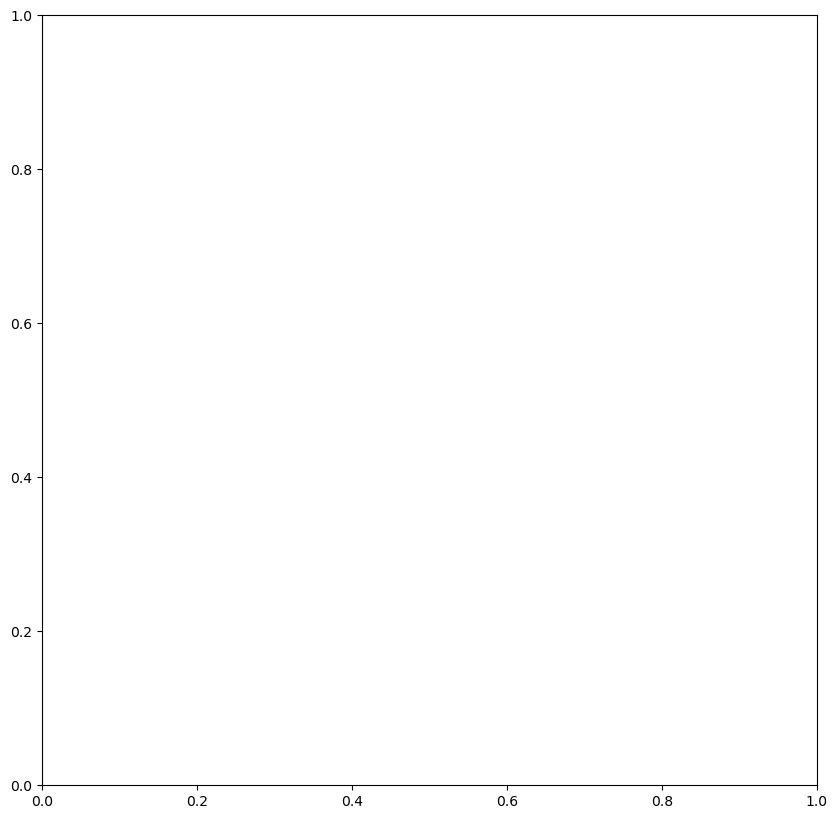

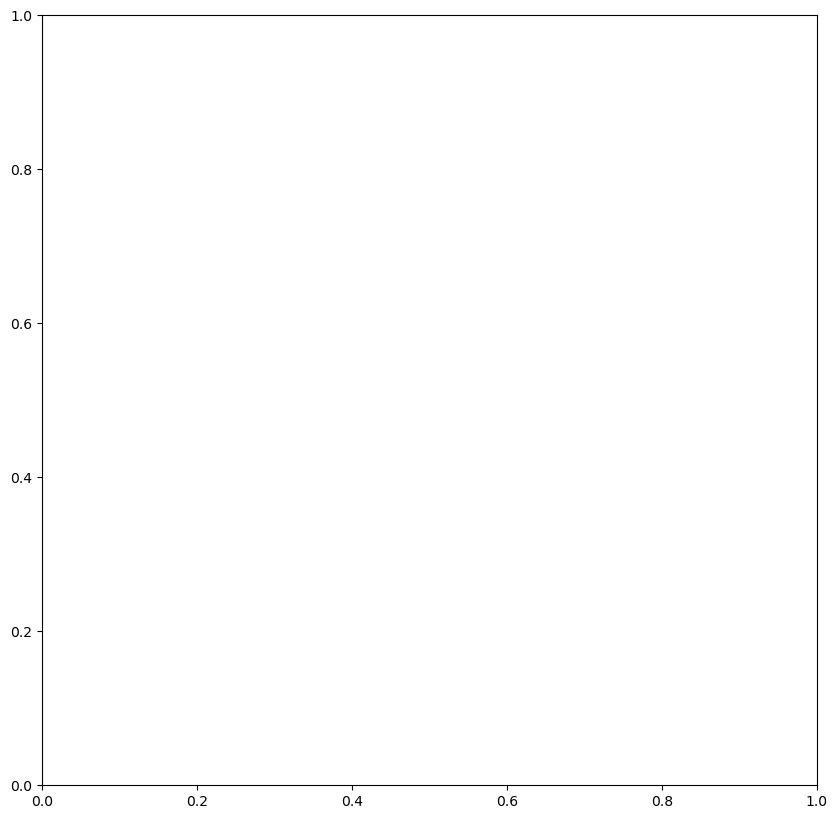

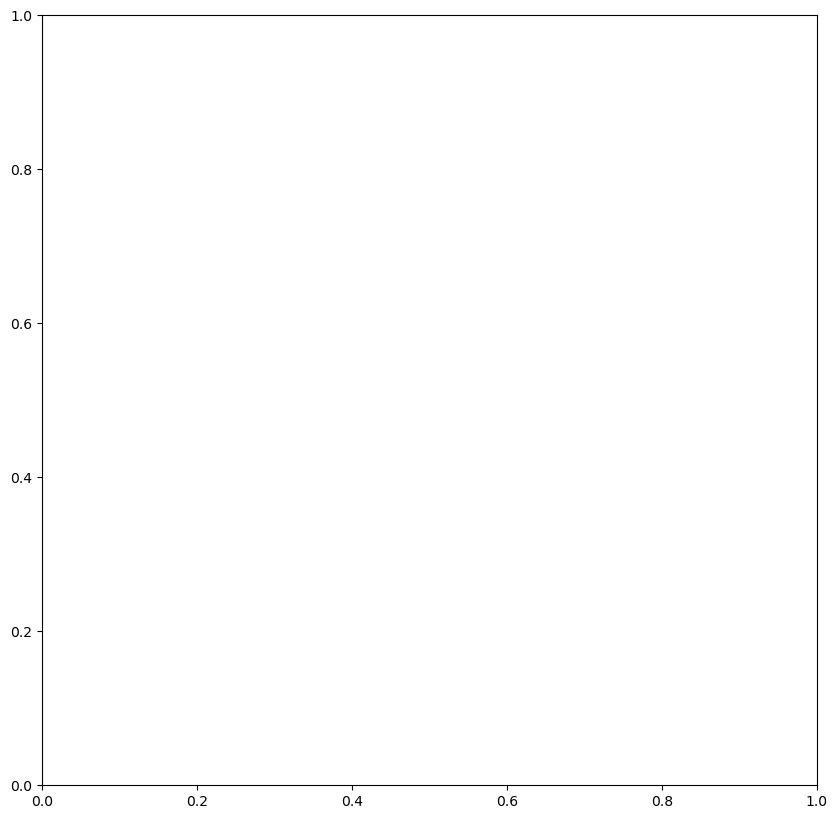

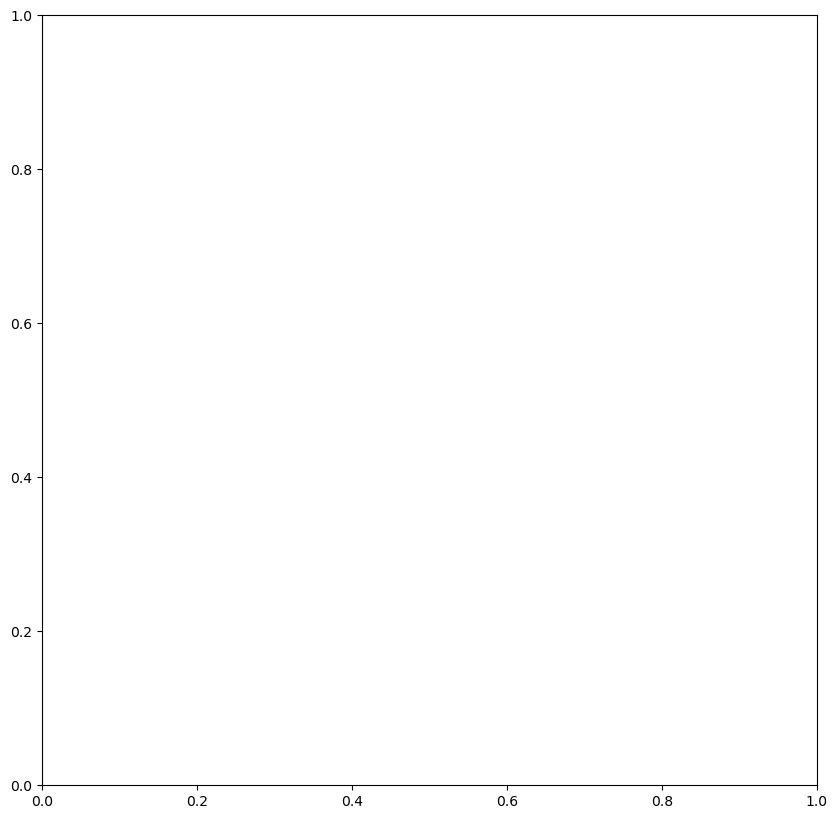

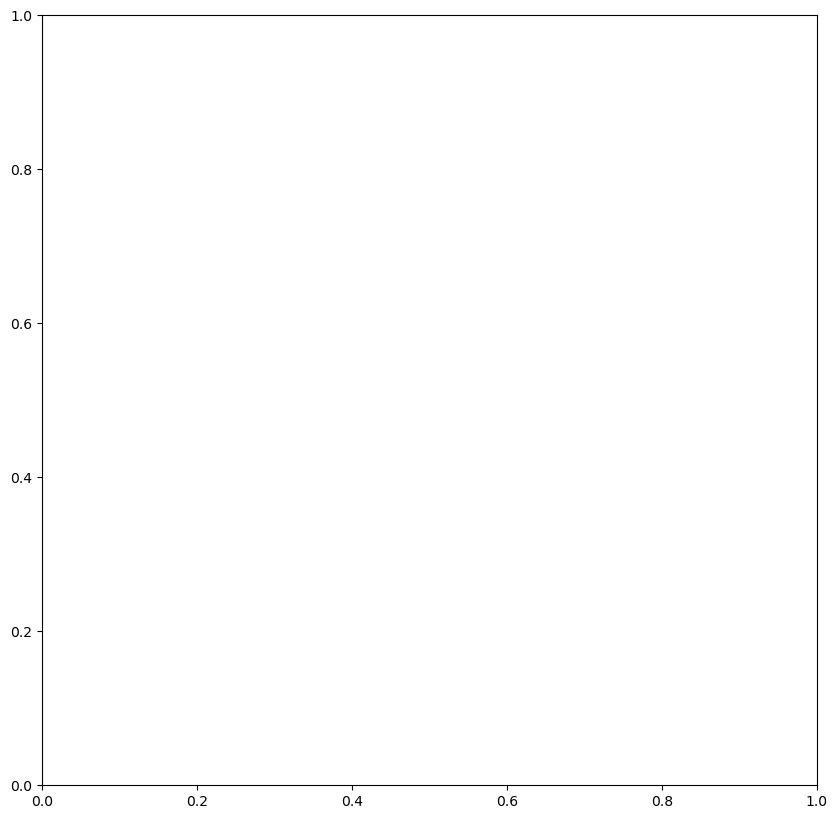

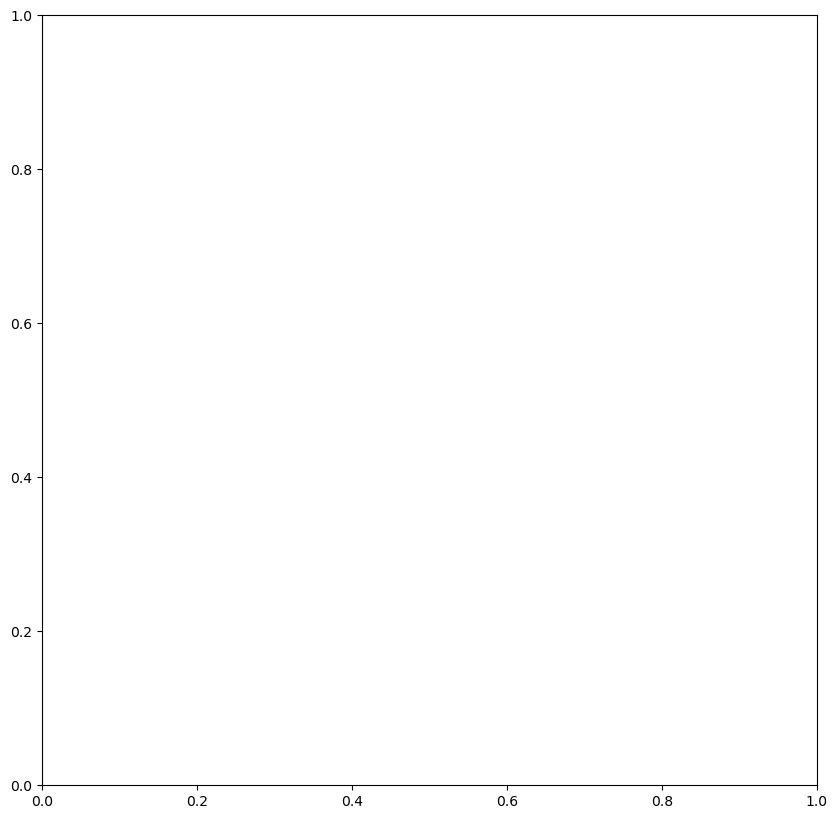

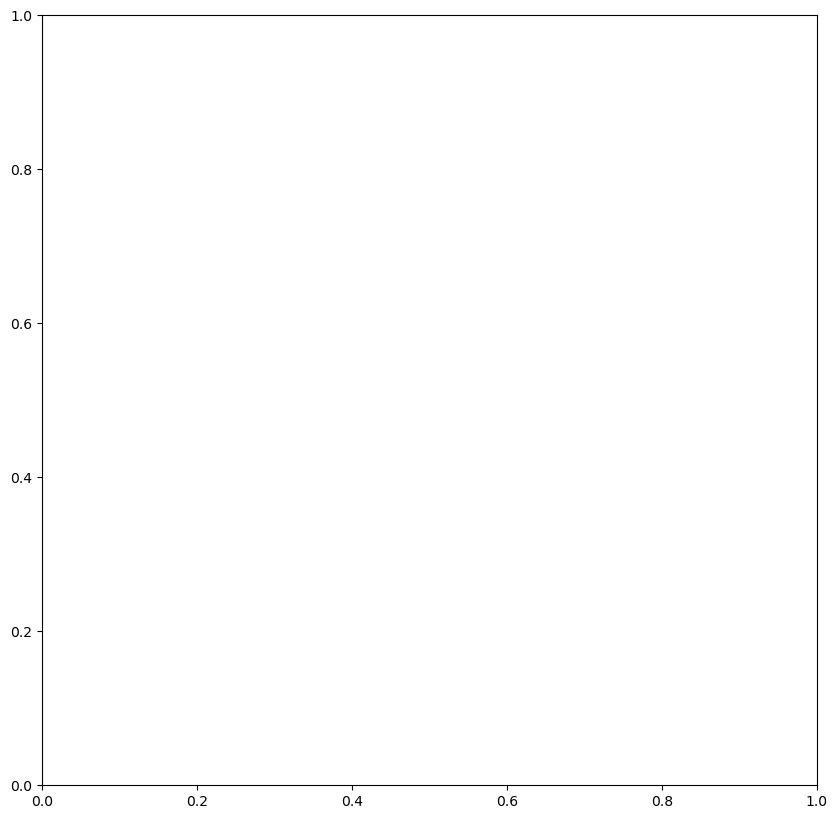

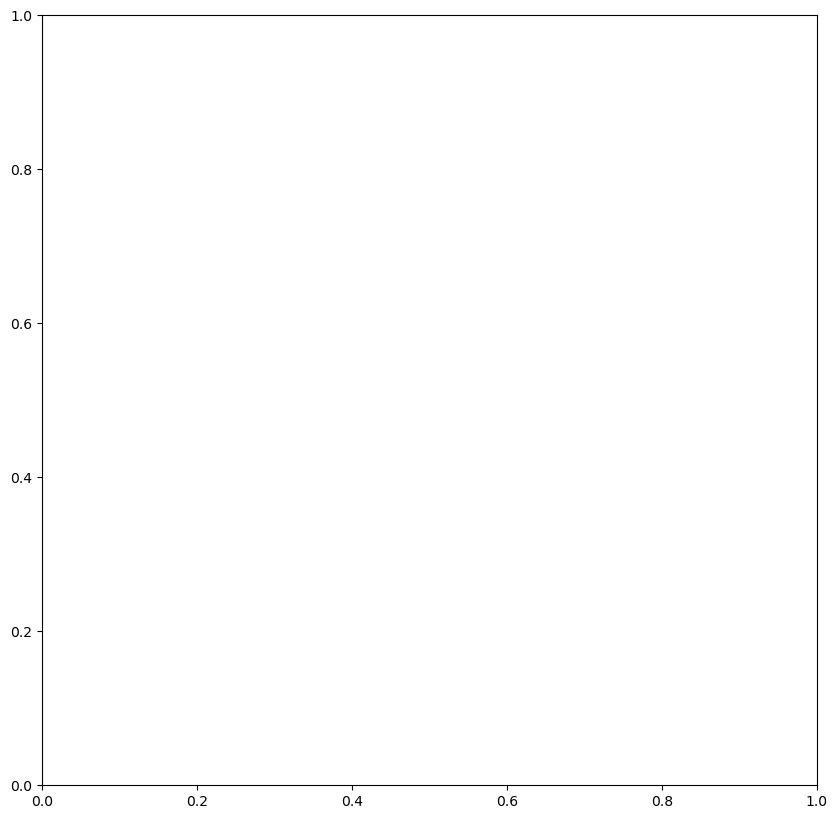

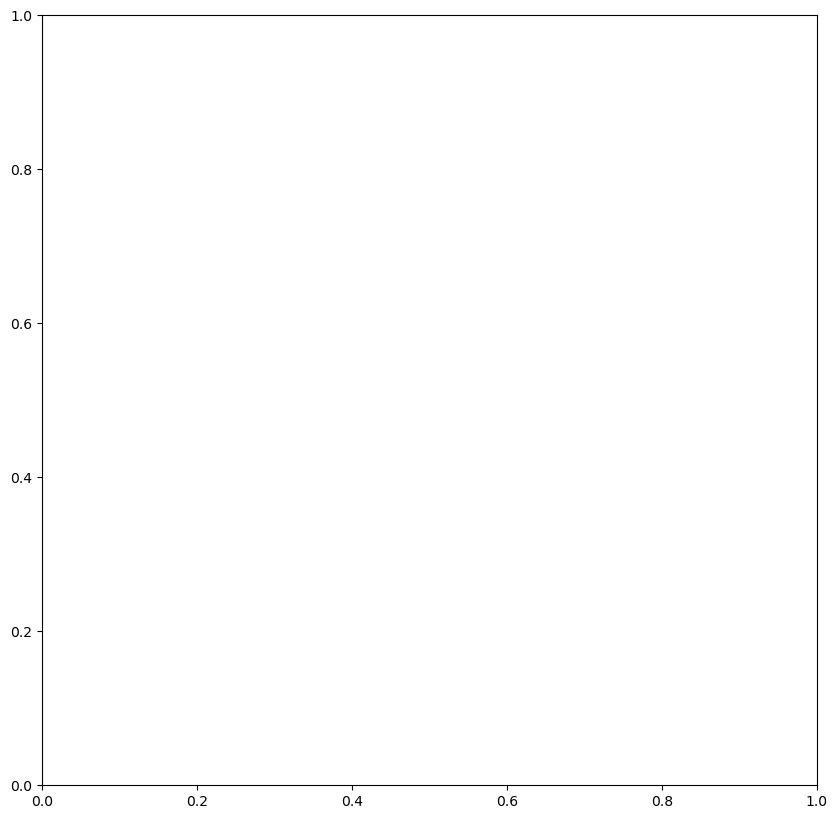

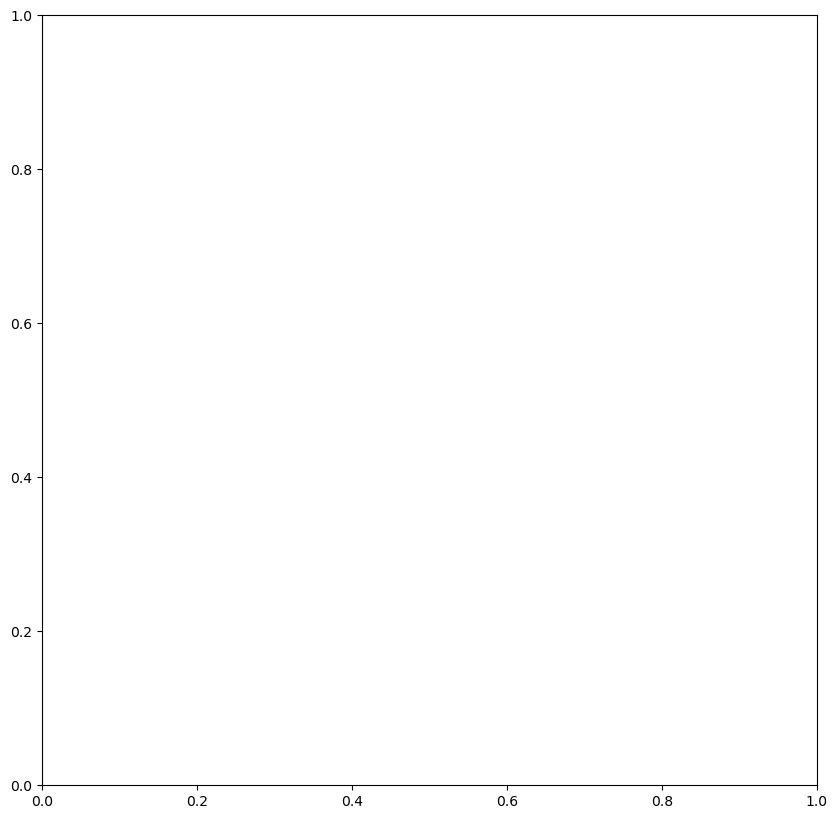

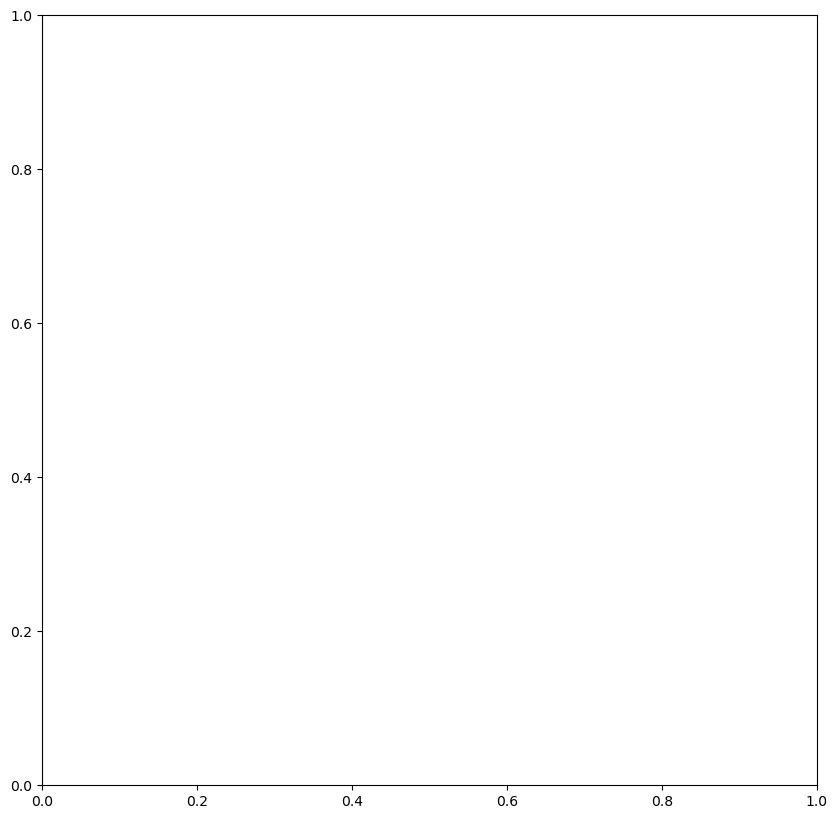

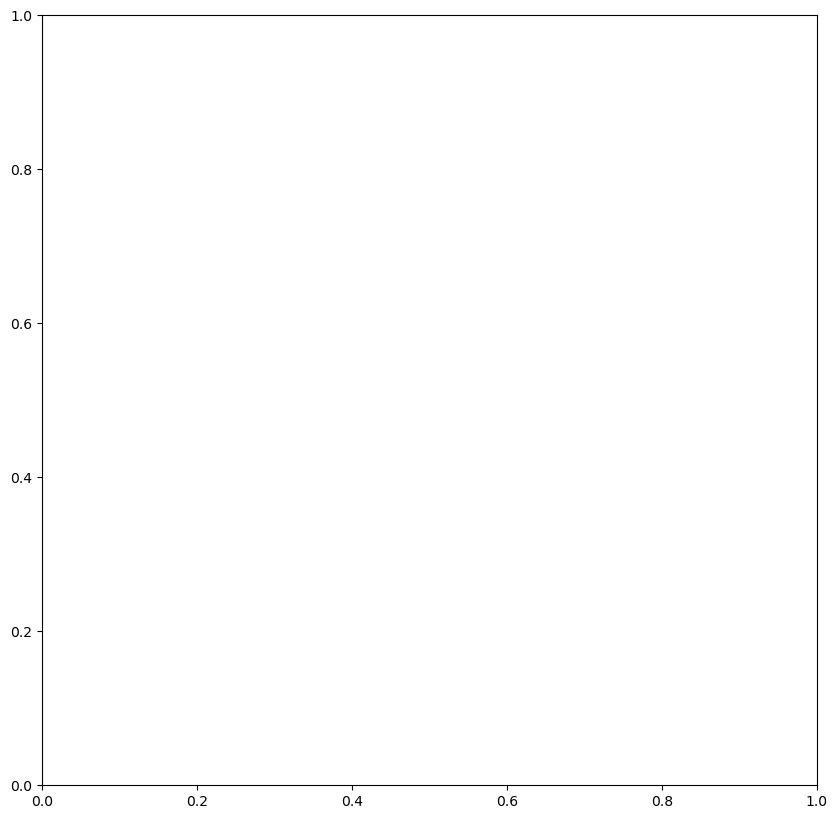

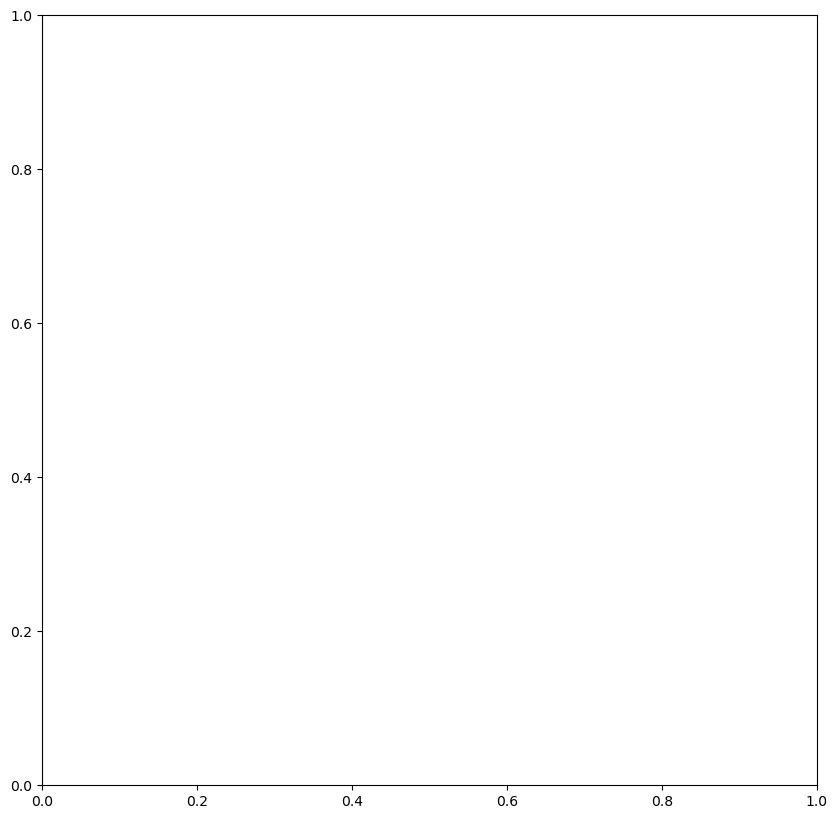

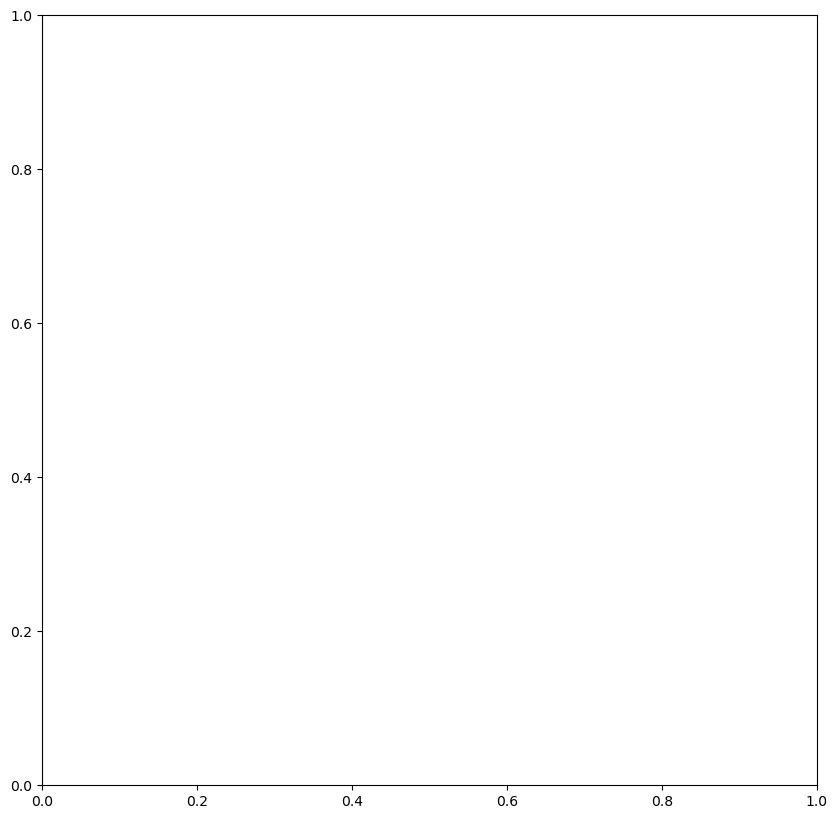

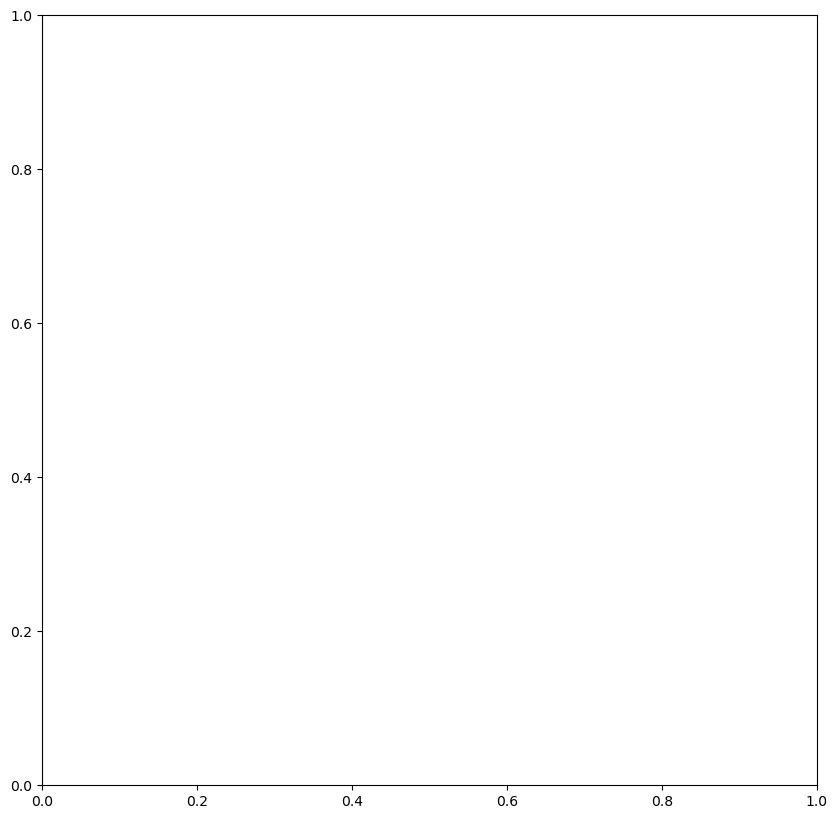

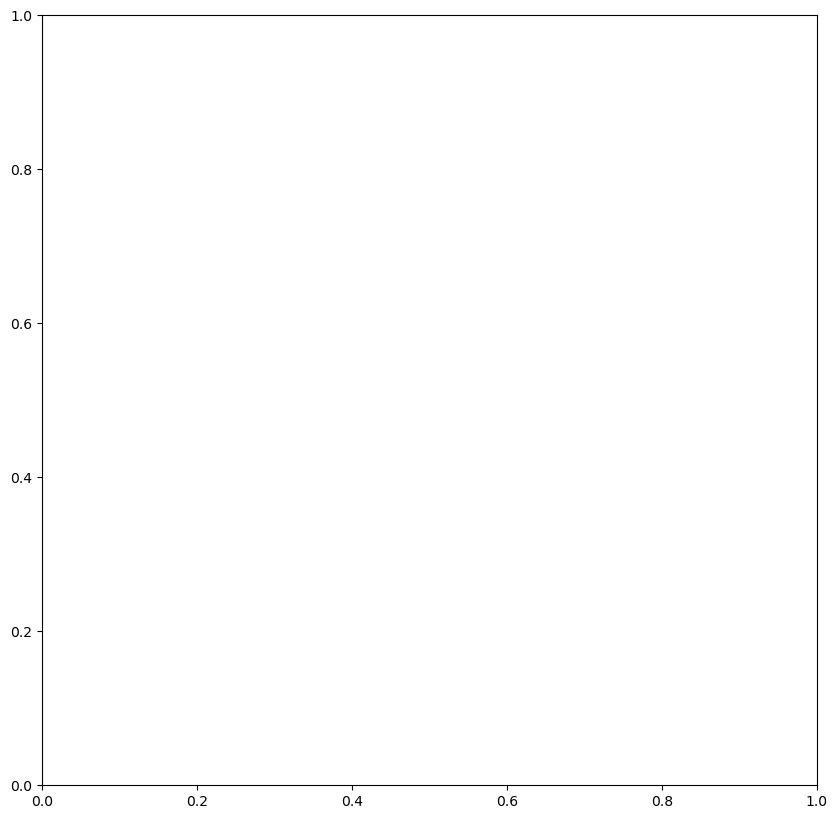

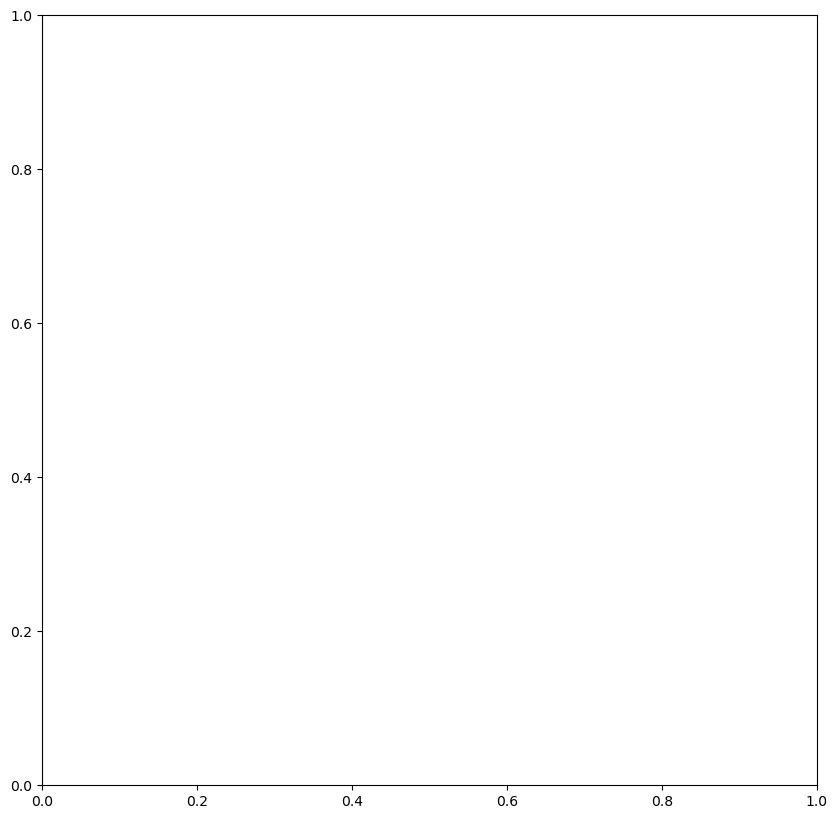

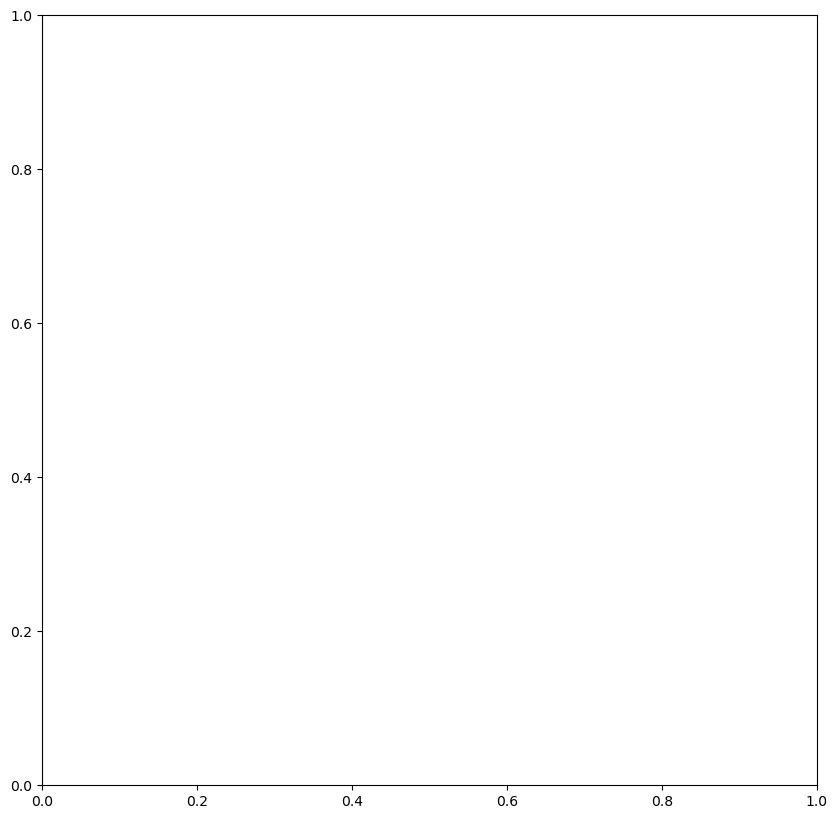

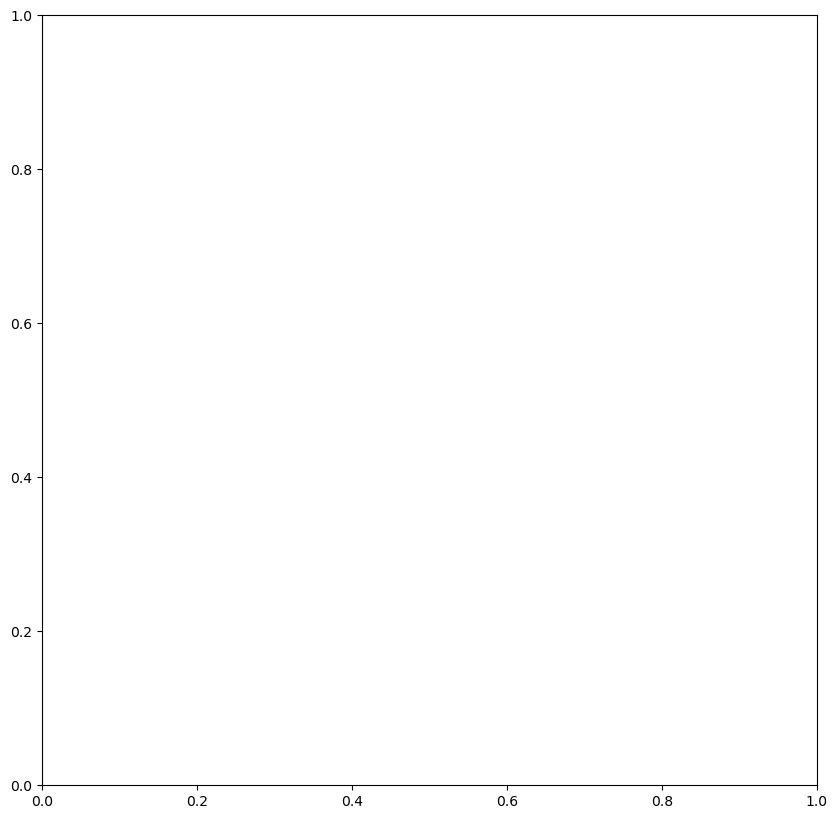

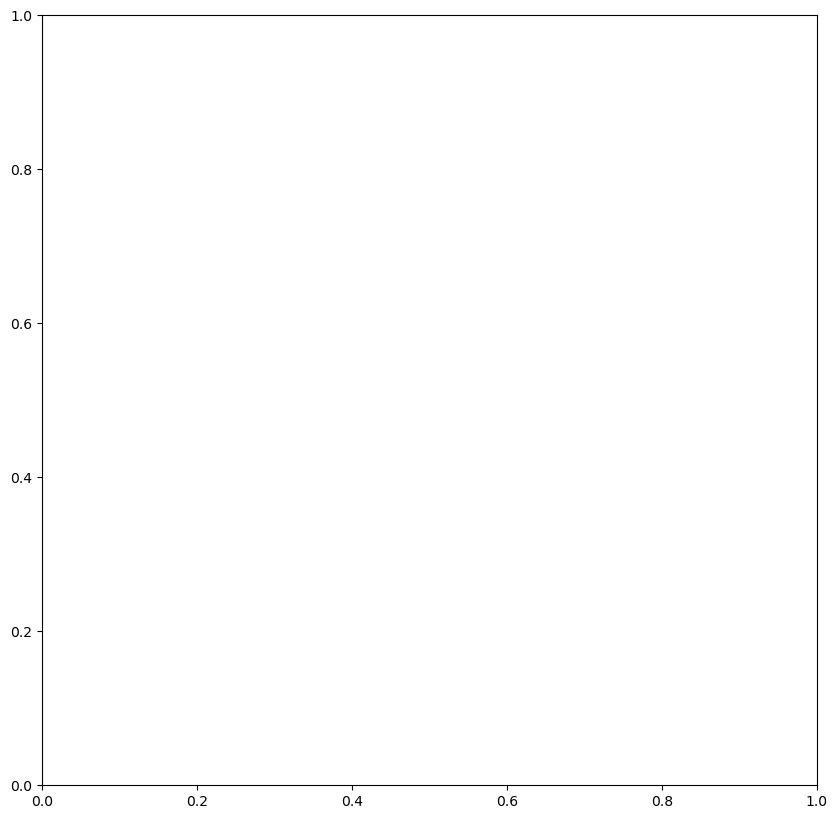

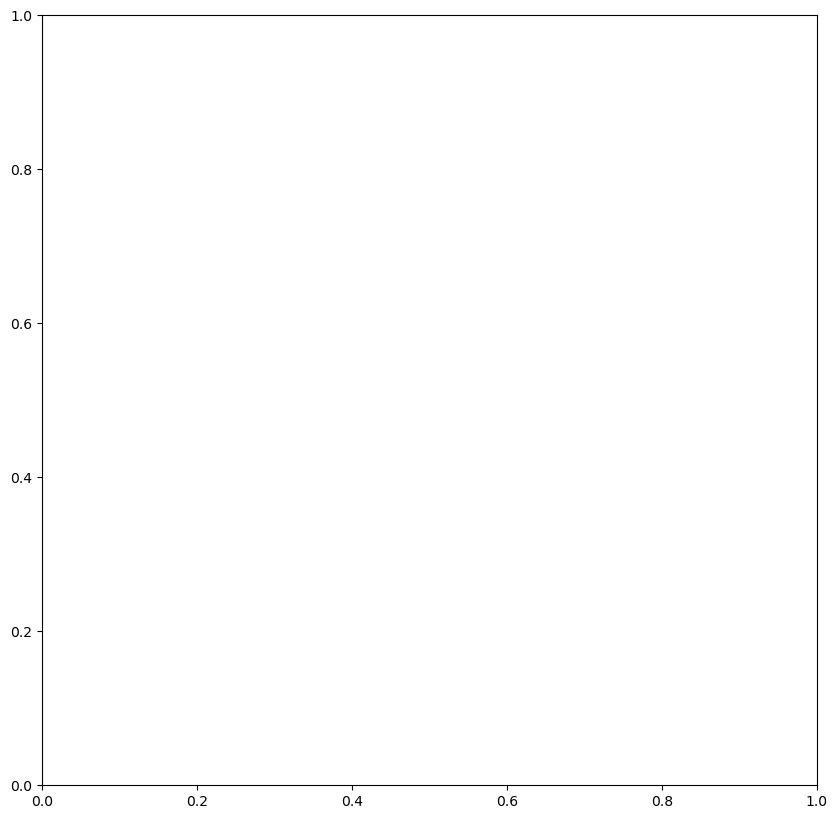

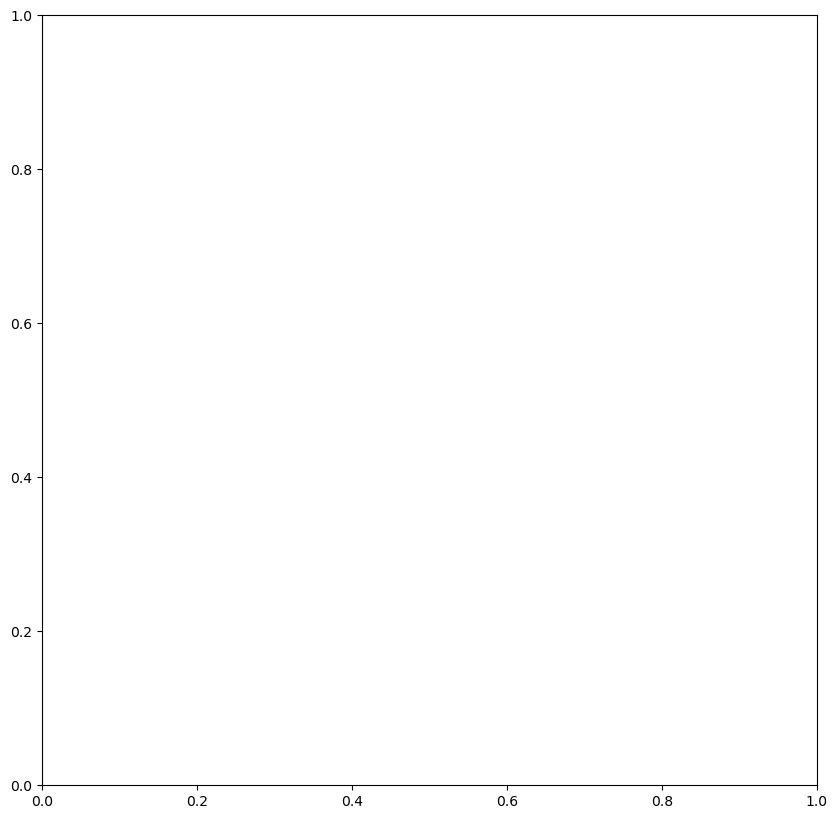

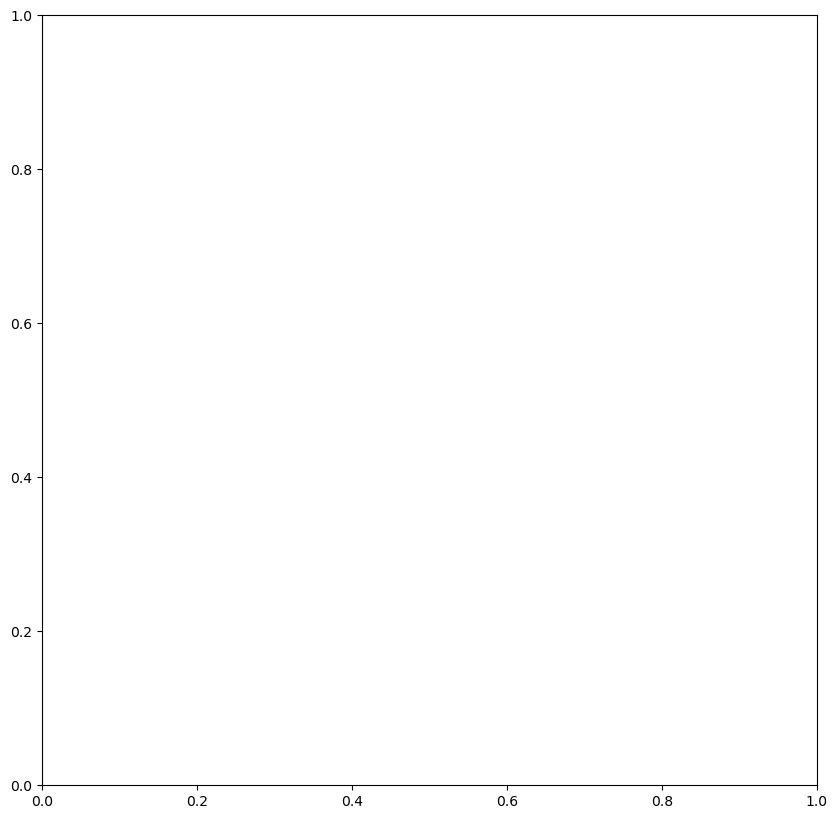

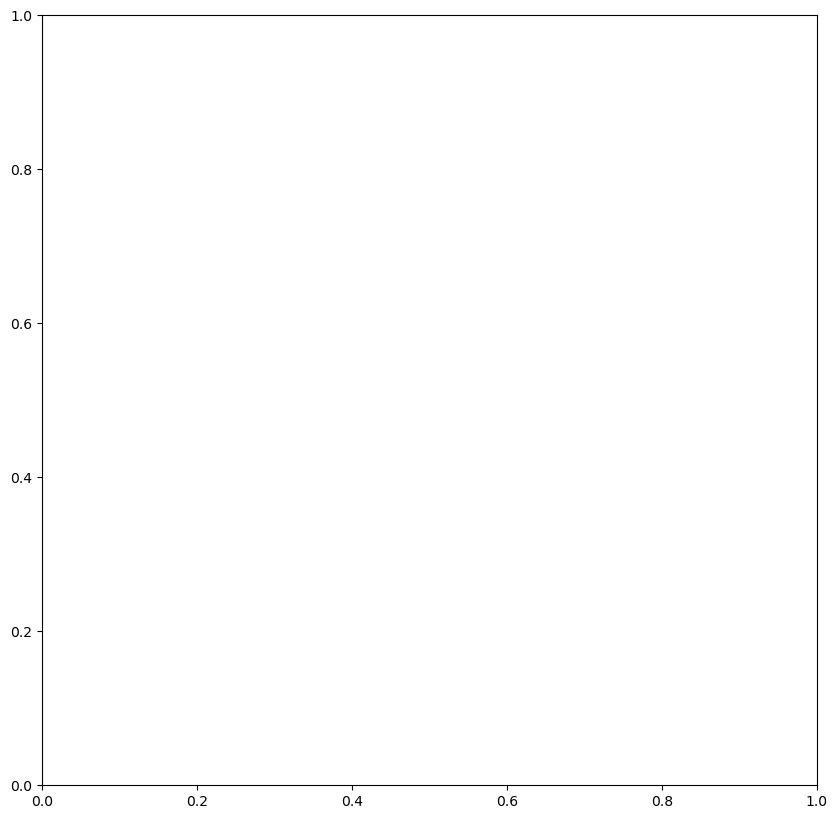

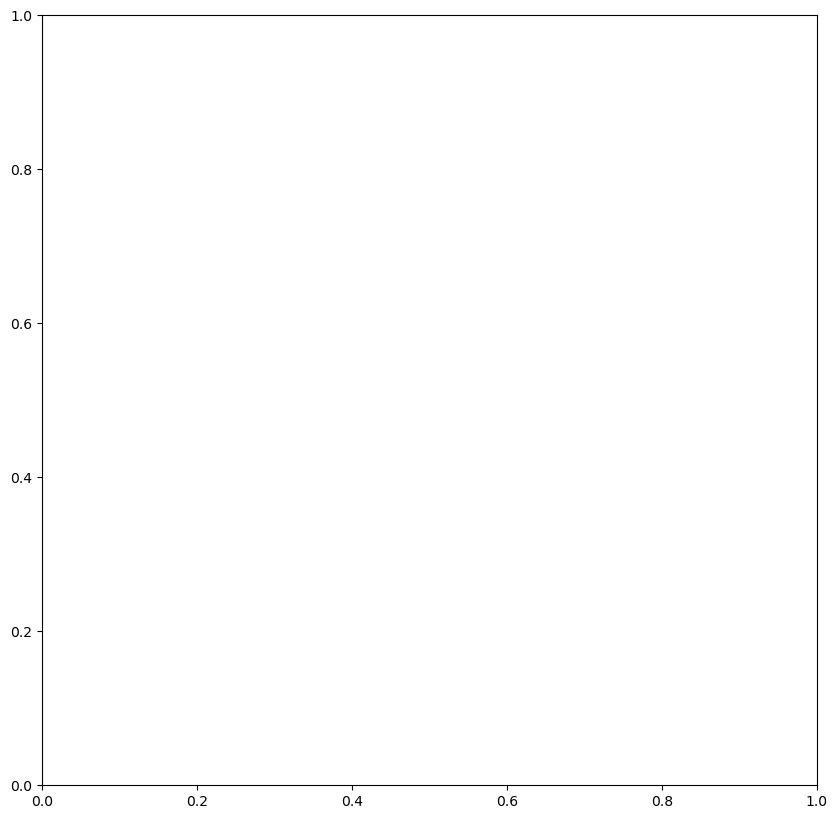

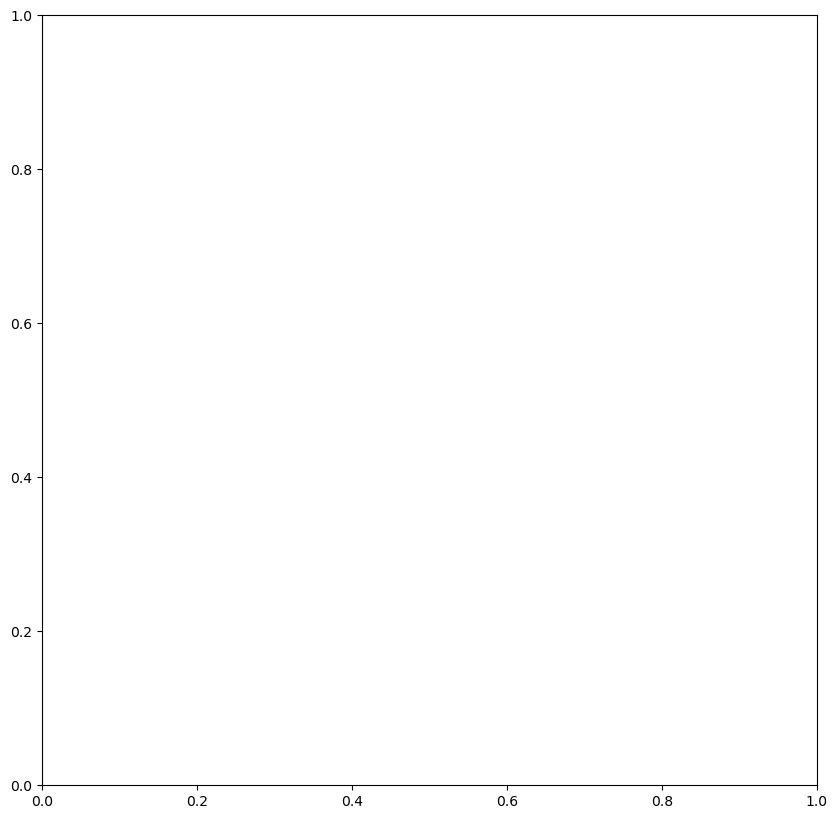

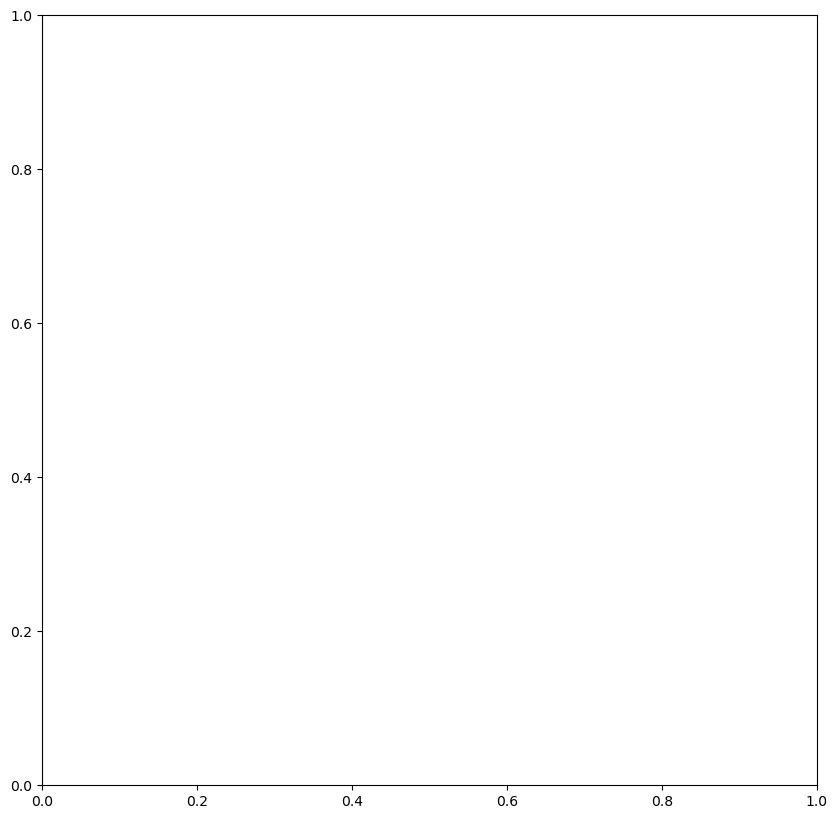

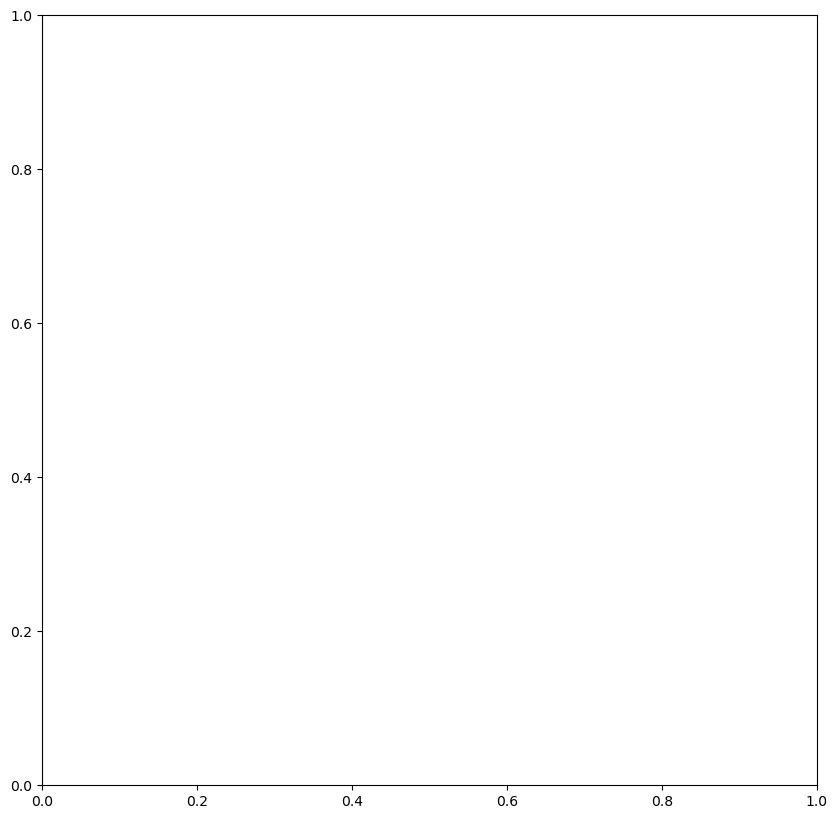

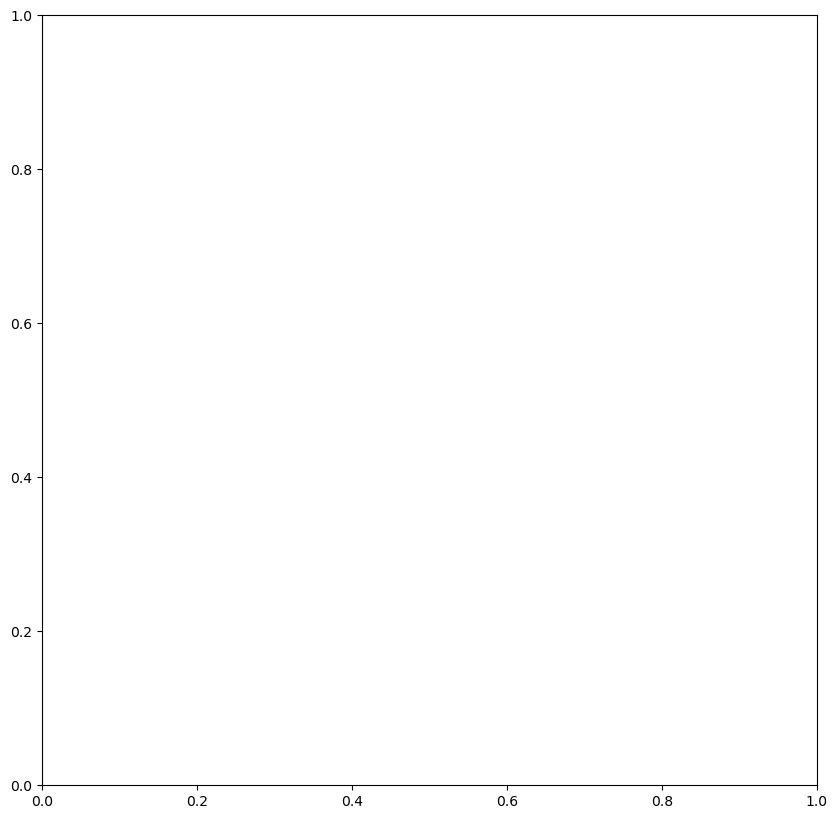

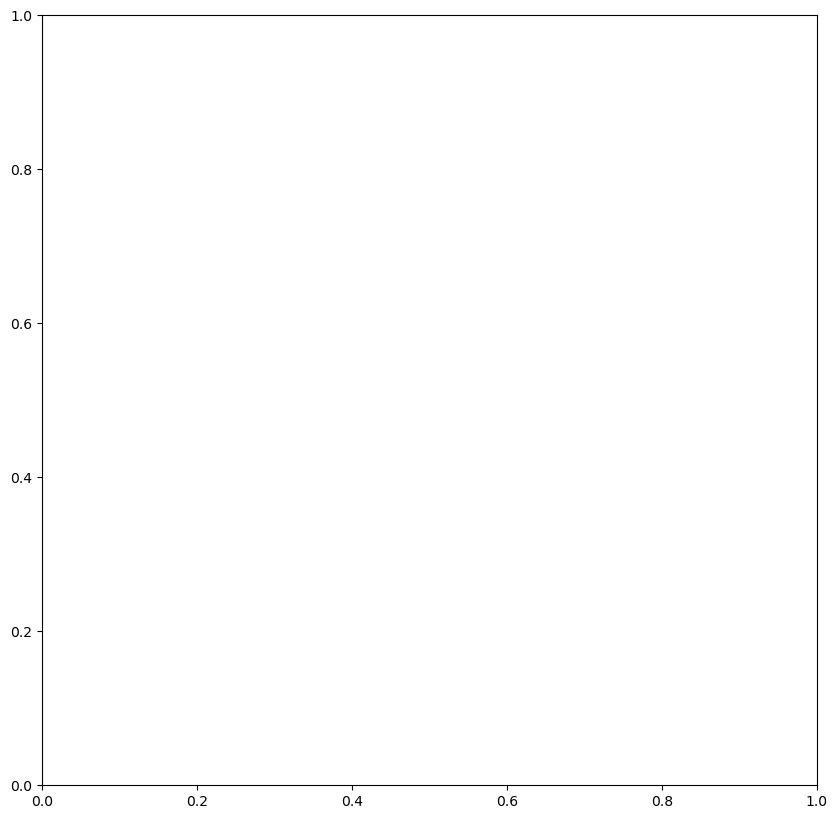

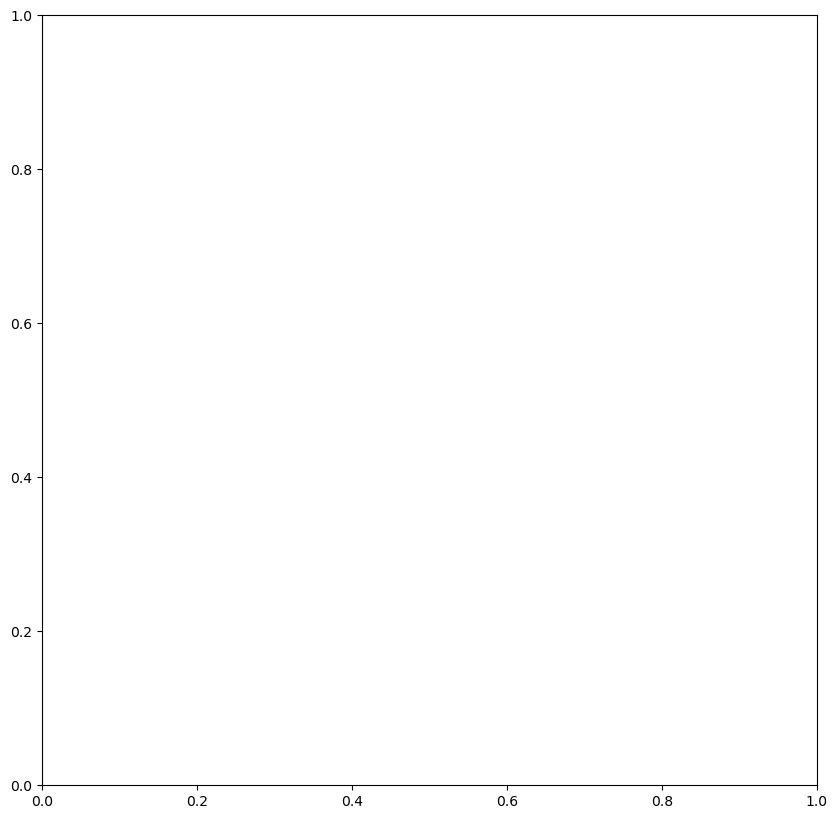

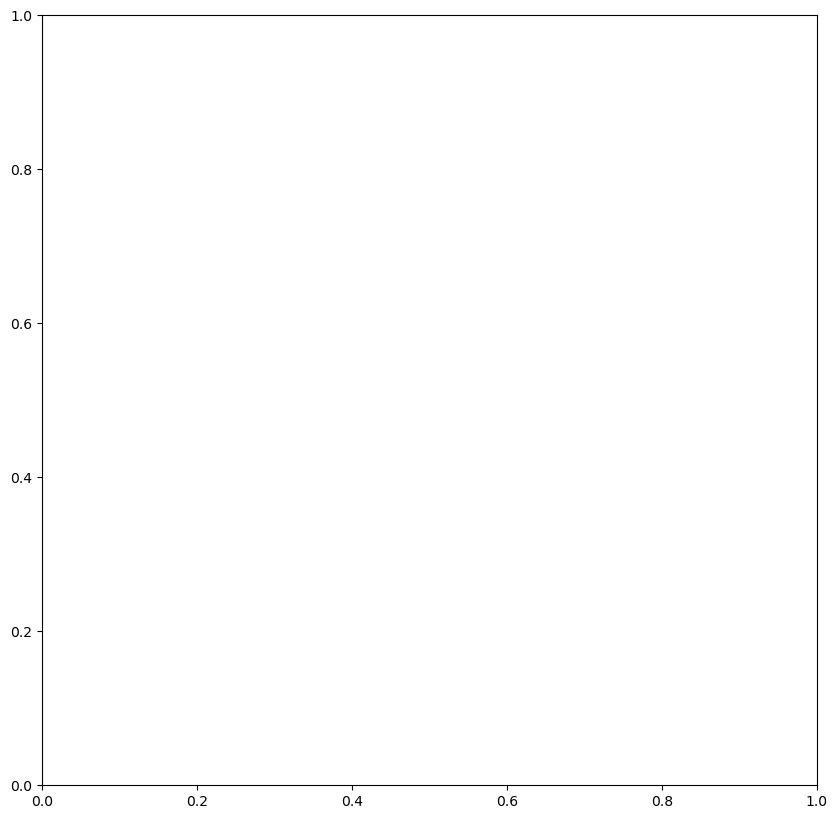

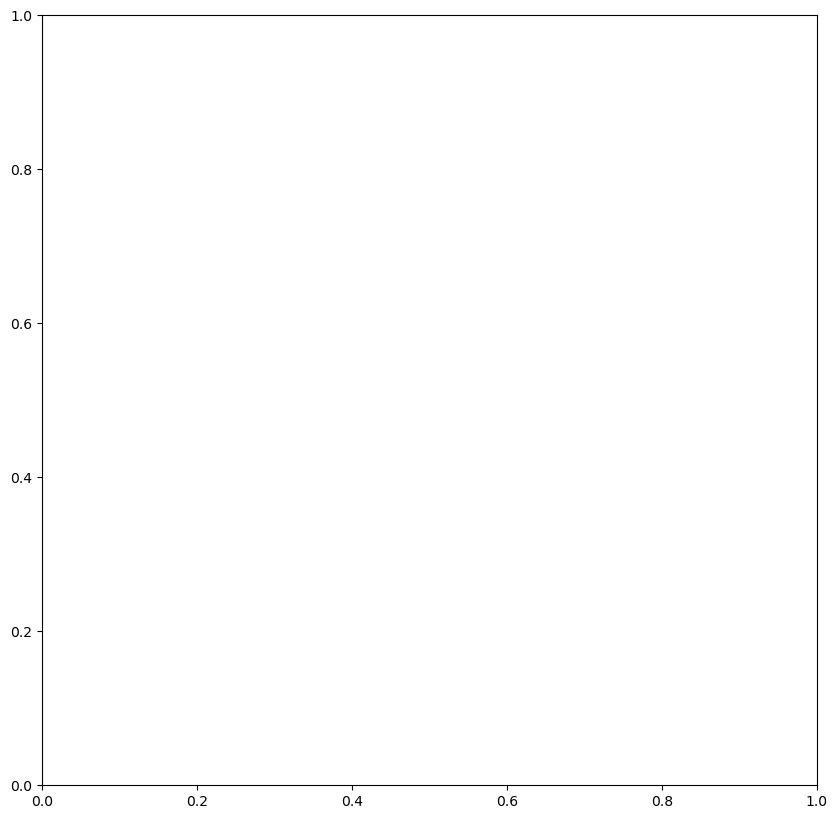

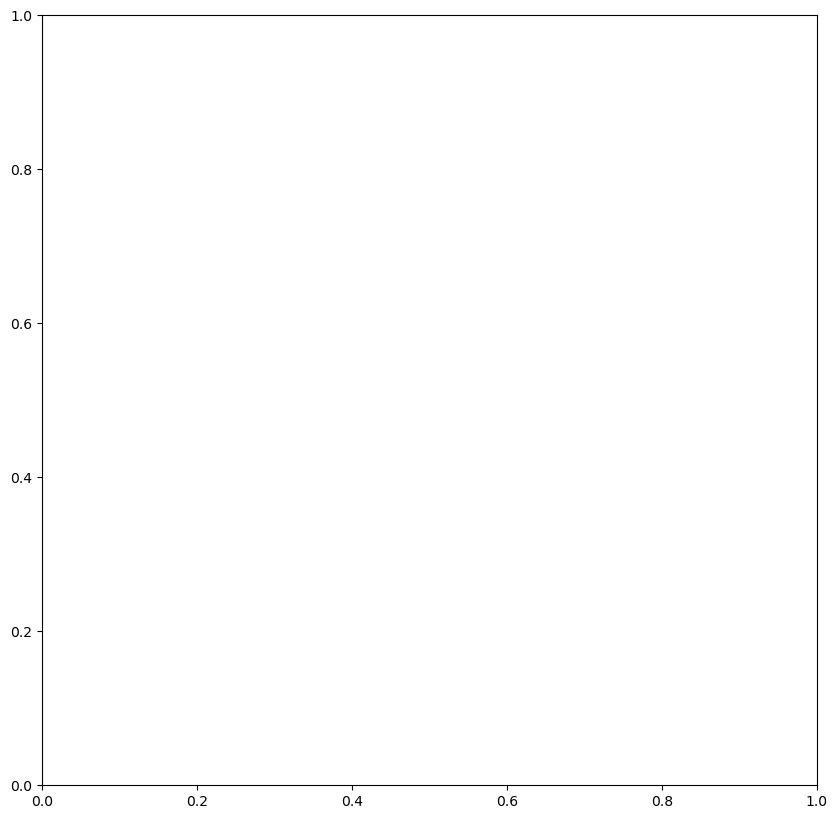

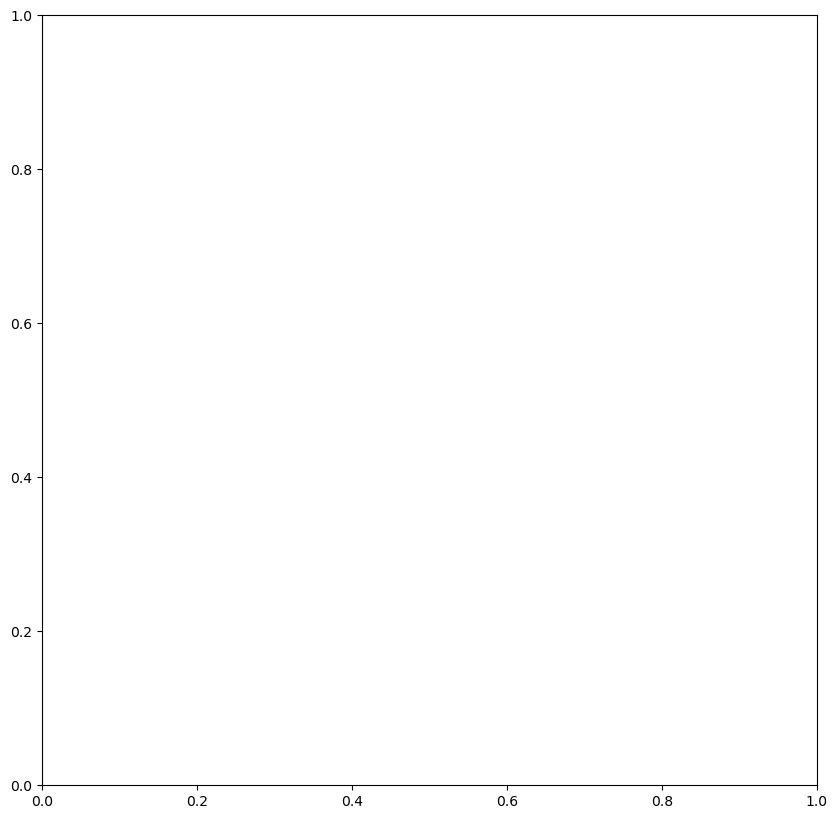

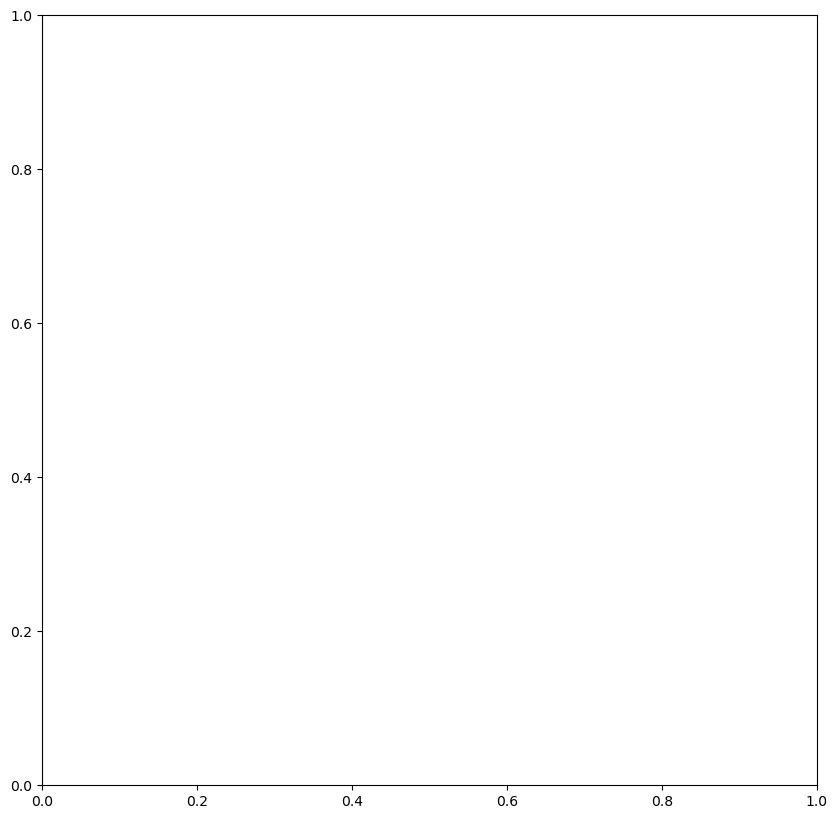

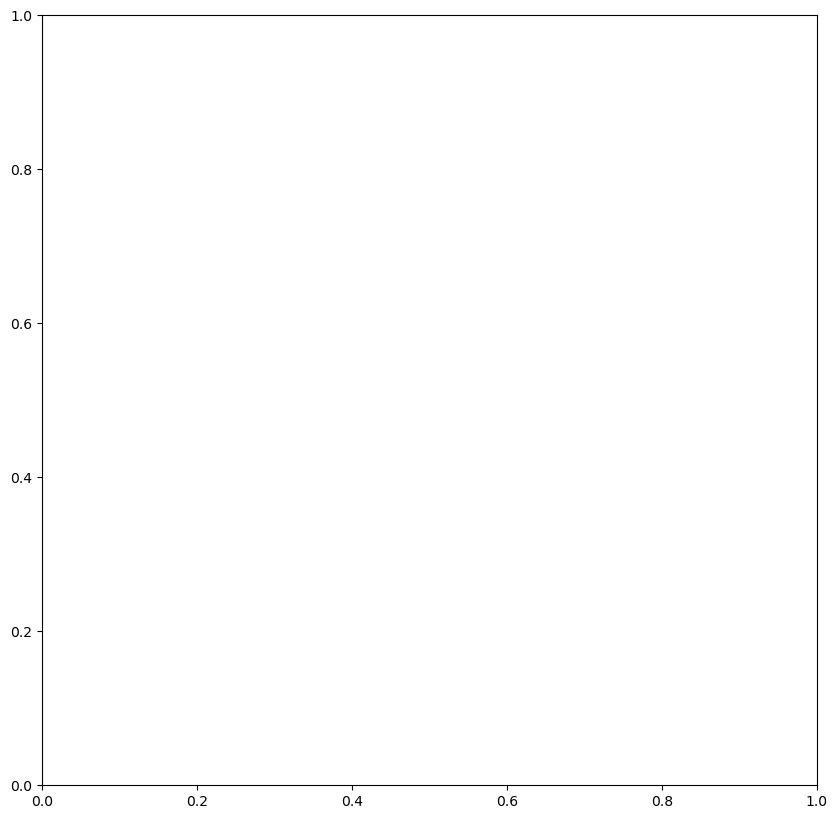

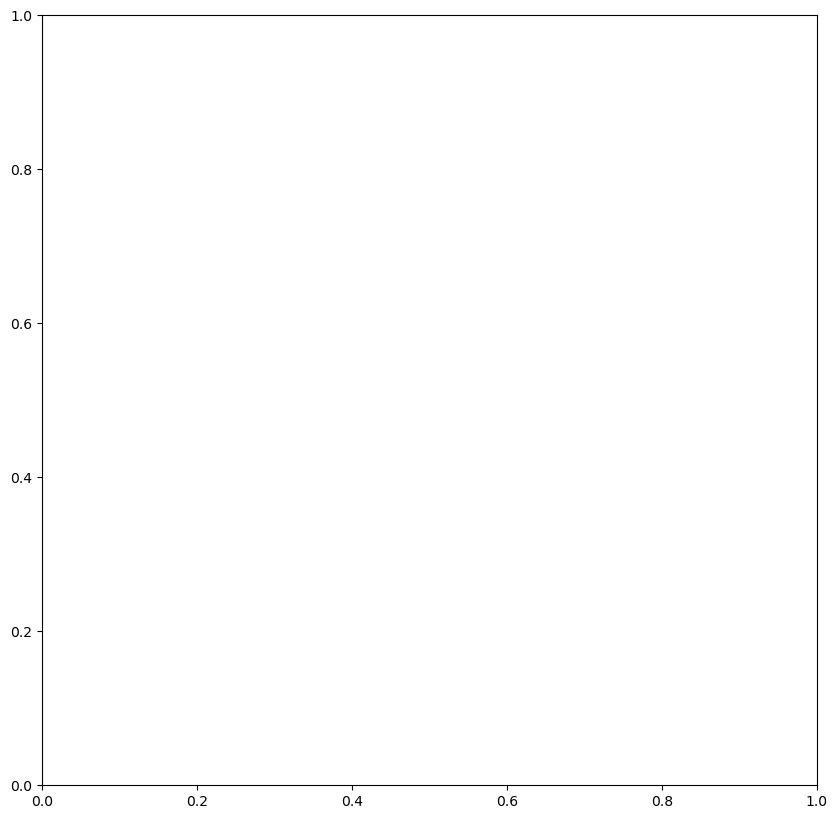

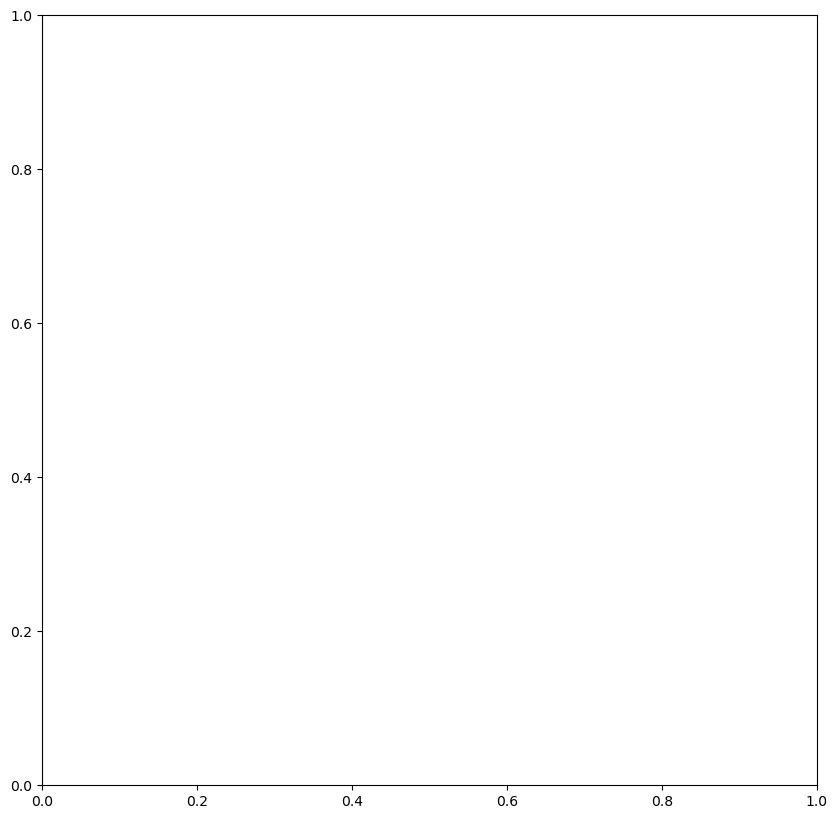

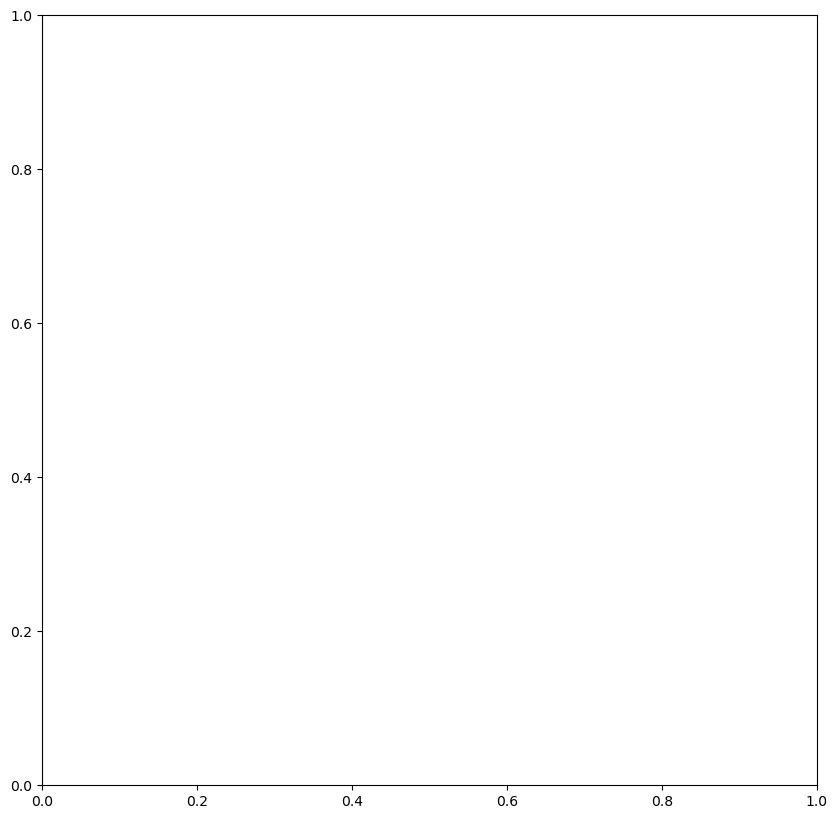

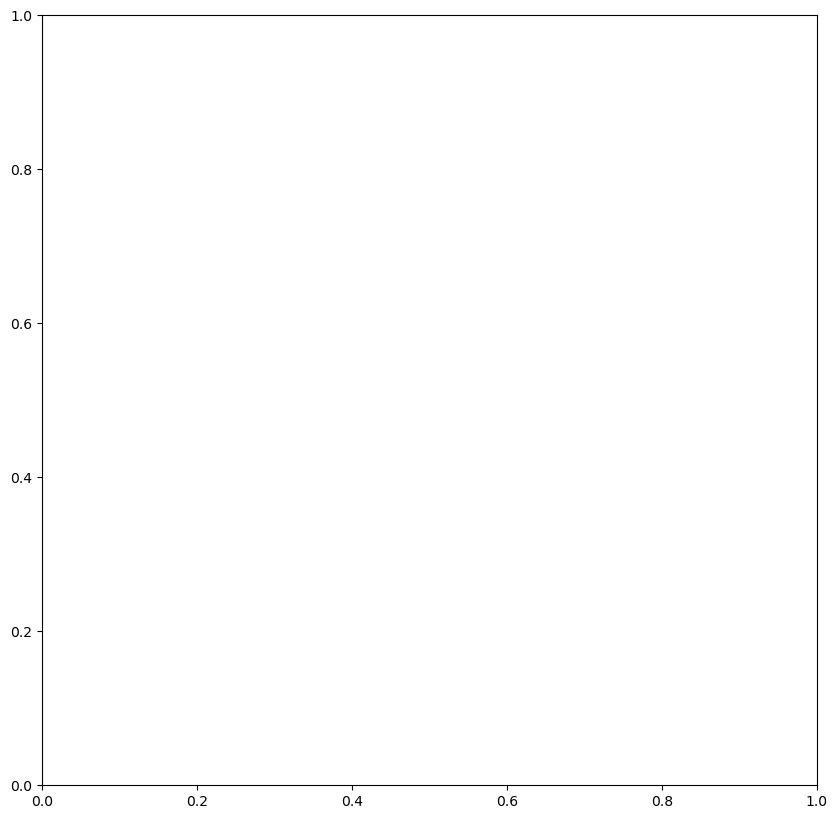

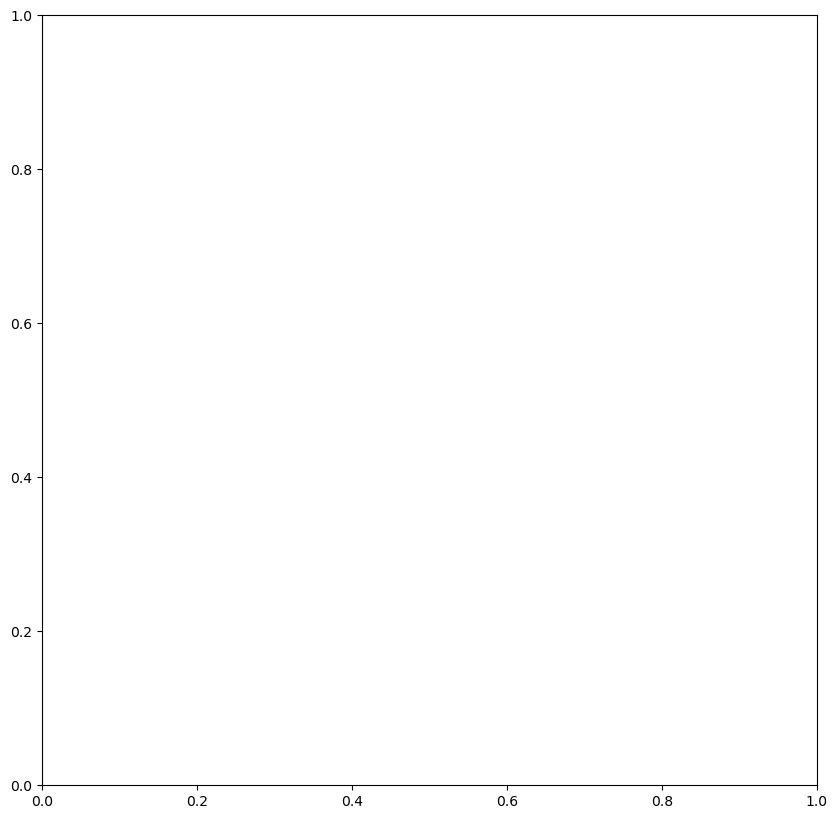

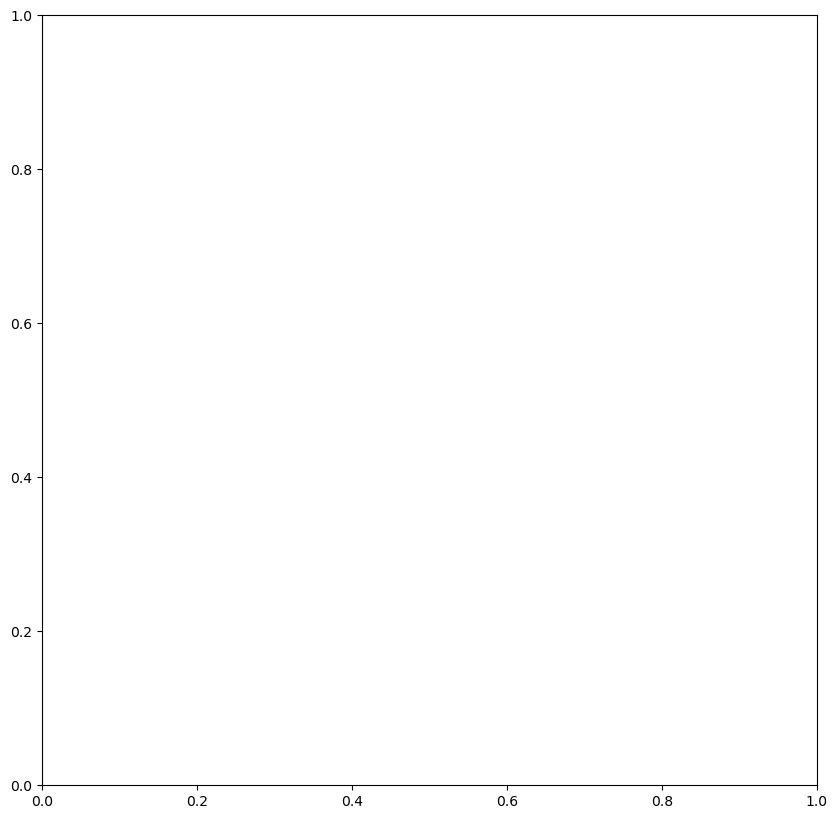

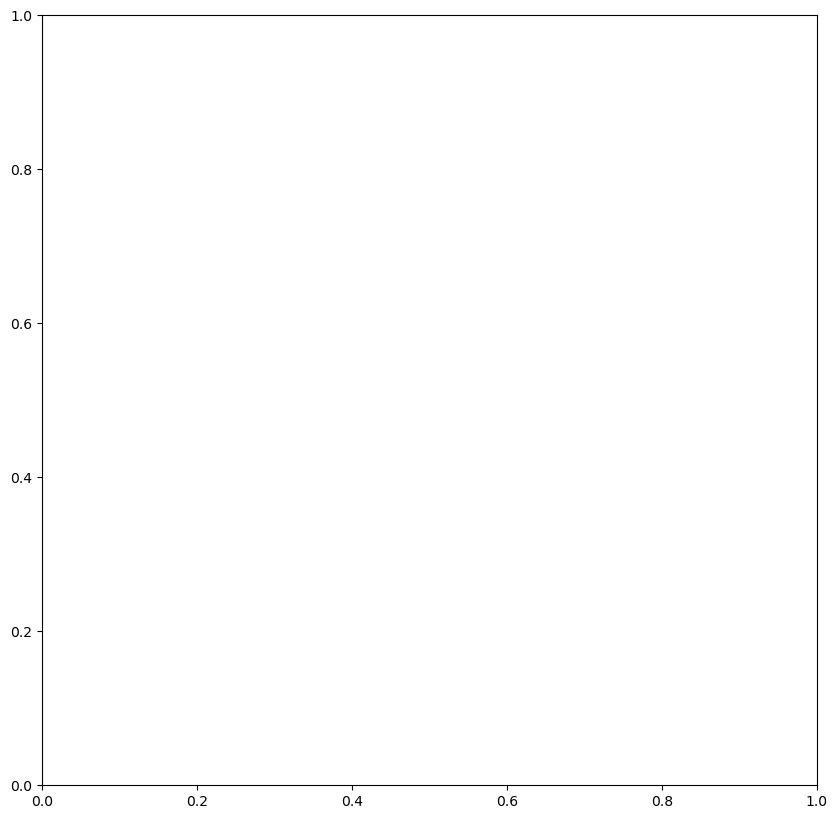

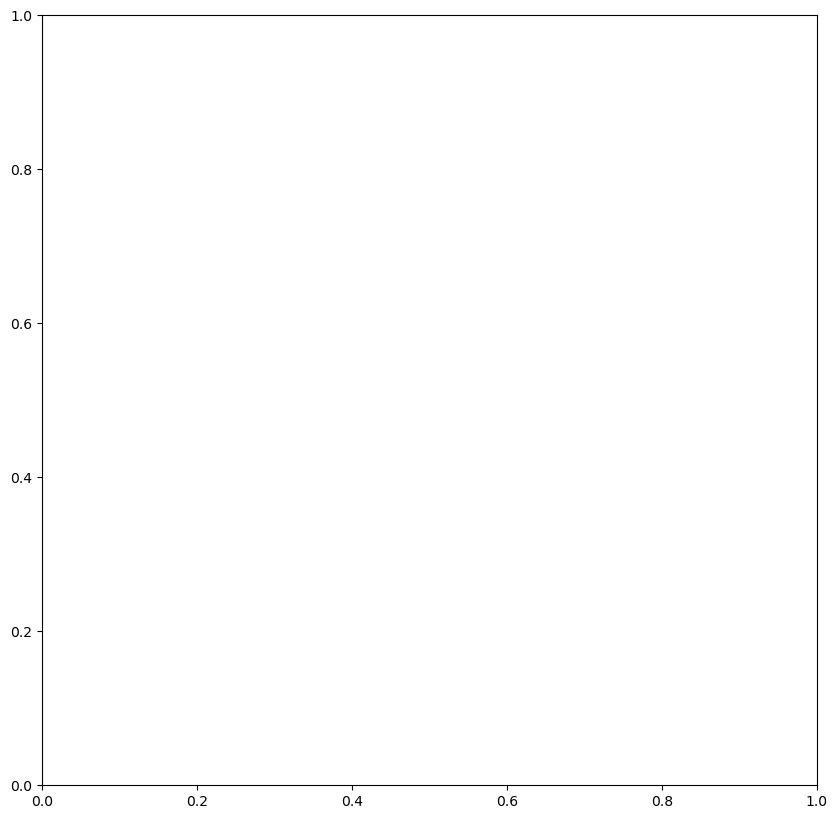

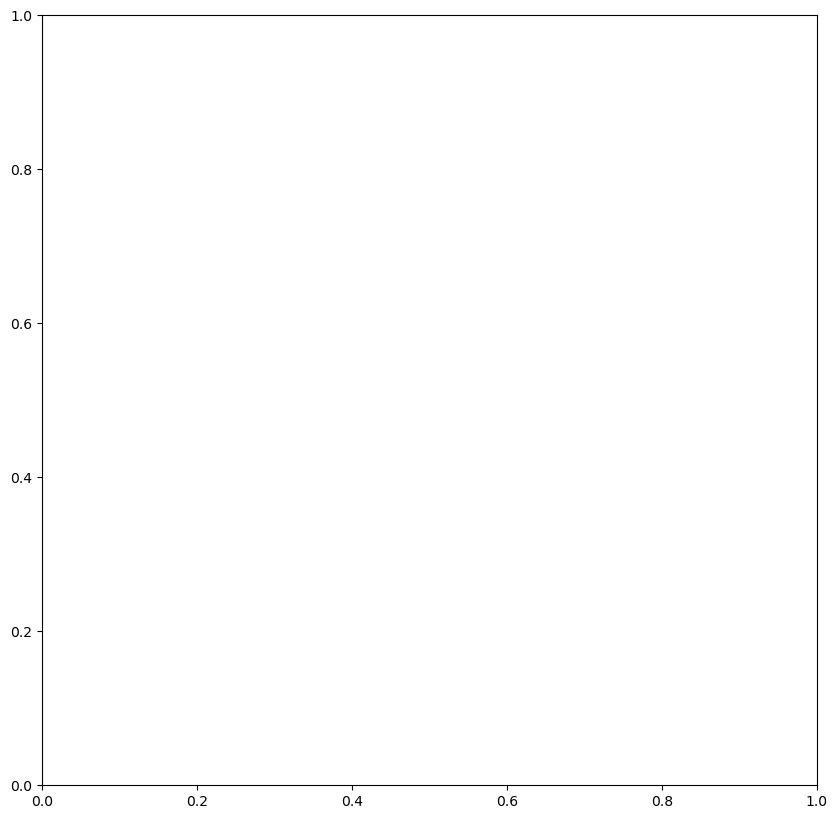

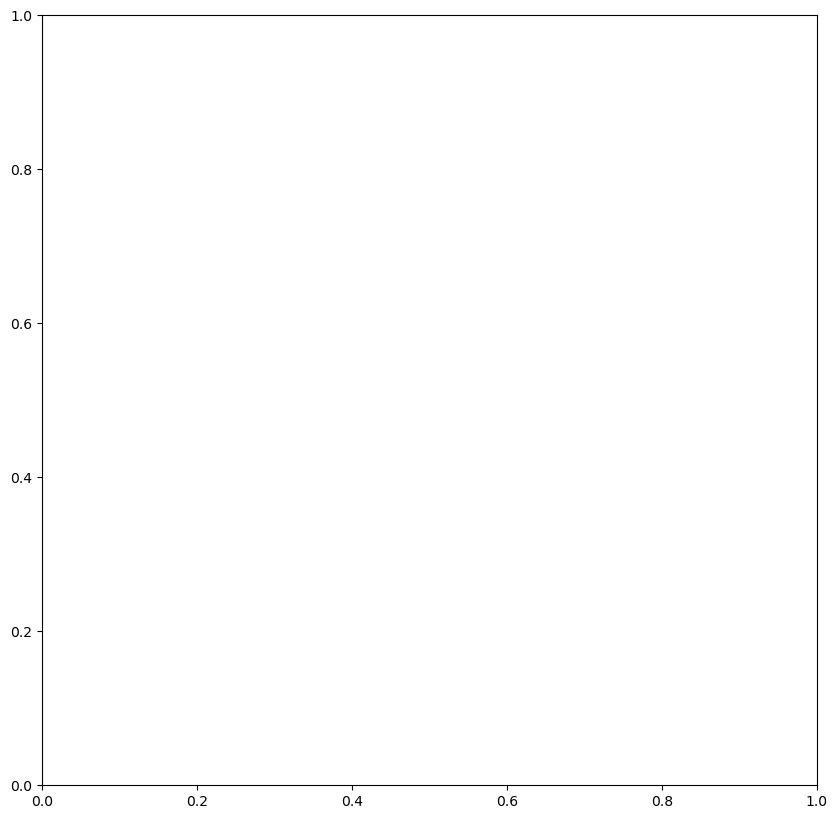

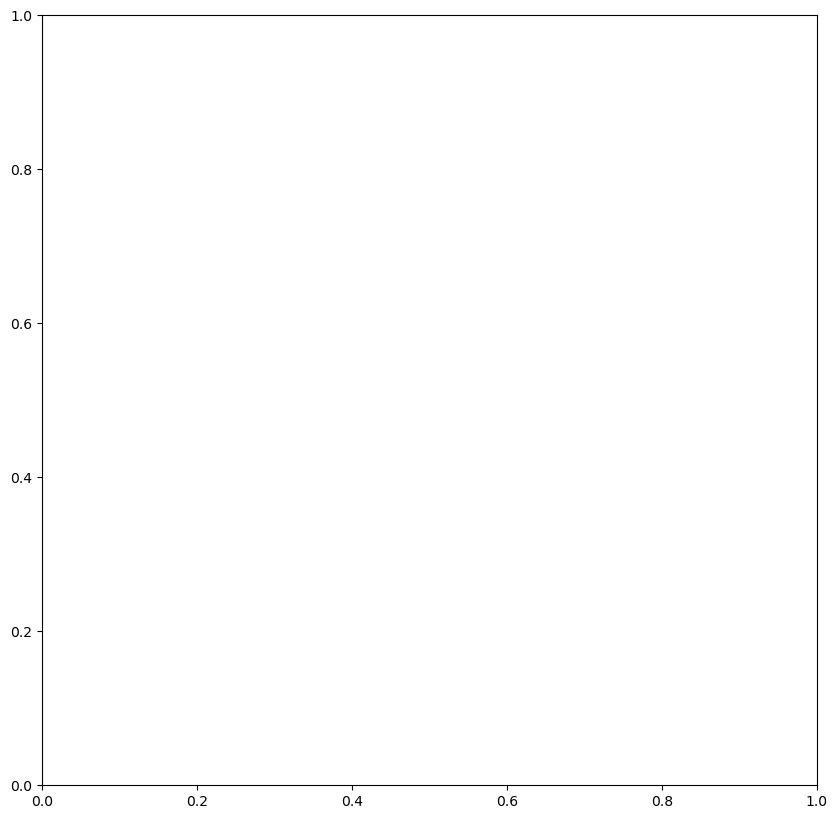

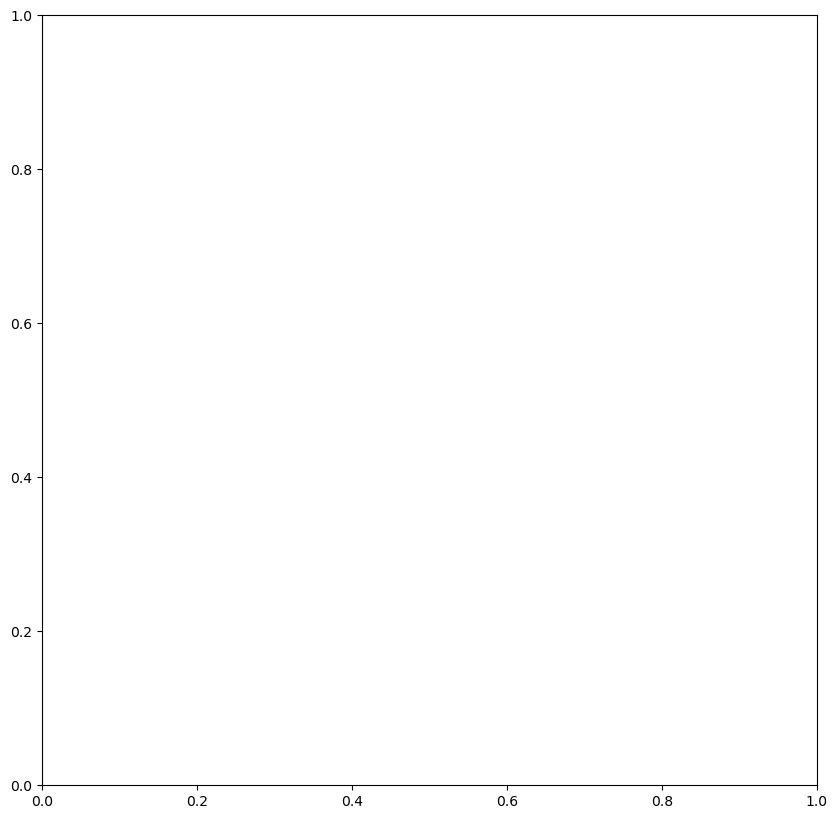

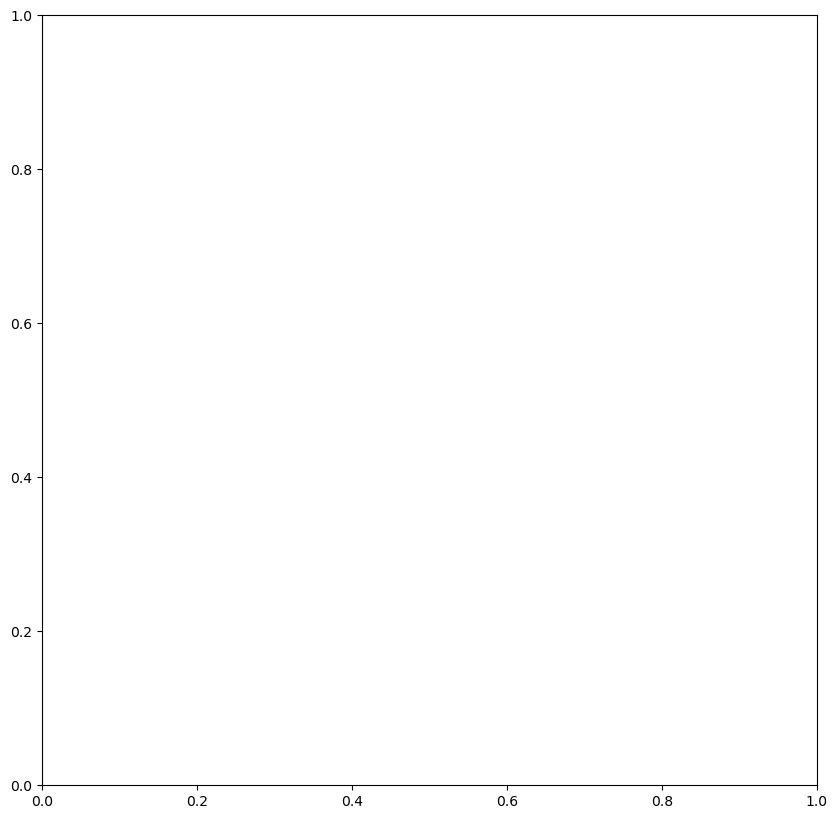

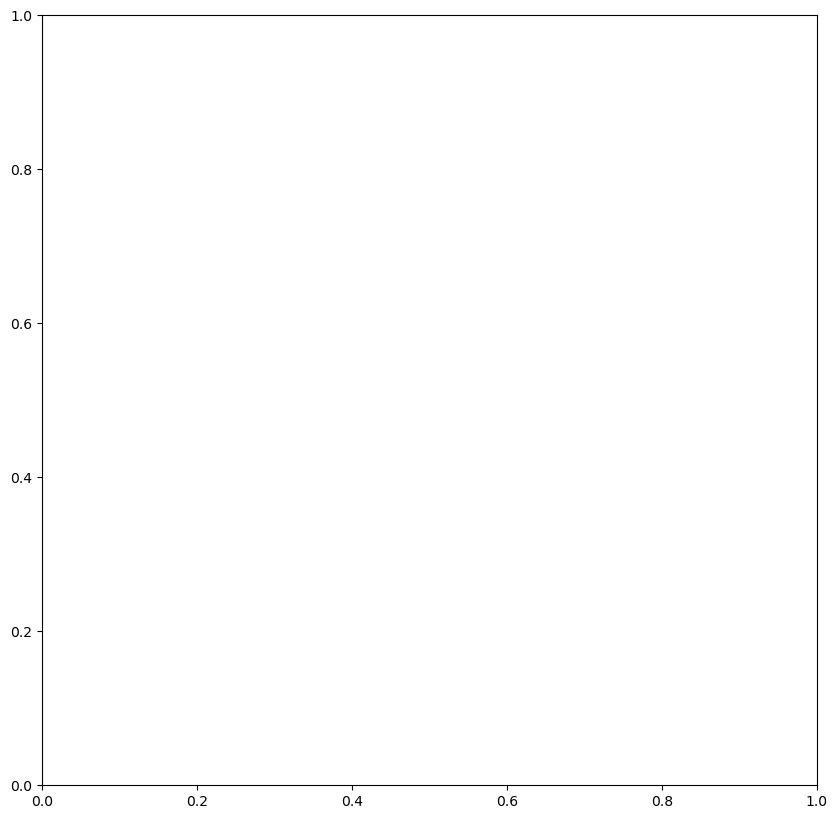

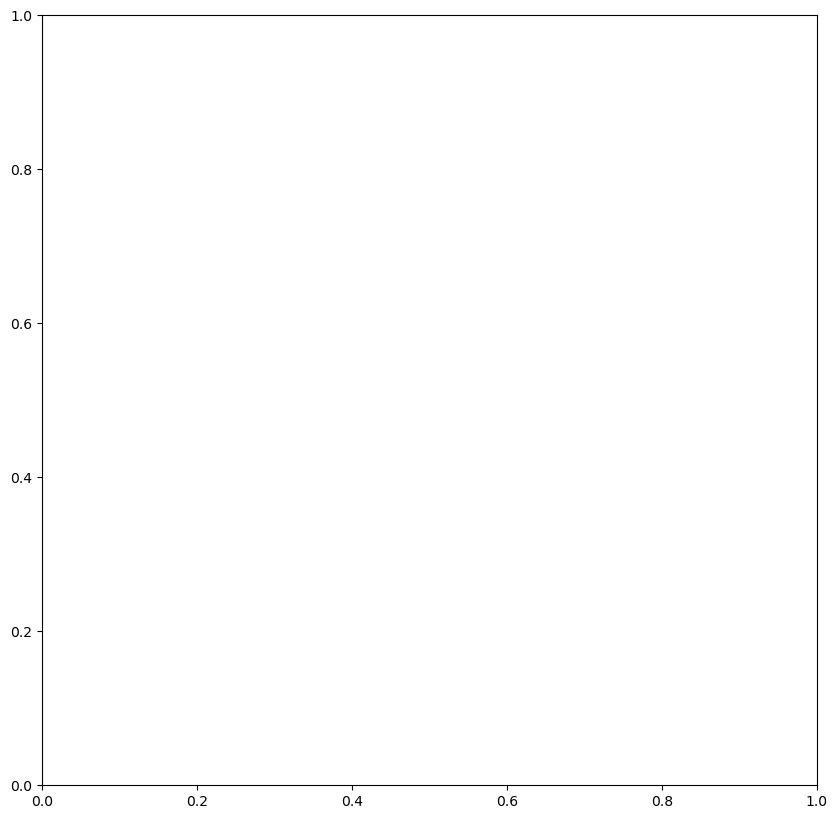

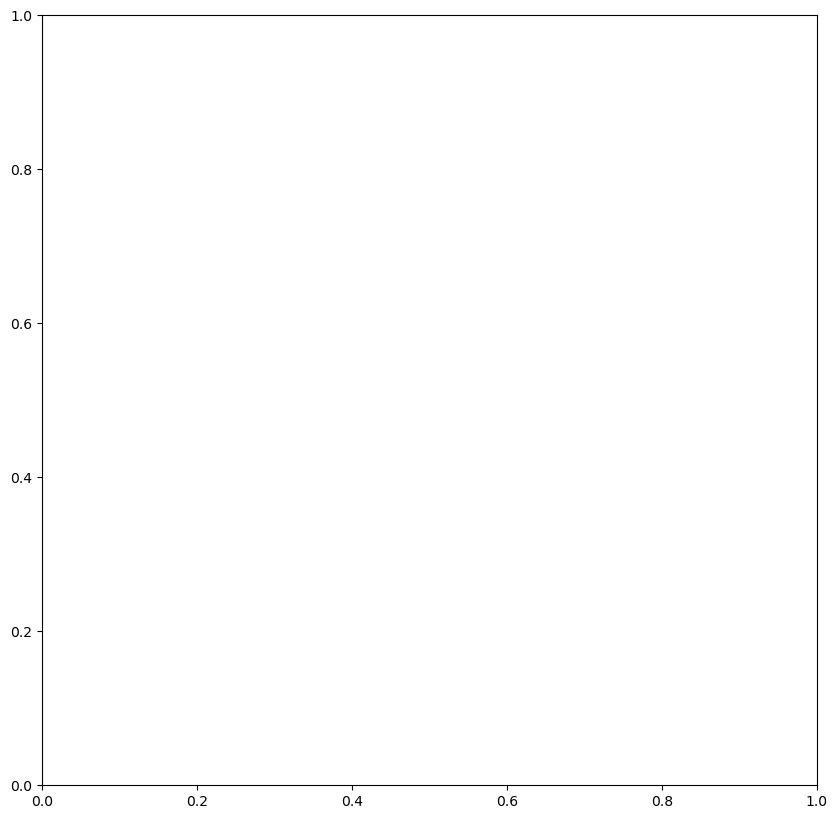

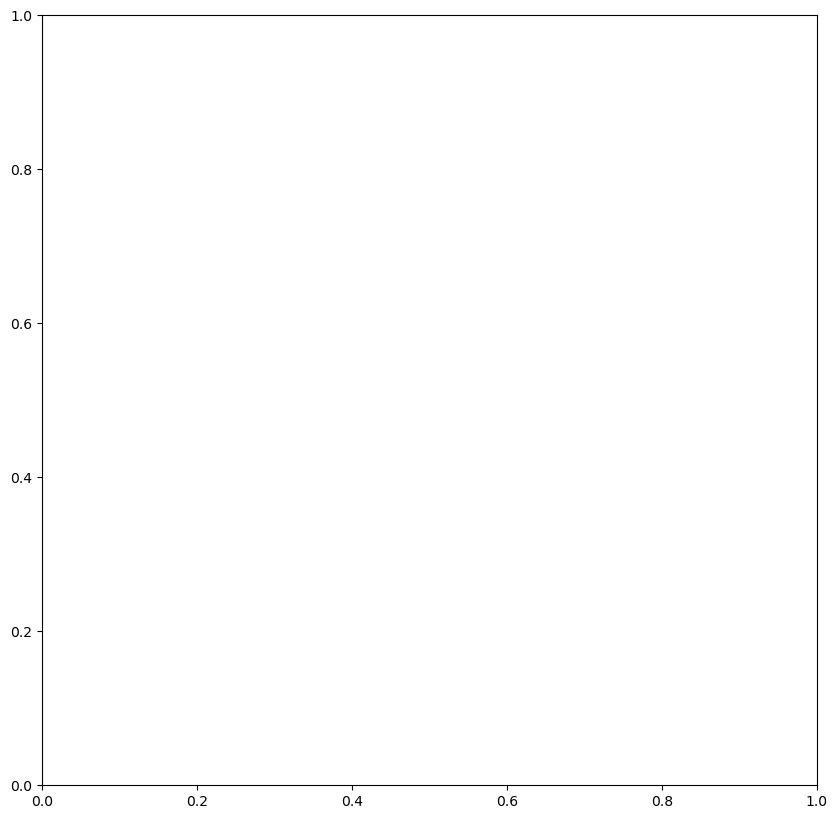

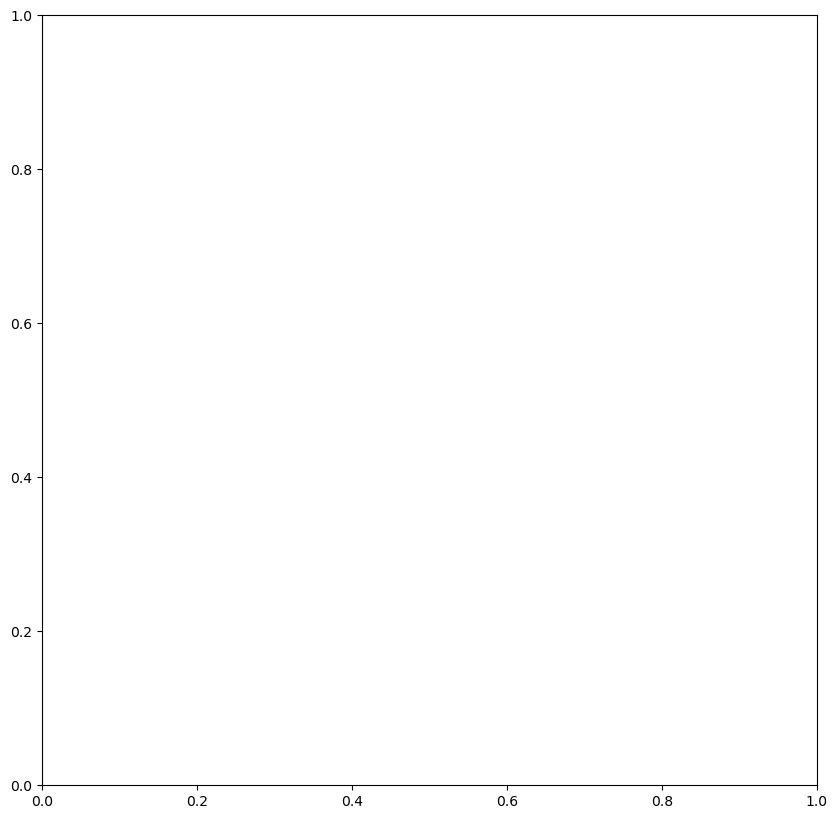

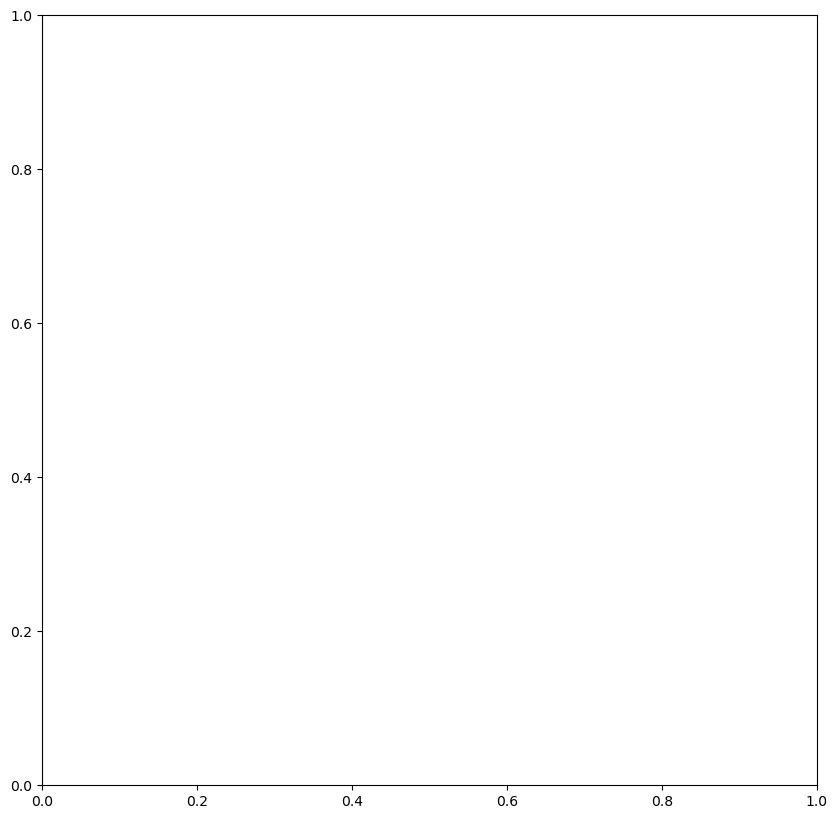

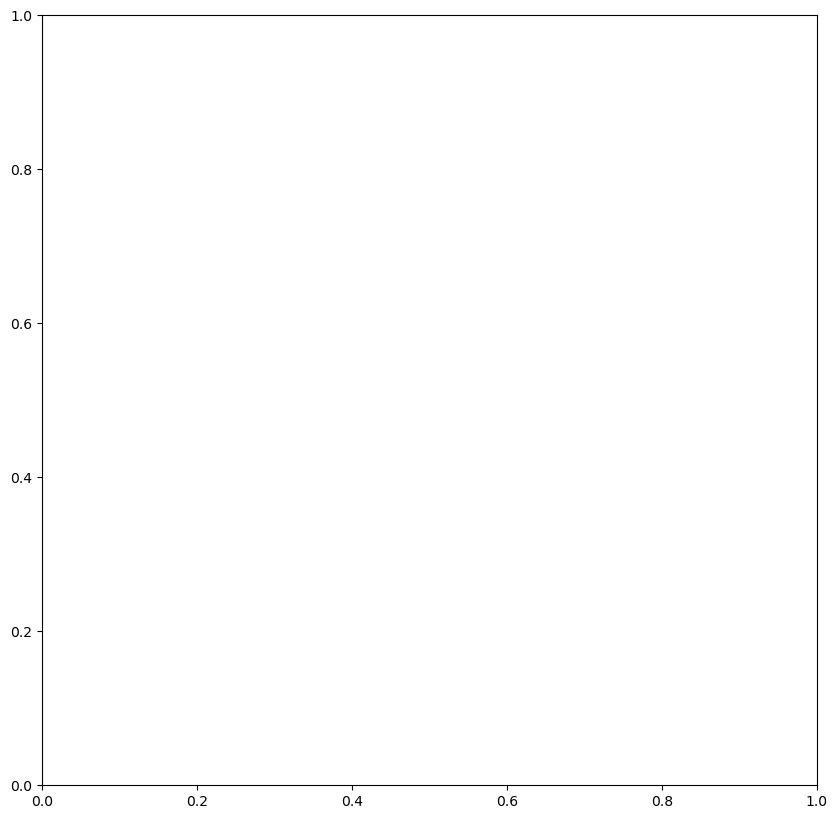

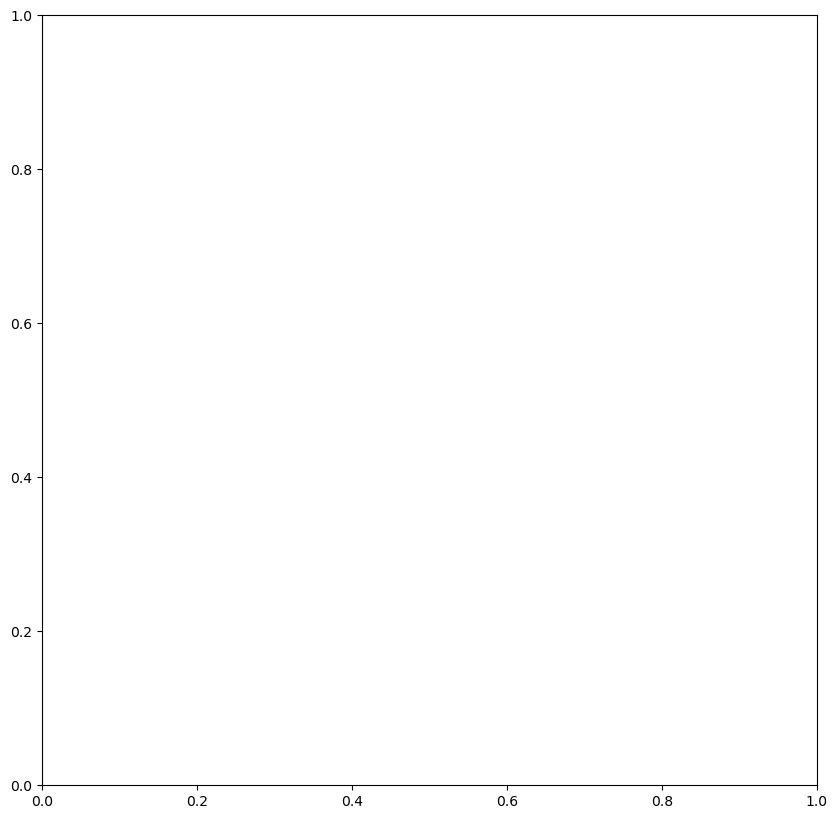

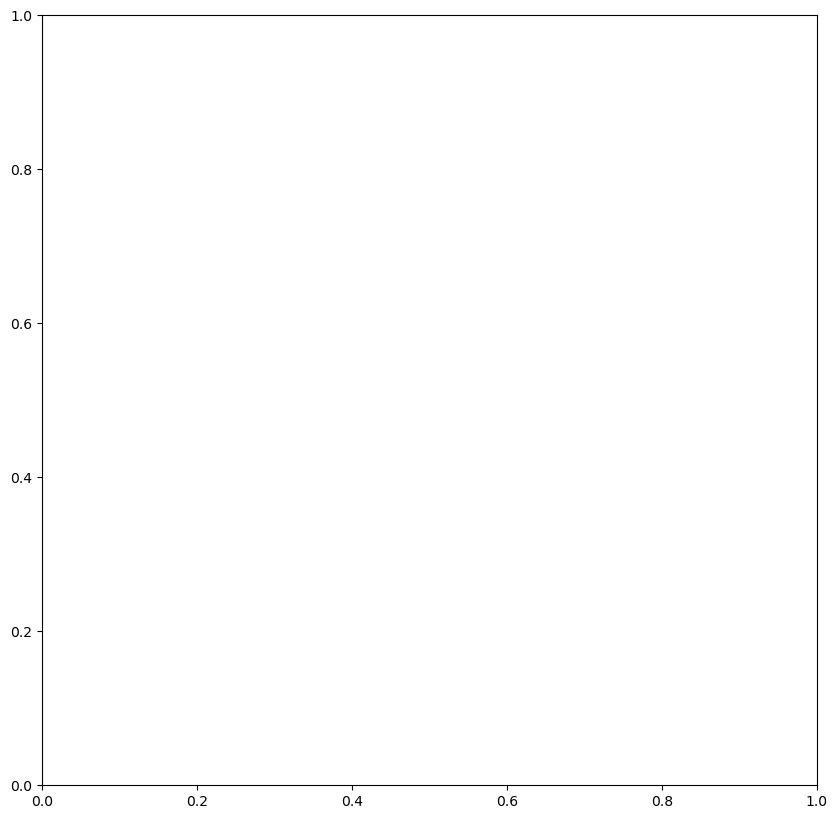

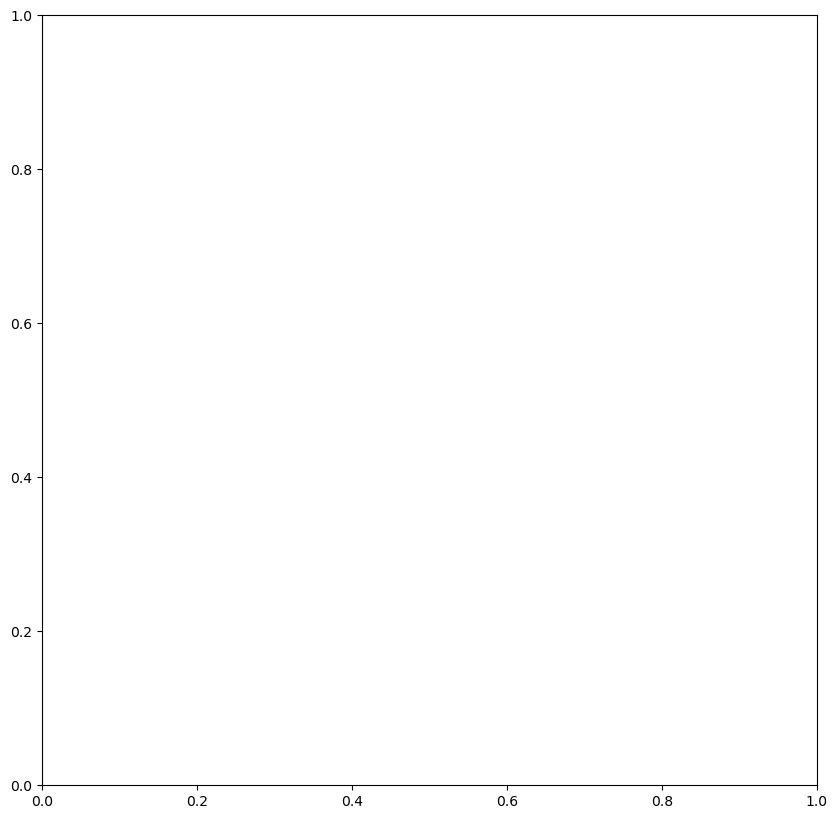

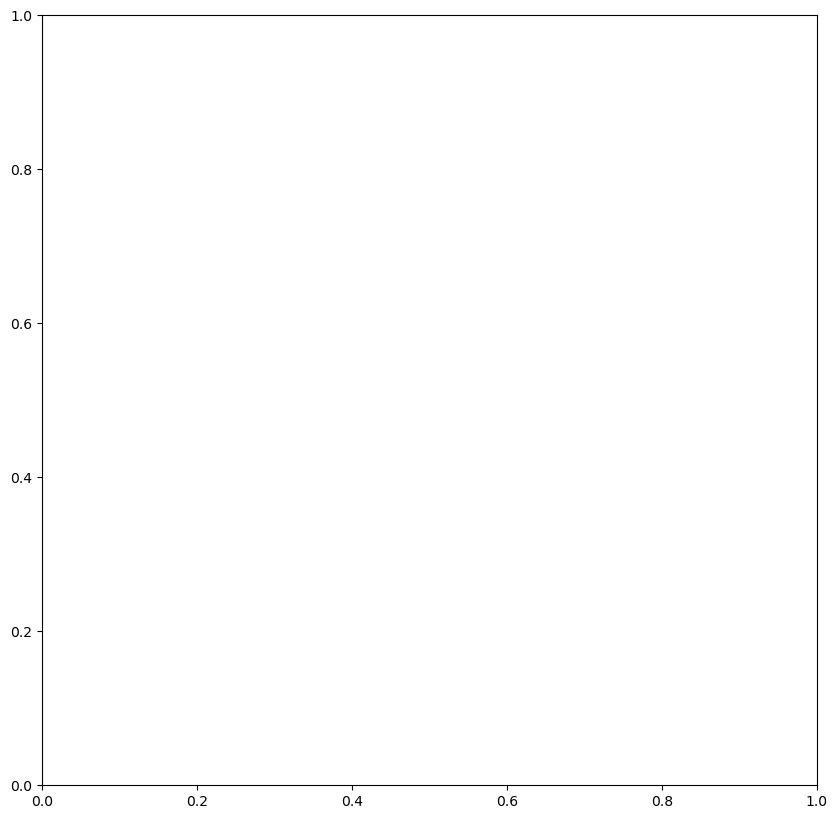

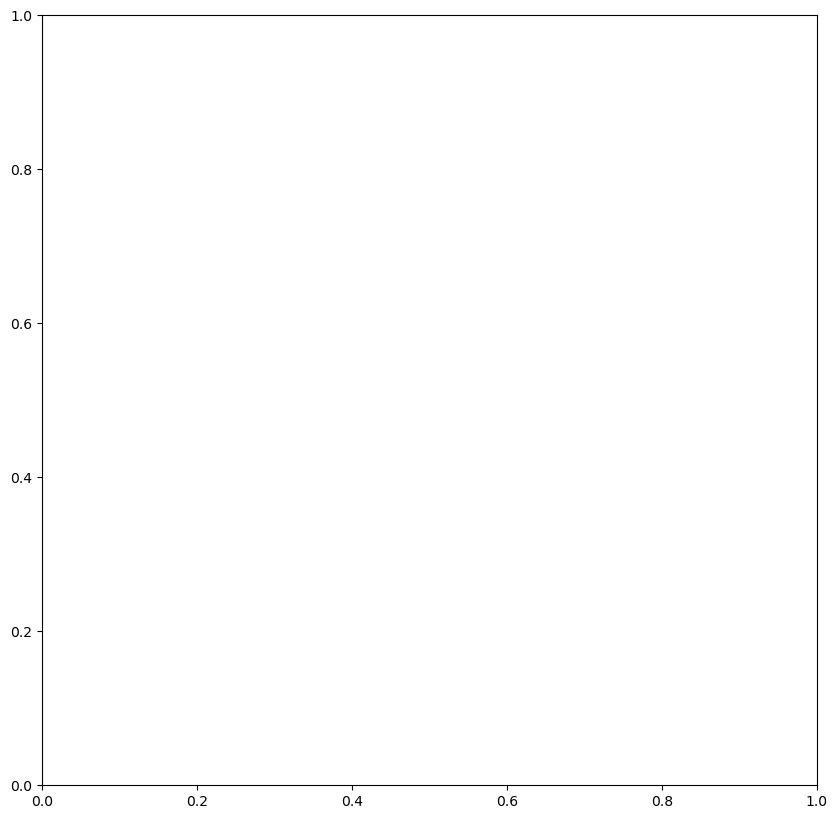

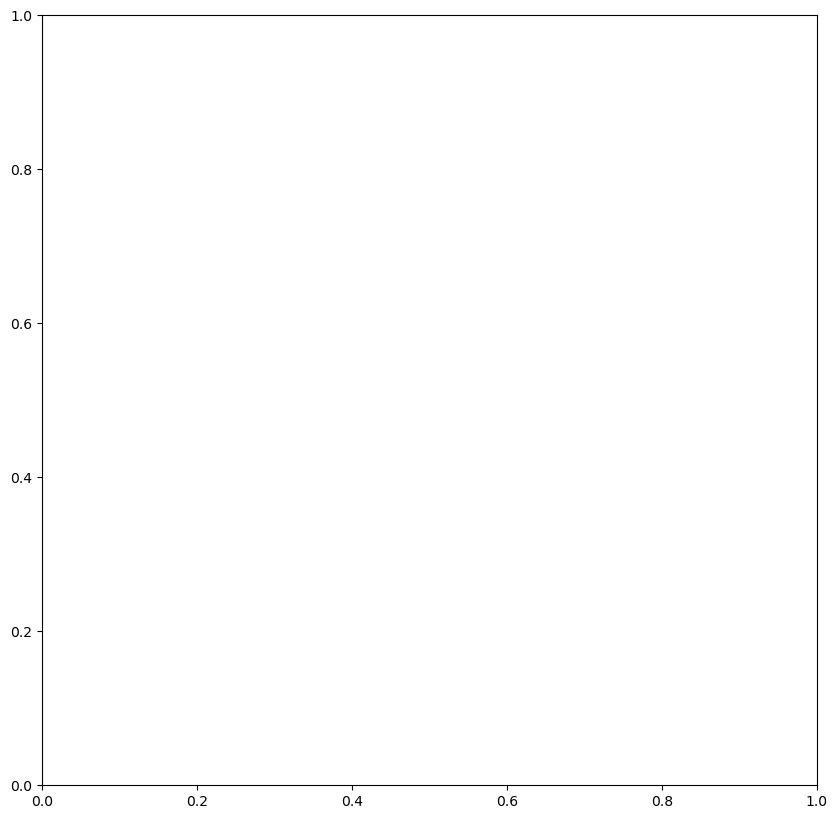

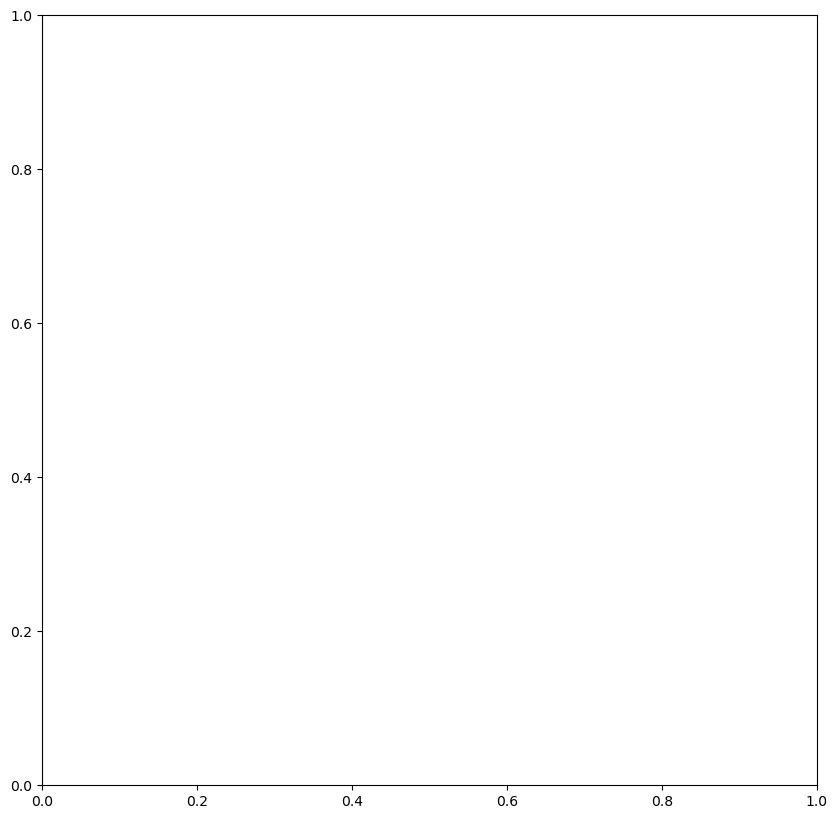

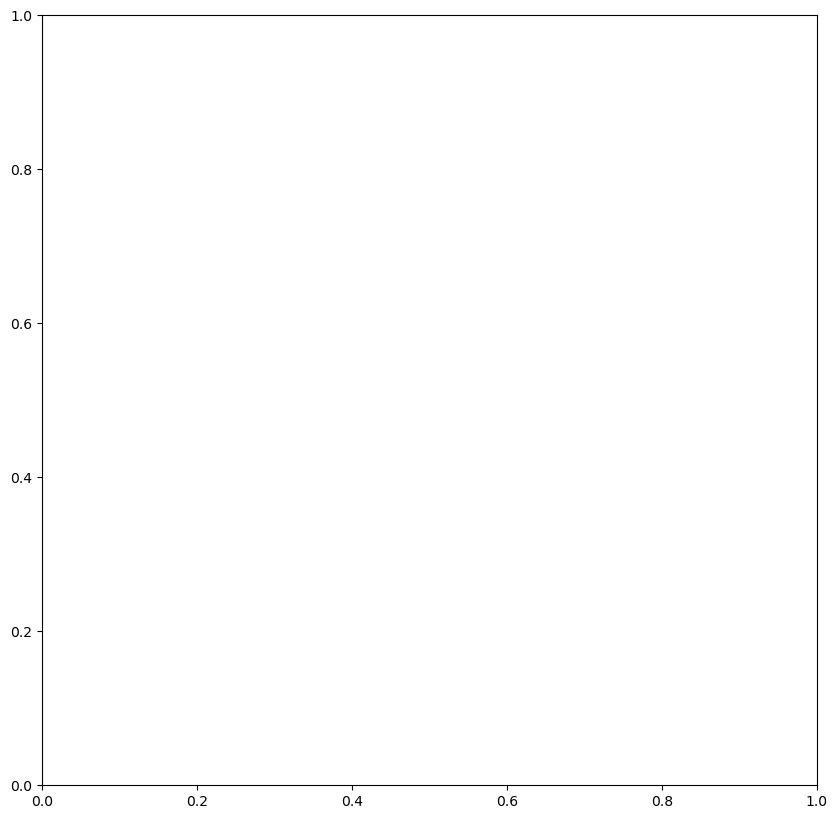

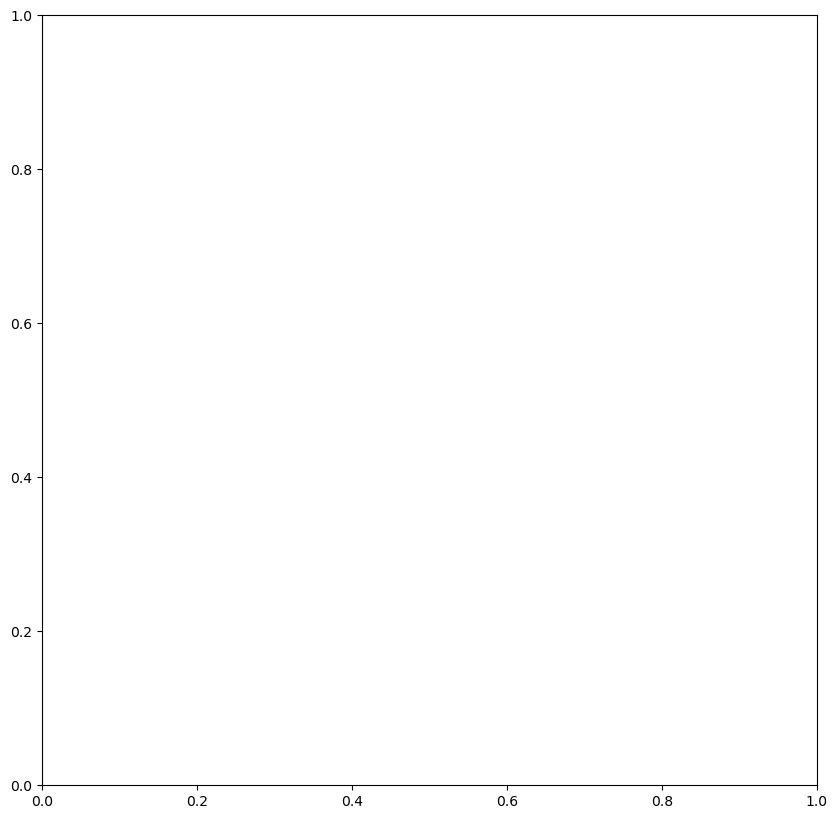

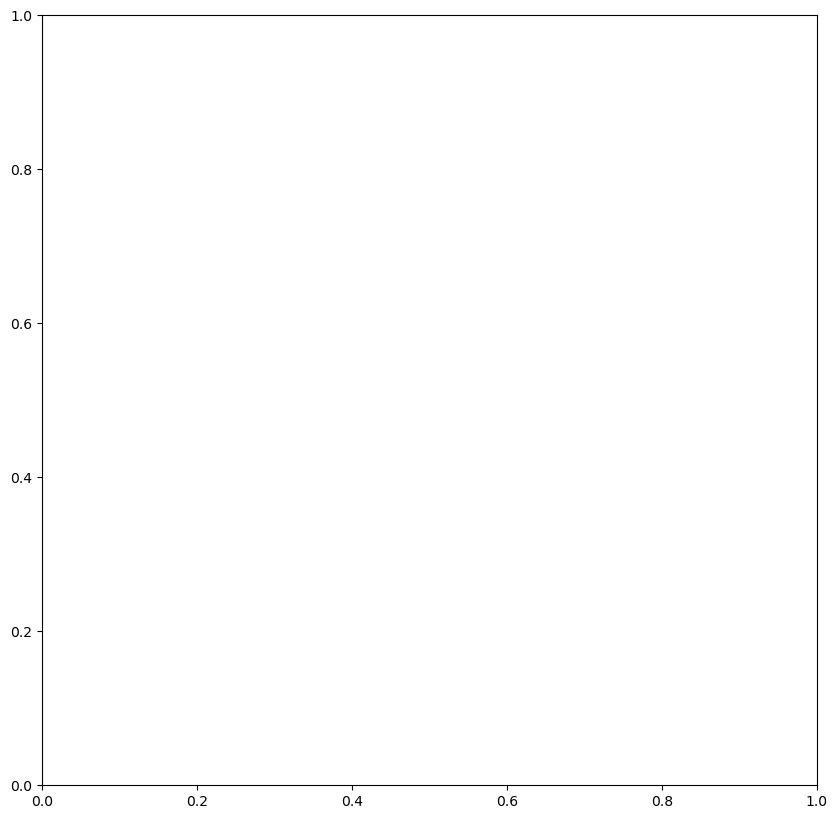

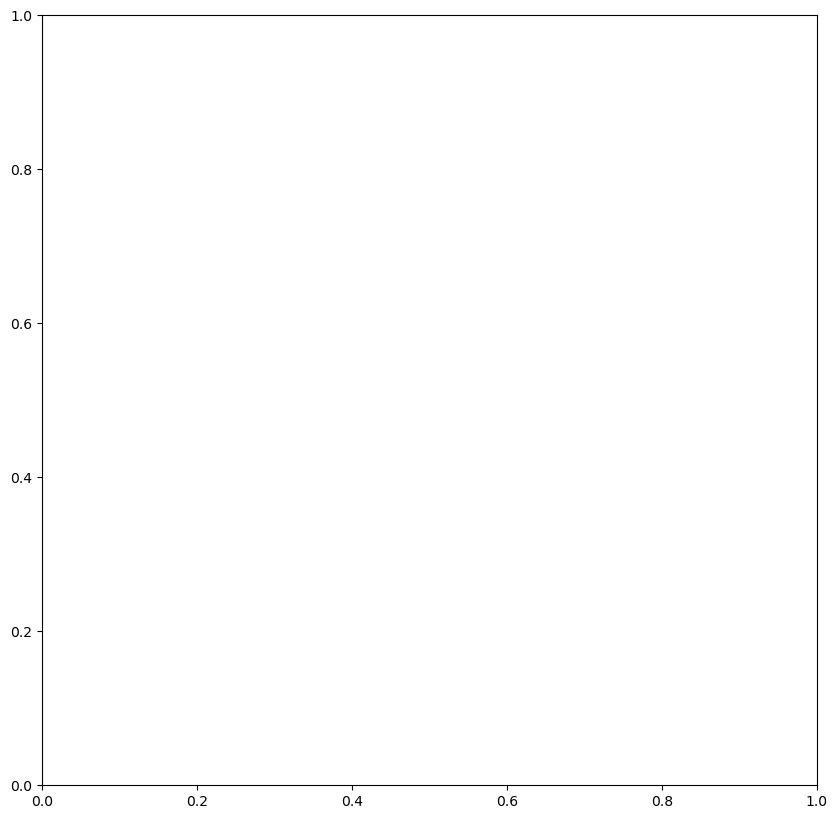

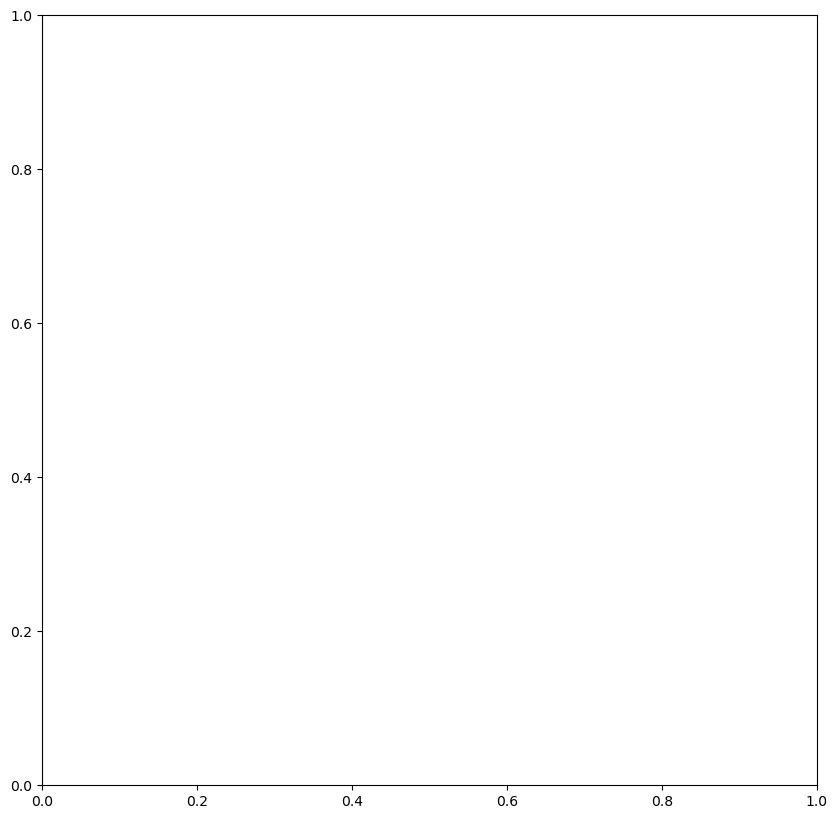

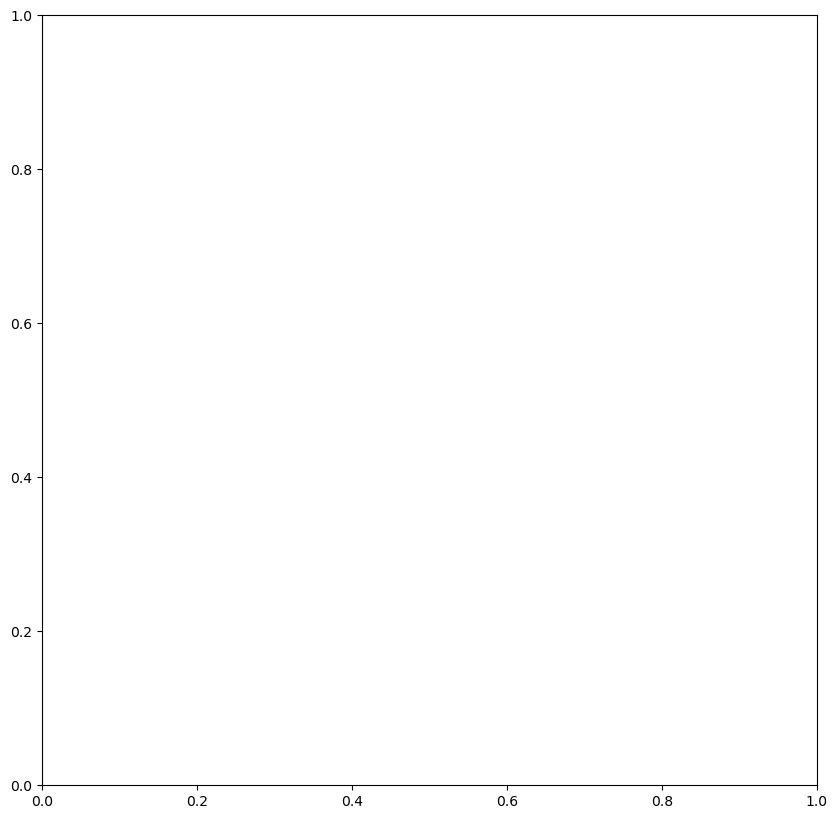

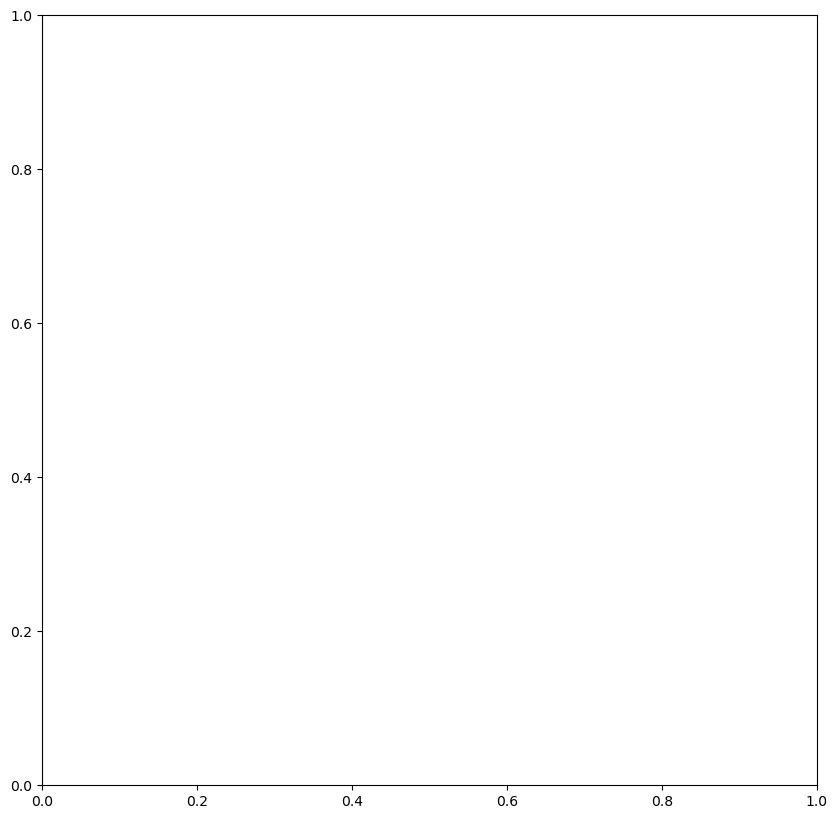

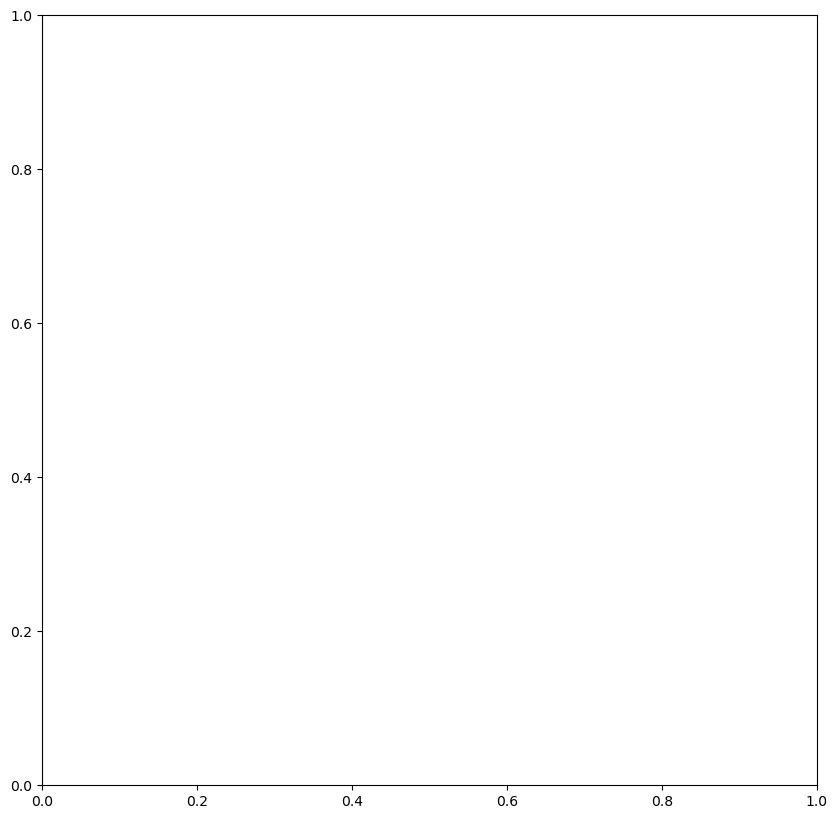

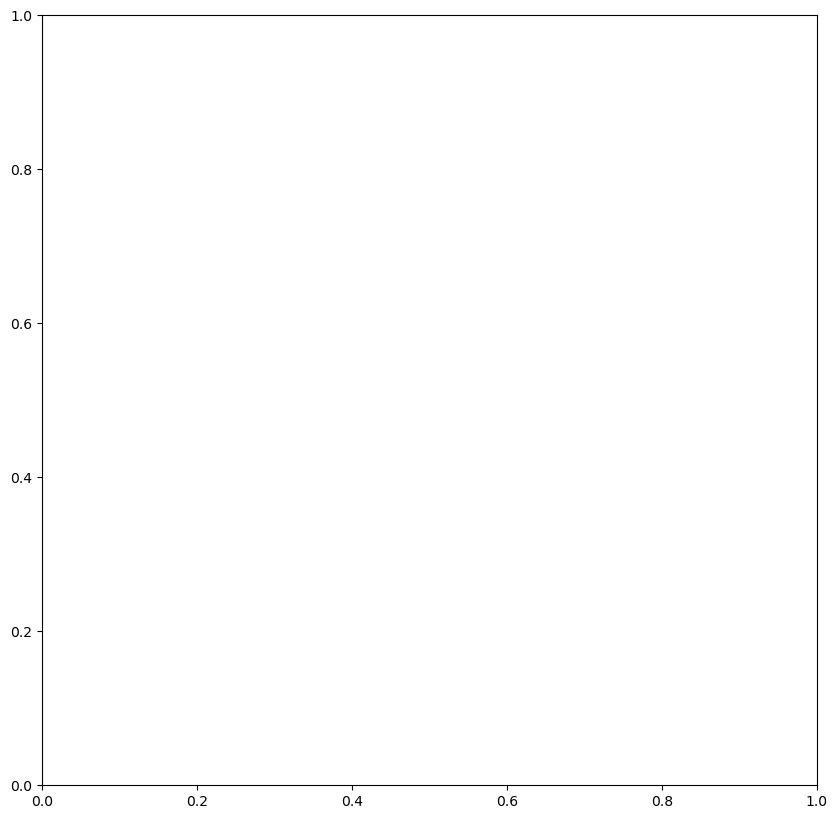

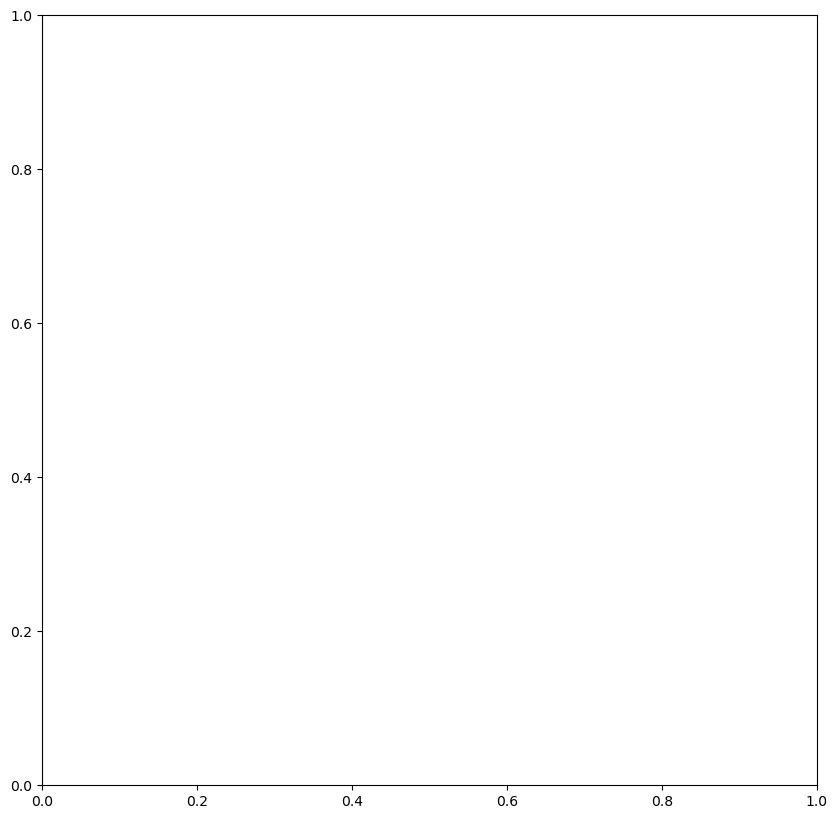

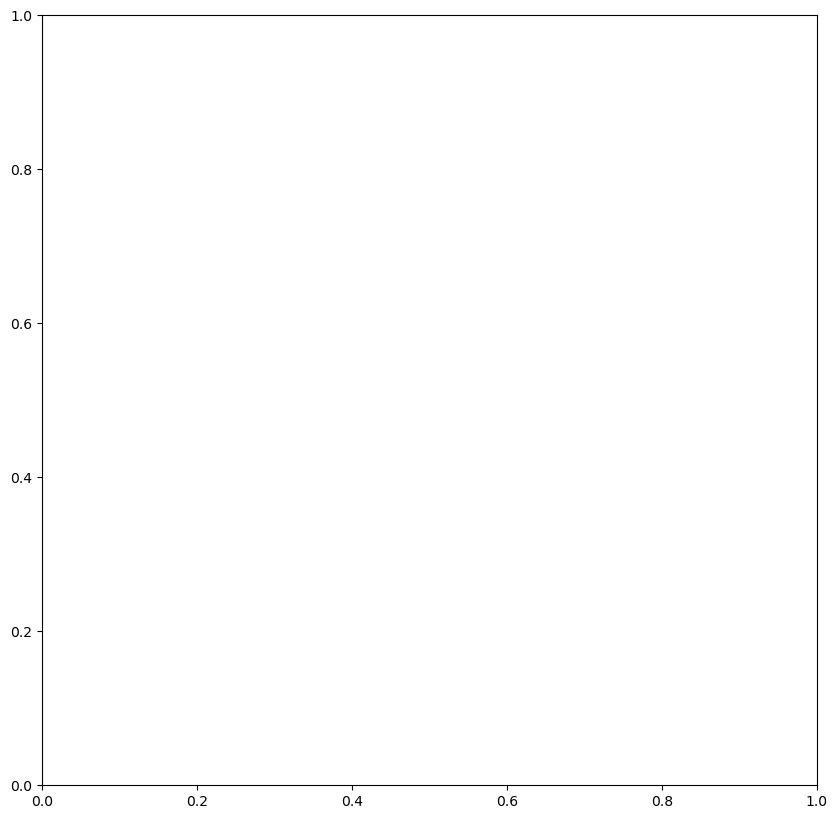

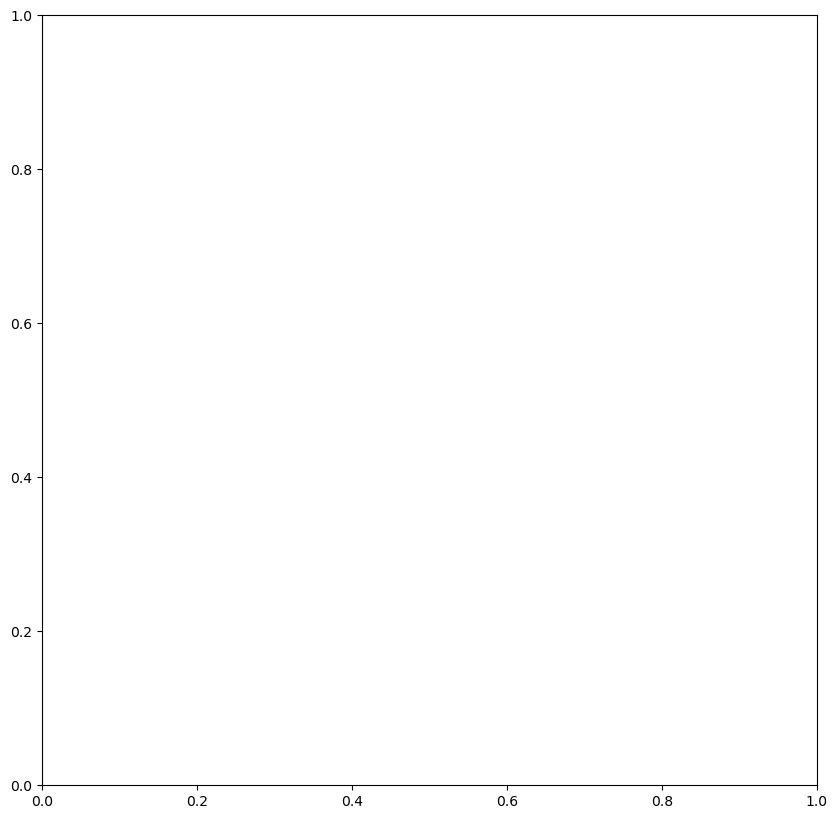

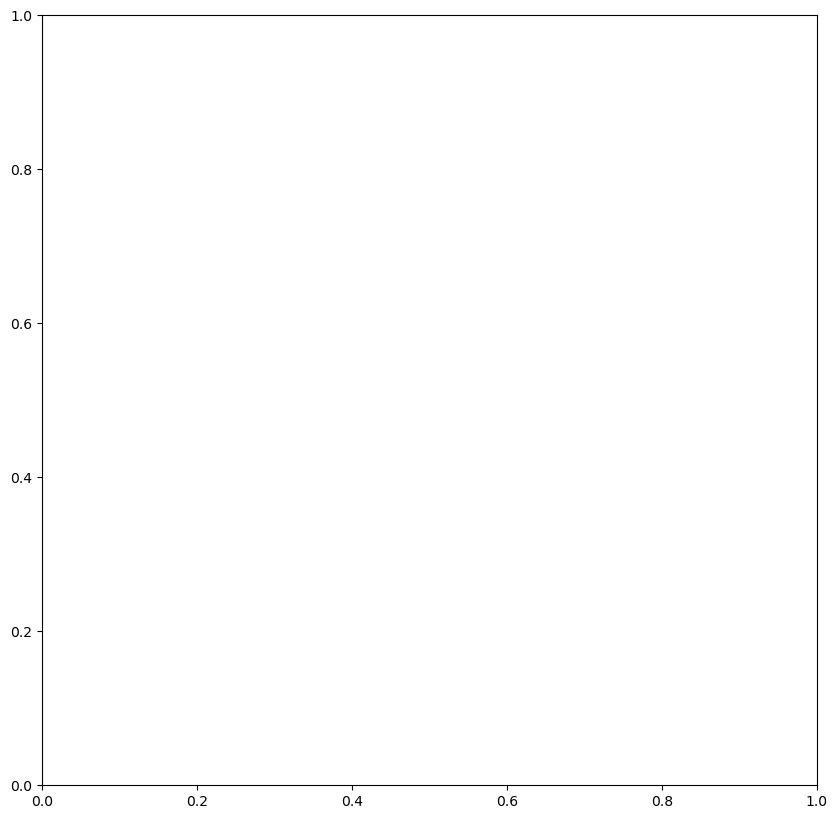

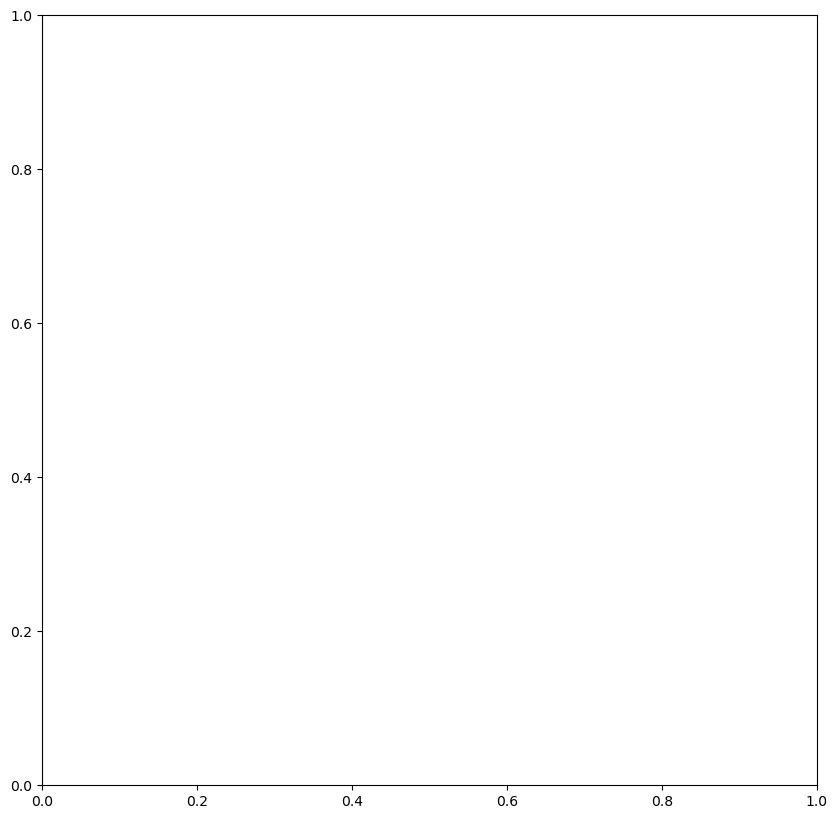

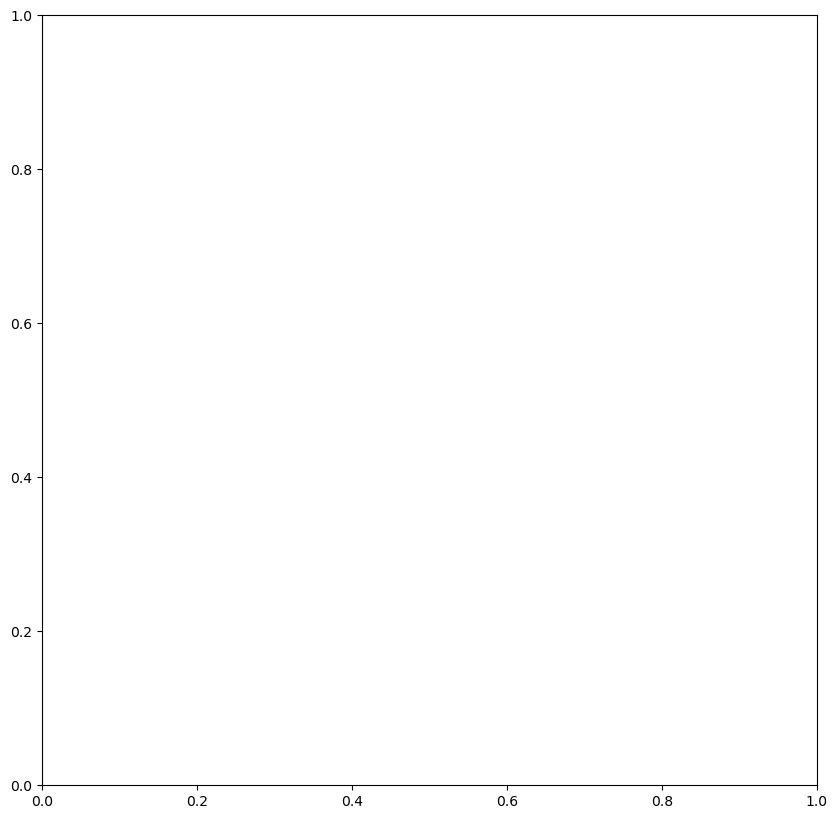

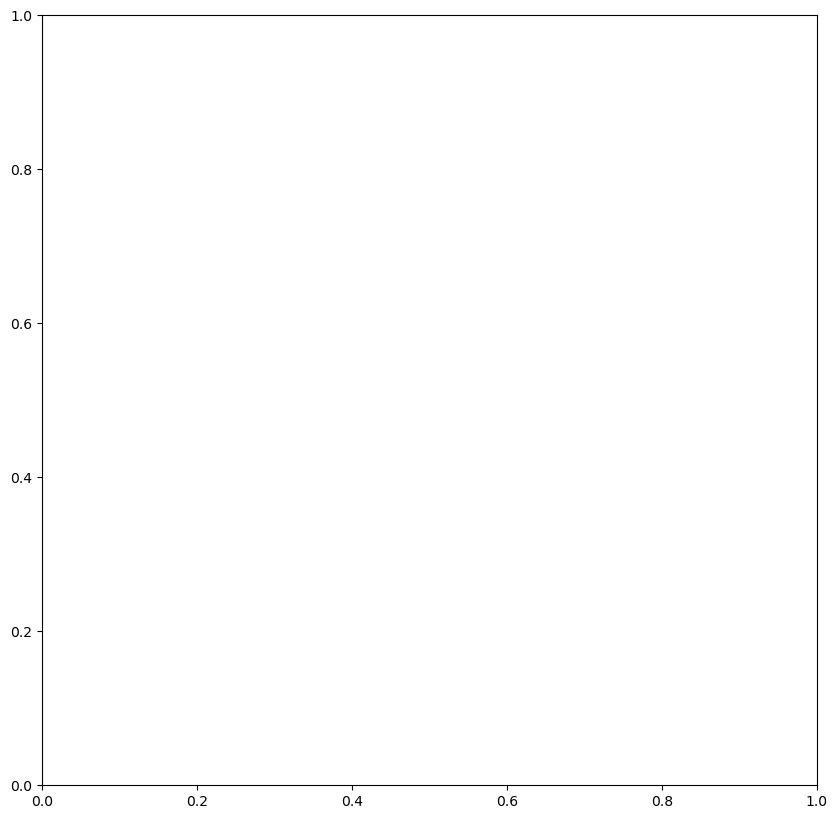

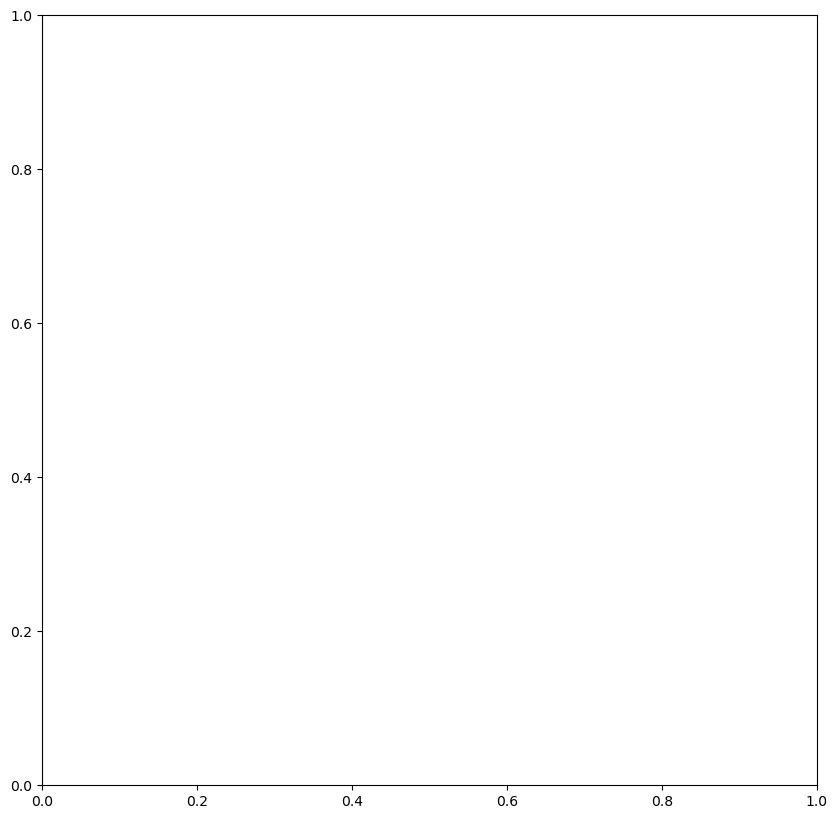

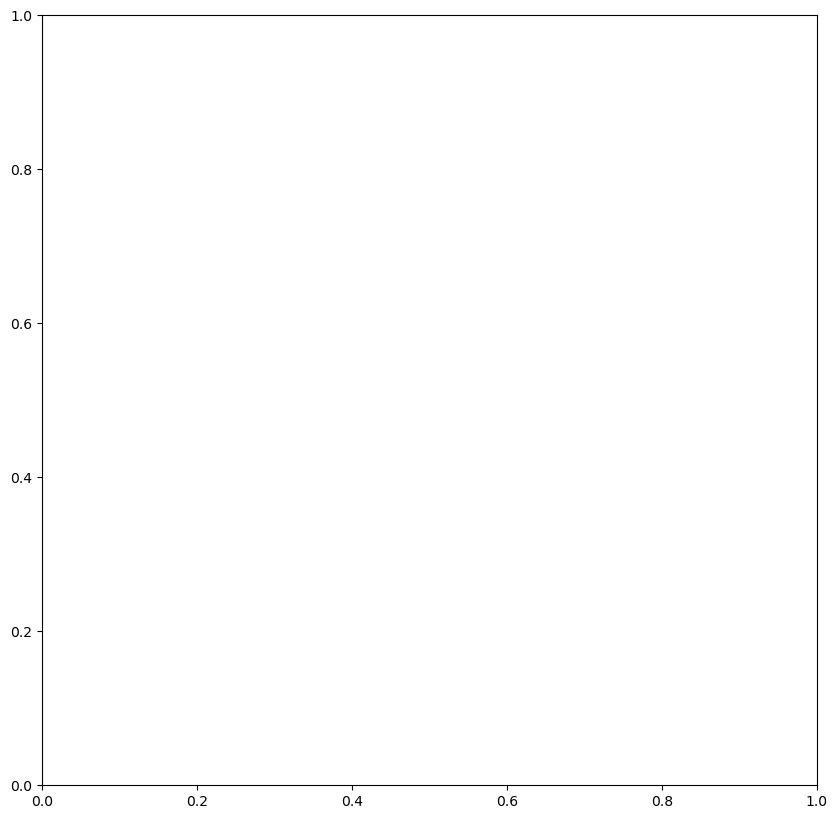

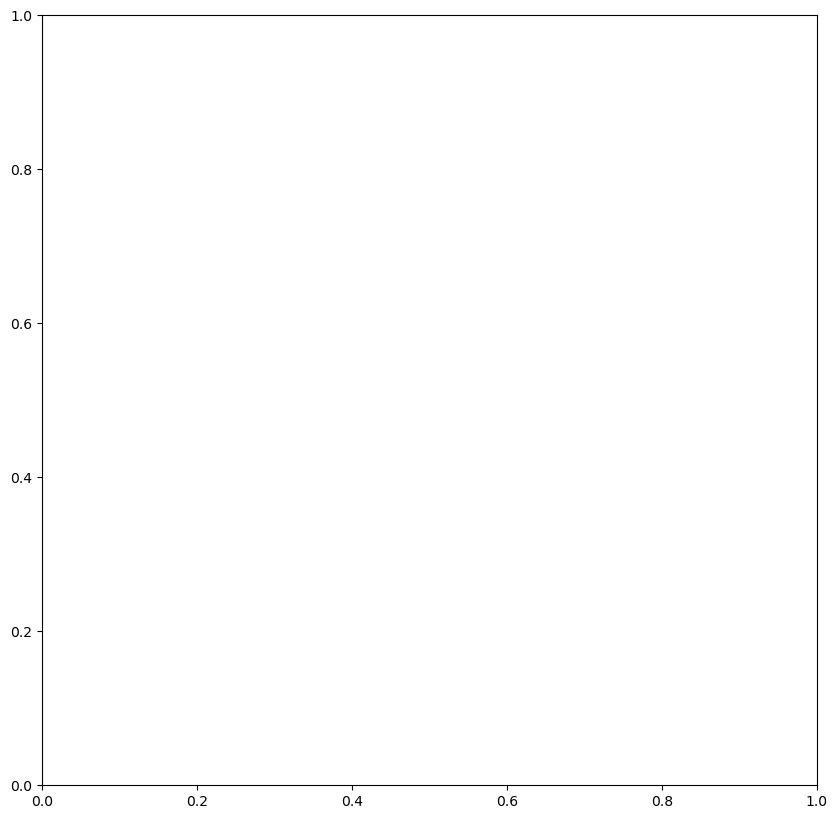

In [13]:
# Generate movies

#########################

# High-level user input
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3"    # Folder with data (without "/" at the end)
#start_time = 0                                                # What is the start time of the dataset?
t_bound = [20,42]                                               # Start and stop times for the GIF
vars_to_plot = ["Rho*","B_z*","U_x*","U_y*","B_y*","B_x*","P*","J_x*","J_y*","J_z*"]       # What native variable to plot
dt = 0.2                                                      # What is the timestep between files?
slice = "xz"                                                   # Set plane of slice ("xy" or "xz")

# Choose plot type from existing presets;
# "xz_field": overview plot of rho and field lines for making movies.
# Recommended settings:
#xlims=[-5,4]
#ylims=[-4.5,4.5]
#shape=[160,160]

# "dipolarization_zoom": bz and field lines to show particular dipolarization event in detail
# Recommended settings:
# xlims=[-2.2,0.2]
# ylims=[-1.2,1.2]
# shape=[160,160]

# "dipolarization_superzoom": plasma temp for even more zoomed region in xy plane
# Recommended settings:
# xlims=[-2.0,-0.5]
# ylims=[-1.0,1.0]
# shape=[160,160]

# "E_y":  flow vectors and duskward convective field
#xlims=[-2.2,0.2]
#ylims=[-1.2,1.2]
#shape=[160,160]

# "xy_flow": overview plot of rho and field lines for making movies.
# Recommended settings:
#xlims=[-5,4]
#ylims=[-4.5,4.5]
#shape=[160,160]

# "xz_tail": plot of pressure and field lines for making movies of dipolarization
# Recommended settings:
#xlims=[-8,2]
#ylims=[-2,2]
#shape=[220,110]

plot_preset = "xz_tail"

# Grid settings
xlims=[-8,2]
ylims=[-2,2]
shape=[220,110]

#########################

# First, get list of files in directory
dir=str(folder+"/")
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    if slice == "xy":
        match = re.search("^box_var_3_.*",file)
        if match != None:
            files.append(file)
    elif slice == "xz":
        match = re.search("^box_var_4_.*",file)
        if match != None:
            files.append(file)
    else:
        print("ERROR: bad slice plane!")
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
start_min = int(re.search(".*\_t(..)..\....\.plt",files[0])[1])
start_sec = int(re.search(".*\_t..(..)\....\.plt",files[0])[1])
start_millisec = int(re.search(".*\_t....\.(...)\.plt",files[0])[1])
start_time = 60.0*start_min + start_sec + 0.001*start_millisec
print("start time",start_time)
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
last_time = -1.0
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    filename = str(dir+named_files[time])

    # Get data from file
    mydata,xx,yy,zz = extract_2d_grid(filename,var_ls=vars_to_plot,shape=shape,xlims=xlims,ylims=ylims,plane=slice)

    # Do data manipulation here (NEEDS TO BE UPDATED TO USE xx,yy,zz AND WORK FOR BOTH XY and XZ
    ###########
    #x = np.linspace(xlims[0], xlims[1], shape[0])
    #y = np.linspace(ylims[0], ylims[1], shape[1])
    #xv, yv = np.meshgrid(x, y)

    #B_mag = np.sqrt(mydata["B_x*"]**2+mydata["B_y*"]**2+mydata["B_z*"]**2) # Field magnitude
    #beta = mydata["P*"]*1e-9 / ((B_mag*1e-9)**2/(2*mu_0))
    E_y = mydata["U_x*"] * mydata["B_z*"]* 1e3 * 1e-9 # vxB
    J = np.sqrt(mydata["J_x*"]**2+mydata["J_y*"]**2+mydata["J_z*"]**2)  # mA/m^2
    #T = mydata["P*"] * 1e9 / (mydata["Rho*"]*1e6 * k_b)
    T = np.divide(mydata["P*"], mydata["Rho*"], out=np.zeros_like(mydata["P*"]), where=mydata["Rho*"]!=0) * 1e-9 / 1e6 / k_b
    ###########
    
    # Plot!!
    fig, ax = plt.subplots(figsize=(10,10))
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')

    # Use preset
    if plot_preset == "E_y":
        im=ax.imshow(E_y*1e3, cmap='bwr', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]], origin="lower")
        clb=fig.colorbar(im)
        im.set_clim(-50,50)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$E_y$ [mV/m]',fontsize=12)
        #ax.contour(xv, yv, mydata["B_z*"], [0],colors='yellow')
        quiver_skip=10
        ax.quiver(xx[::quiver_skip,::quiver_skip], yy[::quiver_skip,::quiver_skip],mydata["U_x*"][::quiver_skip,::quiver_skip], mydata["U_y*"][::quiver_skip,::quiver_skip],color="white")
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Convection field and velocity at t="+str(round(time,2))+"s"))

    elif plot_preset == "dB_dx":
        im=ax.imshow(mydata["dB*"], cmap='viridis', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-100,300)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$dB_z/dx$ [nT/$R_M$]',fontsize=12)
        ax.contour(xv, yv, mydata["B_z*"], [0,20,40,60,80,100,120], colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Magnetic field gradient at t="+str(round(time,2))+"s"))

    elif plot_preset == "B_z":
        im=ax.imshow(mydata["B_z*"], cmap='bwr', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-50,50)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$dB_z$ [nT]',fontsize=12)
        #ax.contour(xv, yv, mydata["B_z*"], [0,20,40,60,80,100,120], colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Magnetic field at t="+str(round(time,2))+"s"))
        ax.add_patch(outer)
        ax.add_patch(inner)

    elif plot_preset == "DF":
        im=ax.imshow(mydata["dB*"], cmap='viridis', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-100,300)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$dB_z/dx$ [nT/$R_M$]',fontsize=12)
        ax.contour(xv, yv, beta, [0.95,1,1.05], colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Magnetic field gradient at t="+str(round(time,2))+"s"))

    elif plot_preset == "U_x":
        im=ax.imshow(mydata["U_x*"], cmap='rainbow', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]])
        clb=fig.colorbar(im)
        im.set_clim(-600,600)
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$Velocity$ [km/s]',fontsize=12)
        ax.contour(xv, yv, mydata["B_z*"], [0],colors='yellow')
        ax.quiver(xv[::10,::10], yv[::10,::10], mydata["U_x*"][::10,::10], mydata["U_y*"][::10,::10])
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("$U_x$ at t="+str(round(time,2))+"s"))
    
    elif plot_preset == "xz_field":
        #Define streamtrace start points
        start_points = np.zeros([80,2])
        start_points[:40,0]=1.02*np.cos(np.linspace(0,2*np.pi,40))
        start_points[:40,1]=1.02*np.sin(np.linspace(0,2*np.pi,40))
        start_points[40:50,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[40:50,1] = ylims[0]
        start_points[50:60,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[50:60,1] = ylims[1]
        start_points[60:70,0] = xlims[0]
        start_points[60:70,1] = np.linspace(ylims[0],ylims[1],10)
        start_points[70:,0] = np.linspace(-5,-2,10)
        start_points[70:,1] = 0.2
        
        im=ax.imshow(mydata["Rho*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=120), origin='lower')
        ax.streamplot(xx,zz,mydata["B_x*"],mydata["B_z*"],color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        ax.plot([-3.5,0,0,-3.5,-3.5],[-0.3,-0.3,0.7,0.7,-0.3],linestyle="dashed",color="grey",linewidth=1.5,alpha=0.8) # show pic box
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('rho [amu/cc]',fontsize=12)
        ax.set_title(str("Density at t="+str(round(time,2))+"s"))
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")

    elif plot_preset == "xz_tail":
        fig, ax = plt.subplots(figsize=(16,8))
        #Define streamtrace start points
        start_points = np.zeros([90,2])
        start_points[:40,0]=1.02*np.cos(np.linspace(0,2*np.pi,40))
        start_points[:40,1]=1.02*np.sin(np.linspace(0,2*np.pi,40))
        start_points[40:50,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[40:50,1] = ylims[0]
        start_points[50:60,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[50:60,1] = ylims[1]
        start_points[60:70,0] = xlims[0]
        start_points[60:70,1] = np.linspace(ylims[0],ylims[1],10)
        start_points[70:80,0] = np.linspace(-4,-2.0,10) # current sheet
        start_points[70:80,1] = np.linspace(0.55,0.3,10) 
        start_points[80:,0] = -1.1 # dipolarization region
        start_points[80:,1] = np.linspace(0,0.2,10)
        
        im=ax.imshow(mydata["P*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=0.01, vmax=20), origin='lower')
        ax.streamplot(xx,zz,mydata["B_x*"],mydata["B_z*"],color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        #Draw pic box
        #ax.plot([-3.5,0,0,-3.5,-3.5],[-0.3,-0.3,0.7,0.7,-0.3],linestyle="dashed",color="grey",linewidth=1.5,alpha=0.8) # show pic box
        
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('P [nPa]',fontsize=12)
        ax.set_title(str("Pressure at t="+str(round(time,2))+"s"))
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")

    elif plot_preset == "dipolarization_zoom":
        #Define streamtrace start points
        start_points = np.zeros([70,2])
        start_points[:40,0]=1.02*np.cos(np.linspace(np.pi/2,3*np.pi/2,40))
        start_points[:40,1]=1.02*np.sin(np.linspace(np.pi/2,3*np.pi/2,40))
        start_points[40:50,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[40:50,1] = ylims[0]
        start_points[50:60,0] = np.linspace(xlims[0],xlims[1],10)
        start_points[50:60,1] = ylims[1]
        start_points[60:,0] = np.linspace(ylims[0],-1,10)
        start_points[60:,1] = 0.2
        
        im=ax.imshow(mydata["B_z*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]],cmap='bwr', origin='lower')
        ax.streamplot(xx,zz,mydata["B_x*"],mydata["B_z*"],color='black',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        ax.set_title(str("Magnetic field at t="+str(round(time,2))+"s"))
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        im.set_clim(-80,80)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")

    elif plot_preset == "dipolarization_superzoom":
        #Define streamtrace start points
        im2=ax.imshow(mydata["B_z*"],extent=[xlims[0], xlims[1],ylims[0], ylims[1]], origin='lower',)
        im=ax.imshow(T,extent=[xlims[0], xlims[1],ylims[0], ylims[1]],cmap='rainbow', origin='lower', norm=LogNorm(vmin=1e6, vmax=1e9))
        ax.set_title(str("Plasma temperature at t="+str(round(time,2))+"s"))
        cont=ax.contour(xx, yy, mydata["B_z*"], np.linspace(20,100,21),linewidths=0.8)
        clb1=fig.colorbar(im)
        clb2=fig.colorbar(im2)
        clb1.ax.tick_params(labelsize=8) 
        clb1.ax.tick_params(labelsize=8) 
        clb1.ax.set_title('T [K]',fontsize=12)
        clb2.ax.set_title('$B_Z$ [nT]',fontsize=12)
        #im.set_clim(1e7,1e8)
        im2.set_clim(20,100)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")

    elif plot_preset == "xy_current":
        start_points = np.zeros([5,2])
        start_points[:,0]=np.linspace(-2.25,-1.25,5)
        start_points[:,1]=0
        
        im=ax.imshow(J,extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=0.01, vmax=0.8),cmap='viridis', origin='lower')
        quiver_skip=5
        ax.quiver(xv[::quiver_skip,::quiver_skip], yv[::quiver_skip,::quiver_skip],
                  mydata["J_x*"][::quiver_skip,::quiver_skip], mydata["J_y*"][::quiver_skip,::quiver_skip],
                  color="white",scale=5,minlength=0.6)
        ax.streamplot(xx,yy,mydata["J_x*"],mydata["B_y*"],color='white',linewidth=0.8,broken_streamlines=False,arrowsize=0.7,
                      start_points=start_points)
        ax.set_title(str("Current at t="+str(round(time,2))+"s"))
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('Current [mA/m$^2]',fontsize=12)
        #im.set_clim(-80,80)
        ax.add_patch(outer,zorder=2)
        ax.add_patch(inner,zorder=2)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect(1)
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")

    else: 
        im=ax.imshow(mydata["Rho*"], cmap='bwr', interpolation='none', 
                     extent=[xlims[0], xlims[1],ylims[0], ylims[1]],norm=LogNorm(vmin=1, vmax=150))
        clb=fig.colorbar(im)
        clb.ax.tick_params(labelsize=8) 
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        #ax.contour(xv, yv, mydata["U_x*"], [0],colors='white')
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.set_title(str("Density at t="+str(round(time,2))+"s"))

    # Save
    fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(round(time,2))+'.png'),bbox_inches='tight')
    #plt.show()
    plt.close(fig)

print("last file read:",filename)



## Convert to GIF

In [17]:
# Generate GIF from frames

import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#read all the .png files in directory "frames"
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/"
files = glob.glob(str(dir+"*vx_vy-vx_vz*.png"))
image_array = []
files=natsorted(files)

for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)
    
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 8))

# Set the initial image
im = ax.imshow(image_array[0], animated=True)
plt.axis('off')

def update(i):
    im.set_array(image_array[i])
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

# Show the animation
#plt.show()

animation_fig.save(str(dir+"animated.gif"),dpi=500)
plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


['/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_29.4.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_30.4.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_32.6.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_34.0.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_25.8.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_27.8.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_34.2.png', '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/vx_vy-vx_vz_[-1.8, -0.42, 0.3]_32.4.png', '/Users/atcushen/Documents/MercuryModel

## Compute $\delta B$

In [2]:
# New challenge: Compute dB, the perturbation field, using same approach as Dewey 2020:
# Basically, for some point (x,y), we subtract the average B_Z in that cell from -20<t<-10s
# The plan is to first accept input for the time range to be computed (e.g. t=25 to t=28s) and cadence (0.1s default).
# Then, all the B_z values from 5-18 s will be loaded and saved to arrays
# For each desired plot time, we then loop over the arrays to compute the average for each cell.
# There is probably a more numerically efficient way to do this, but I can't think of it.

# import modules
from os import listdir
from os.path import isfile, join
import re
import tecplot as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *
import matplotlib.animation as animation
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl


# Set start and end times of output
t_bound = [20,23]
dt = 0.2

# Directory of files
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-2"
start_time = 0 # earliest time in the directory

# Grid settings
xlims=[-2,-0.8]#[-2,0]
ylims=[-0.8,0.8]#[-1.5,1.5]
shape=[300,400]#[300,450]

#########################

# First, get list of files in directory
dir=str(folder+"/")
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    match = re.search("^box_var_3_.*",file)
    if match != None:
        files.append(file)
files.sort()        
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Now, import the needed data as numpy arrays and save to a dictionary
bz_data = {}
for n in range(int((t_bound[1]-10-(t_bound[0]-20))/dt+1)):
    time = round(t_bound[0]-20+dt*n,3)
    # Use extract_2d_grid() to pull the datasets
    filename = str(dir+str(named_files[time]))
    bz_data[time] = extract_2d_grid(filename,var_ls=["B_z*"],shape=shape,xlims=xlims,ylims=ylims)[0]["B_z*"]
    # Note that extract_2d_grid returns a dictionary; we just need the B_z item.

print(str(n),"files read!")

118 files recognized!
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Serv

In [3]:
# Now, just the files we need are saved in bz_data. Now, we loop over the desired output times and compute the average values
output = {}
for n in range(int((t_bound[1]-(t_bound[0]))/dt+1)):
    # First, load the actual B_z data for the output time (e.g. t=25s)
    time = round(t_bound[0]+dt*n,3)
    filename = str(dir+str(named_files[time]))
    data,xx,yy,zz = extract_2d_grid(filename,var_ls=["B_z*","U_x*"],shape=shape,xlims=xlims,ylims=ylims)
    output[time] = data["B_z*"]
    
    # Then, loop over the 10s range to compute the avg.
    bz_avg = np.zeros_like(output[time])
    for m in range(0,int(10/dt)+1):
        avg_time = round(time-20+dt*m,3)
        #print(avg_time)
        bz_avg += bz_data[avg_time]
    bz_avg = bz_avg/(10/dt+1)

    # Subtract average
    output[time] = output[time] - bz_avg

    # Plot!
    fig, ax = plt.subplots(figsize=(6,6))
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    im=ax.imshow(output[time], cmap='coolwarm', interpolation='none', 
                 extent=[xlims[0], xlims[1], ylims[0], ylims[1]], origin='lower')
    #ax.contour(xx, yy, data["U_x*"], [0],colors='white')
    ax.contour(xx, yy, data["B_z*"], [0],colors='white')
    clb=fig.colorbar(im)
    im.set_clim(-10,10)
    clb.ax.tick_params(labelsize=8)
    clb.ax.set_title('$\delta B_z$ [nT]',fontsize=12)
    #ax.contour(xv, yv, mydata["B_z*"], [0],colors='yellow')
    #quiver_skip=20
    #ax.quiver(xv[::quiver_skip,::quiver_skip], yv[::quiver_skip,::quiver_skip], 
    #          mydata["U_x*"][::quiver_skip,::quiver_skip], mydata["U_y*"][::quiver_skip,::quiver_skip],color="white")
    ax.set_aspect(1) # 
    ax.set_xlabel("X [$R_M$]")
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_ylabel("Y [$R_M$]")
    ax.set_title(str("Perturbed $B_z$ at t="+str(time)+"s"))
    ax.add_patch(outer)
    ax.add_patch(inner)

    # Save
    fig.savefig(str(folder+"_plots/"+"deltaB_"+str(round(time,2))+'.png'),bbox_inches='tight')
    #plt.show()
    plt.close(fig)

Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Connecting to Tecplot 360 TecUtil Server on:
    tcp://local

In [8]:
# Generate GIF from frames

import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#read all the .png files in directory "frames"
files = glob.glob(r"pic_E_y/*.png")
image_array = []
files=natsorted(files)

for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)
    
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 8))

# Set the initial image
im = ax.imshow(image_array[0], animated=True)
plt.axis('off')

def update(i):
    im.set_array(image_array[i])
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=1000, blit=True,repeat_delay=10,)

# Show the animation
#plt.show()

animation_fig.save("pic_E_y/animated.gif")
plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


## Entropy calc

In [10]:
# Now, to speed up entropy calculation, we want to halt if a streamtrace isnt closed...

# Loop entropy calculation over multiple files

# Import modules
import tecplot as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *


# Define constants
R_M = 2440e3 #m


# Define grid / data variables
start_time = 153                                                # What is the start time of the dataset?
t_bound = [153,158]  
n_time = 5
dt = 1
dir = "/Users/atcushen/Documents/SWMF/inv2/run4/GMPC-ta-4/"    # Directory with data 

# First, get list of files in directory
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    match = re.search("^3d__var_4_.*",file)
    if match != None:
        files.append(file)
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
last_time = -1.0
iter=0
results=[]
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    print("time:",time)
    filename = str(dir+named_files[time])
    z_plane = 0.2
    x_min = -2
    x_max = -0.8
    y_min = -0.8
    y_max = 0.8
    nx = 60
    ny = 80
    
    
    # Generate meshgrid
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    xv, yv = np.meshgrid(x, y)
    zv = z_plane+np.zeros_like(xv)
    
    # Load file and define vector for streamtrace
    tp.session.connect()
    tp.new_layout()
    dataset = tp.data.load_tecplot(filename)
    frame = tp.active_frame()
    plot = frame.plot(PlotType.Cartesian3D)
    plot.vector.u_variable_index=10
    plot.vector.v_variable_index=11
    plot.vector.w_variable_index=12
    
    
    # Define entropy
    tp.data.operate.execute_equation(equation='{gamma} = 5/3',
        ignore_divide_by_zero=True)
    tp.data.operate.execute_equation(equation='{Bmag} = sqrt({B_x [nT]}**2+{B_y [nT]}**2+{B_z [nT]}**2)',
        ignore_divide_by_zero=True)
    tp.data.operate.execute_equation(equation='{entropy}=({P [nPa]}*10**(-9))**(1/{gamma})/({Bmag}*10**(-9))',
        ignore_divide_by_zero=True)
    
    # Pull out x-velocity and interpolate onto grid
    #v_x = dataset.variable('U_x*')
    shape = (nx,ny)
    
    rect_zone = dataset.add_ordered_zone('current_sheet',shape)
        
    rect_zone.values('X*')[:] = xv.ravel()
    rect_zone.values('Y*')[:] = yv.ravel()
    rect_zone.values('Z*')[:] = zv.ravel()
    
    X_seed = rect_zone.values('X*')
    Y_seed = rect_zone.values('Y*')
    Z_seed = rect_zone.values('Z*')
    
    tp.data.operate.interpolate_linear(rect_zone, dataset.zone('3D*'), dataset.variable('U_x*'))
    tp.data.operate.interpolate_linear(rect_zone, dataset.zone('3D*'), dataset.variable('B_z*'))
    u_x_shapeless = rect_zone.values('U_x*').as_numpy_array() #unfortunately, it is unstructed, so we need to force into the right shape
    b_z_shapeless = rect_zone.values('B_z*').as_numpy_array() 
    u_x = np.zeros_like(xv)
    b_z = np.zeros_like(xv)
    count=0
    for j in range(ny):
        for i in range(nx):
            u_x[-j,-i] = u_x_shapeless[-count]
            b_z[-j,-i] = b_z_shapeless[-count]
            count+=1
    
    # Loop over each grid point:
    H = np.zeros_like(xv)
    index = dataset.variable('entrop*').index+1 # get index for entropy data, add one since it uses 1-based indexing
    zone = 3 # Zone1 is data, zone2 is current_sheet
    with tp.session.suspend():    
        for i in range(nx):
            for j in range(ny): # j is row (y), i is column (x)
                plot.streamtraces.delete_all()
                if (xv[j,i]**2+yv[j,i]**2)>1.0:
                    #print("Meshgrid coord [",j,",",i,"] and real coord (",xv[j,i],",",yv[j,i])
                    plot.streamtraces.add(seed_point=[xv[j,i], yv[j,i], z_plane],stream_type=Streamtrace.VolumeLine)
                    plot.streamtraces.extract()
                    
                    #ONLY PROCEED TO INTEGRATION IF STREAMLINE IS CLOSED: (i use zone-1 since zone=3 is for 1 based index, and this needs 0 based)
                    streamline_max = np.sqrt(dataset.zone(int(zone-1)).values("X*").max()**2+dataset.zone(zone-1).values("Y*").max()**2+dataset.zone(zone-1).values("Z*").max()**2)
                    streamline_min = np.sqrt(dataset.zone(int(zone-1)).values("X*").min()**2+dataset.zone(zone-1).values("Y*").min()**2+dataset.zone(zone-1).values("Z*").min()**2)

                    #Closed field lines
                    if streamline_max<100 and streamline_min<100:
                        tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
                                command=str("Integrate ["+str(zone)+"] VariableOption='Scalar' XOrigin=0 YOrigin=0 ZOrigin=0 ScalarVar="+str(4)+" Absolute='F' ExcludeBlanked='F' XVariable=1 YVariable=2 ZVariable=3 IntegrateOver='Cells' IntegrateBy='Zones' IRange={MIN =1 MAX = 0 SKIP = 1} JRange={MIN =1 MAX = 0 SKIP = 1} KRange={MIN =1 MAX = 0 SKIP = 1} PlotResults='F' PlotAs='Result' TimeMin=0 TimeMax=0"))
                        H[j,i] = tp.active_frame().aux_data['CFDA.INTEGRATION_TOTAL']
                    #Open/closed 
                    elif streamline_max<100 or streamline_max<100:
                        H[j,i] = 10/R_M
                    #Open
                    else:
                        H[j,i] = 1000/R_M
                    zone+=1
                    if zone%10==0:
                        print(time, zone, end =" ")
    print("done!")
    #Move into physical units
    H = H*R_M
    
    #Plot
    fig, axs = plt.subplots(figsize=(10,10))
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    im=axs.imshow(H, cmap='rainbow', interpolation='none', extent=[x_min,x_max,y_min,y_max], 
                  origin='lower', norm=LogNorm(vmin=10, vmax=1e8))
    axs.contour(xv, yv, u_x, [0],colors='yellow')
    axs.contour(xv, yv, b_z, [0],colors='white')
    clb=fig.colorbar(im)
    im.set_clim(1e6,6e7)
    clb.ax.tick_params(labelsize=8) 
    clb.ax.set_title('$H$ [unit]',fontsize=12)
    axs.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    axs.set_xlabel("X [$R_M$]")
    axs.set_ylabel("Y [$R_M$]")
    axs.set_title(str("Flux tube entropy at t="+str(time)+"s"))

    fig.savefig(str("entropy/"+str(round(time,2))+'.png'),bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    iter+=1

5 files recognized!
time: 153
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
153 10 153 20 153 30 153 40 153 50 153 60 153 70 153 80 153 90 153 100 153 110 153 120 153 130 153 140 153 150 153 160 153 170 153 180 153 190 153 200 153 210 153 220 153 230 153 240 153 250 153 260 153 270 153 280 153 290 153 300 153 310 153 320 153 330 153 340 153 350 153 360 153 370 153 380 153 390 153 400 153 410 153 420 153 430 153 440 153 450 153 460 153 470 153 480 153 490 153 500 153 510 153 520 153 530 153 540 153 550 153 560 153 570 153 580 153 590 153 600 153 610 153 620 153 630 153 640 153 650 153 660 153 670 153 680 153 690 153 700 153 710 153 720 153 730 153 740 153 750 153 760 153 770 153 780 153 790 153 800 153 810 153 820 153 830 153 840 153 850 153 860 153 870 153 880 153 890 153 900 153 910 153 920 153 930 153 940 153 950 153 960 153 970 153 980 153 990 153 1000 153 1010 153 1020 153 1030 153 1040 153 1050 153 1060 153 1070 153 1080 153 1090 153

In [2]:
kb = 1.38e-23
n = 15e6
T = 1e5
p = 0.82e-9
print(n*kb*T*1e9)

0.0207


In [12]:
p =

7246376811594.204

In [25]:
36*1e6 * 2440000**3

5.22964224e+26

In [11]:
10**9*2.2*np.pi*(2e-6)**2

0.02764601535159018

In [14]:
500e3/R_M

0.20491803278688525